# Imports

In [26]:
import seaborn as sns
import math as math
from datetime import datetime
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from pmdarima import auto_arima
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.preprocessing.sequence import TimeseriesGenerator
from pathlib import Path
import os
from fbprophet import Prophet

from traceback import print_exc

# Functions

In [14]:
def CleanNegatives(df,Tag,CleanName):
    InBlock = False  # Tags that I am inside of a -999 block
    Start = 0
    End   = 0
    Clean = df[Tag]
    for Index in range(len(Clean)):
        if InBlock:
            if Clean[Index] > 0: # Exit condition 
                End = Index
                InBlock = False
                if Start ==0:
                    AVG = Clean[End]
                elif End == len(Clean) - 1:
                    AVG = Clean[Start]
                else:
                    AVG = (Clean[Start-1]+Clean[End])/2
                # Cleaning negatives, replacing by average at the endpoints of the block
                for NewIndex in range(Start,End):
                    Clean[NewIndex] = AVG
        else:  # Not In the block
            if Clean[Index] < 0: # Enter condition
                Start = Index
                InBlock = True
    df[CleanName] = Clean
                

In [15]:
def Cleanup(df,Tag1,Tag2,ResultTag):
    Clean = []
    for i in range(len(df)):
        Value = ( df[Tag1][i] if not math.isnan(df[Tag1][i]) else df[Tag2][i])
        Clean.append(Value)
    df[ResultTag] = Clean

# Cleaning Data

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [17]:
datapath = Path.cwd() / "data"
print(datapath)

/Users/dc/Desktop/Flatiron/projects/Capstone-Disney-World-Date-and-Attendance-Predictor/data


In [18]:
datasets = os.listdir(datapath)
datasets = list(sorted(datasets))
print(datasets)

['7_dwarfs_train.csv', 'dinosaur.csv', 'entities.csv', 'expedition_everest.csv', 'kilimanjaro_safaris.csv', 'metadata.csv', 'navi_river.csv', 'pirates_of_caribbean.csv', 'rock_n_rollercoaster.csv', 'slinky_dog.csv', 'soarin.csv', 'spaceship_earth.csv', 'splash_mountain.csv', 'touringplans_data_dictionary.xlsx', 'toy_story_mania.csv']


In [19]:
for i in datasets:
    try:
        exec(f"{i.split('.csv')[0]} = pd.read_csv(datapath / i)")
    except:
        print(f"{i} cannot be imported automatically")

7_dwarfs_train.csv cannot be imported automatically
touringplans_data_dictionary.xlsx cannot be imported automatically


In [20]:
seven_dwarfs_train = pd.read_csv(datapath / "7_dwarfs_train.csv")
datasets[0] = "seven_dwarfs_train.csv"

In [37]:
data_dict = {}
for i in datasets:
    try:
        data_dict[i.split('.csv')[0]] = eval(f"{i.split('.csv')[0]}")
    except:
        print_exc()
print(data_dict.keys())

dict_keys(['seven_dwarfs_train', 'dinosaur', 'entities', 'expedition_everest', 'kilimanjaro_safaris', 'metadata', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania'])


In [38]:
data_dict['dinosaur'].head()

date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0           10.0
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0           10.0

In [9]:
# for i in datasets:
#     try:
#         print(i)
#         display(eval(f"{i.split('.csv')[0]}.head()"), eval(f"len({i.split('.csv')[0]})"))
#     except:
#         pass

seven_dwarfs_train.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0

321631

dinosaur.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0

252403

entities.csv


code                                               name  \
0  AK01                            It's Tough to Be a Bug!   
1  AK07                                Kilimanjaro Safaris   
2  AK11  Expedition Everest - Legend of the Forbidden M...   
3  AK14                                  Kali River Rapids   
4  AK18                                           DINOSAUR   

               short_name              land   opened_on  duration  \
0  It's Tough to Be a Bug  Discovery Island  04/22/1998       8.0   
1     Kilimanjaro Safaris            Africa  04/22/1998      20.0   
2      Expedition Everest              Asia  04/07/2006       4.0   
3       Kali River Rapids              Asia  02/15/1999      10.0   
4                DINOSAUR   DinoLand U.S.A.  04/22/1998       3.5   

   average_wait_per_hundred  
0                      12.0  
1                       4.0  
2                       4.0  
3                       5.0  
4                       3.0

95

expedition_everest.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0
3  01/01/2015  2015-01-01 08:12:23      NaN       5.0
4  01/01/2015  2015-01-01 08:19:26      NaN       5.0

275274

kilimanjaro_safaris.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0

257785

metadata.csv


DATE WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
0  01/01/2015               NaN          5          0           0   
1  01/02/2015               NaN          6          1           0   
2  01/03/2015               NaN          7          2           0   
3  01/04/2015               NaN          1          3           1   
4  01/05/2015               NaN          2          4           1   

   MONTHOFYEAR  YEAR          SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY  \
0            1  2015  CHRISTMAS PEAK          0         5      nyd        1   
1            1  2015       CHRISTMAS          2         5      NaN        0   
2            1  2015       CHRISTMAS          3         0      NaN        0   
3            1  2015       CHRISTMAS          4         0      NaN        0   
4            1  2015       CHRISTMAS          5         0      NaN        0   

  WDWTICKETSEASON WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  \
0             NaN      NaN       NaN         0        0  CHRISTMAS PEAK   
1             NaN      NaN       NaN         0        0       CHRISTMAS   
2             NaN      NaN       NaN         0        0       CHRISTMAS   
3             NaN      NaN       NaN         0        0       CHRISTMAS   
4             NaN      NaN       NaN         0        0       CHRISTMAS   

   WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent  \
0       73.02       59.81        66.41      NaN        0      NaN        0   
1       78.00       60.72        69.36      NaN        0      NaN        0   
2       83.12       67.31        75.22      NaN        0      NaN        0   
3       83.93       67.97        75.95      NaN        0      NaN        0   
4       72.30       56.89        64.60      NaN        0      NaN        0   

  HSeventN  HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      NaN        0      NaN        0      NaN        0%                   0%   
1      NaN        0      NaN        0      NaN        0%                   0%   
2      NaN        0      NaN        0      NaN        0%                   0%   
3      NaN        0      NaN        0      NaN       67%                  74%   
4      NaN        0      NaN        0      NaN       67%                  74%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3           77%           74%                74%                70%   
4           77%           74%                74%                70%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                  66%          94%                  68%                 57%   
4                  66%          94%                  68%                 57%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                 56%                70%               79%   
4                 56%                70%               79%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA  \
0                   0%                0%              0%                 0%   
1                   0%                0%              0%                 0%   
2                   0%                0%              0%                 0%   
3                  43%               93%            100%               100%   
4                  43%              

2079

navi_river.csv


date             datetime  SACTMIN  SPOSTMIN
0  05/26/2017  2017-05-26 09:09:46      NaN    -999.0
1  05/26/2017  2017-05-26 09:10:12      NaN       5.0
2  05/26/2017  2017-05-26 09:17:09      NaN      45.0
3  05/26/2017  2017-05-26 09:24:07      NaN      45.0
4  05/26/2017  2017-05-26 09:30:10      NaN      45.0

182121

pirates_of_caribbean.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 08:27:58      NaN    -999.0
1  01/01/2015  2015-01-01 08:56:55      NaN    -999.0
2  01/01/2015  2015-01-01 08:57:38      NaN    -999.0
3  01/01/2015  2015-01-01 08:58:34      NaN    -999.0
4  01/01/2015  2015-01-01 09:24:55      NaN    -999.0

301946

rock_n_rollercoaster.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:46:22      NaN       5.0
1  01/01/2015  2015-01-01 07:53:19      NaN       5.0
2  01/01/2015  2015-01-01 08:04:29      NaN      20.0
3  01/01/2015  2015-01-01 08:11:19      NaN      20.0
4  01/01/2015  2015-01-01 08:16:29      NaN      20.0

277509

slinky_dog.csv


date             datetime  SACTMIN  SPOSTMIN
0  06/30/2018  2018-06-30 07:44:06      NaN     270.0
1  06/30/2018  2018-06-30 07:51:06      NaN     270.0
2  06/30/2018  2018-06-30 07:58:07      NaN     270.0
3  06/30/2018  2018-06-30 08:02:08      NaN     270.0
4  06/30/2018  2018-06-30 08:09:06      NaN     270.0

135946

soarin.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:45:15      NaN      10.0
1  01/01/2015  2015-01-01 07:52:16      NaN      10.0
2  01/01/2015  2015-01-01 08:03:17      NaN      10.0
3  01/01/2015  2015-01-01 08:10:16      NaN      35.0
4  01/01/2015  2015-01-01 08:17:19      NaN      45.0

274770

spaceship_earth.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:45:15      NaN       5.0
1  01/01/2015  2015-01-01 07:52:16      NaN       5.0
2  01/01/2015  2015-01-01 08:38:17      NaN       5.0
3  01/01/2015  2015-01-01 08:45:15      NaN       5.0
4  01/01/2015  2015-01-01 08:52:15      NaN       5.0

277248

splash_mountain.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:51:12      NaN       5.0
1  01/01/2015  2015-01-01 08:02:13      NaN       5.0
2  01/01/2015  2015-01-01 08:09:12      NaN       5.0
3  01/01/2015  2015-01-01 08:16:12      NaN       5.0
4  01/01/2015  2015-01-01 08:23:12      NaN       5.0

287948

touringplans_data_dictionary.xlsx
toy_story_mania.csv


date             datetime  SACTMIN  SPOSTMIN
0  01/01/2015  2015-01-01 07:51:16      NaN      20.0
1  01/01/2015  2015-01-01 07:53:19      NaN      20.0
2  01/01/2015  2015-01-01 08:04:29      NaN      30.0
3  01/01/2015  2015-01-01 08:11:19      NaN      30.0
4  01/01/2015  2015-01-01 08:12:31      NaN      40.0

284170

In [10]:
# print(sorted(dinosaur["SACTMIN"].unique()))

In [11]:
# print(sorted(dinosaur["SPOSTMIN"].unique()))

In [13]:
# print(dinosaur.dtypes)

In [39]:
datasets = list(data_dict.keys())
print(datasets)
data_sets = [i for i in datasets if "entities" not in i and "metadata" not in i]
print(data_sets)

['seven_dwarfs_train', 'dinosaur', 'entities', 'expedition_everest', 'kilimanjaro_safaris', 'metadata', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania']
['seven_dwarfs_train', 'dinosaur', 'expedition_everest', 'kilimanjaro_safaris', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania']


In [18]:
# data_sets= [seven_dwarfs_train,
#  dinosaur,
#  expedition_everest,
#  kilimanjaro_safaris,
#  navi_river,
#  pirates_of_caribbean,
#  rock_n_rollercoaster,
#  slinky_dog,
#  soarin,
#  spaceship_earth,
#  splash_mountain,
#  toy_story_mania]

In [40]:
seven_dwarfs_train.head()

date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0

### Merging with metadata

In [30]:
# [i.merge(metadata, how= "left", left_on= "date", right_on= "DATE") for i in data_sets] 

In [14]:
# for i in data_sets: 
#     print(i)
#     exec(f'{i}_data = {i}.merge(metadata, how= "left", left_on= "date", right_on= "DATE")')
#     print(eval(f"len({i}_data)"))

seven_dwarfs_train
321631
dinosaur
252403
expedition_everest
275274
kilimanjaro_safaris
257785
navi_river
182121
pirates_of_caribbean
301946
rock_n_rollercoaster
277509
slinky_dog
135946
soarin
274770
spaceship_earth
277248
splash_mountain
287948
toy_story_mania
284170


In [15]:
# dinosaur_data = dinosaur.merge(metadata, how= "left", left_on= "date", right_on= "DATE")
# display(dinosaur_data.head())
# print(len(dinosaur_data))

### Cleaning -999 Values

In [ ]:
# [CleanNegatives(i_data,'SPOSTMIN','SPOSTMINClean' for i in data_sets] 

In [41]:
for i in data_sets: 
    print(i)
    CleanNegatives(data_dict[i],'SPOSTMIN','SPOSTMINClean')
    display(data_dict[i].head())

seven_dwarfs_train


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0

dinosaur


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0           10.0
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0           10.0

expedition_everest


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:12:23      NaN       5.0            5.0
4  01/01/2015  2015-01-01 08:19:26      NaN       5.0            5.0

kilimanjaro_safaris


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0           10.0
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0           10.0

navi_river


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  05/26/2017  2017-05-26 09:09:46      NaN       5.0            5.0
1  05/26/2017  2017-05-26 09:10:12      NaN       5.0            5.0
2  05/26/2017  2017-05-26 09:17:09      NaN      45.0           45.0
3  05/26/2017  2017-05-26 09:24:07      NaN      45.0           45.0
4  05/26/2017  2017-05-26 09:30:10      NaN      45.0           45.0

pirates_of_caribbean


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 08:27:58      NaN      10.0           10.0
1  01/01/2015  2015-01-01 08:56:55      NaN      10.0           10.0
2  01/01/2015  2015-01-01 08:57:38      NaN      10.0           10.0
3  01/01/2015  2015-01-01 08:58:34      NaN      10.0           10.0
4  01/01/2015  2015-01-01 09:24:55      NaN      10.0           10.0

rock_n_rollercoaster


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:46:22      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:53:19      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:04:29      NaN      20.0           20.0
3  01/01/2015  2015-01-01 08:11:19      NaN      20.0           20.0
4  01/01/2015  2015-01-01 08:16:29      NaN      20.0           20.0

slinky_dog


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  06/30/2018  2018-06-30 07:44:06      NaN     270.0          270.0
1  06/30/2018  2018-06-30 07:51:06      NaN     270.0          270.0
2  06/30/2018  2018-06-30 07:58:07      NaN     270.0          270.0
3  06/30/2018  2018-06-30 08:02:08      NaN     270.0          270.0
4  06/30/2018  2018-06-30 08:09:06      NaN     270.0          270.0

soarin


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:45:15      NaN      10.0           10.0
1  01/01/2015  2015-01-01 07:52:16      NaN      10.0           10.0
2  01/01/2015  2015-01-01 08:03:17      NaN      10.0           10.0
3  01/01/2015  2015-01-01 08:10:16      NaN      35.0           35.0
4  01/01/2015  2015-01-01 08:17:19      NaN      45.0           45.0

spaceship_earth


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:45:15      NaN       5.0            5.0
1  01/01/2015  2015-01-01 07:52:16      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:38:17      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:45:15      NaN       5.0            5.0
4  01/01/2015  2015-01-01 08:52:15      NaN       5.0            5.0

splash_mountain


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:51:12      NaN       5.0            5.0
1  01/01/2015  2015-01-01 08:02:13      NaN       5.0            5.0
2  01/01/2015  2015-01-01 08:09:12      NaN       5.0            5.0
3  01/01/2015  2015-01-01 08:16:12      NaN       5.0            5.0
4  01/01/2015  2015-01-01 08:23:12      NaN       5.0            5.0

toy_story_mania


<ipython-input-14-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean
0  01/01/2015  2015-01-01 07:51:16      NaN      20.0           20.0
1  01/01/2015  2015-01-01 07:53:19      NaN      20.0           20.0
2  01/01/2015  2015-01-01 08:04:29      NaN      30.0           30.0
3  01/01/2015  2015-01-01 08:11:19      NaN      30.0           30.0
4  01/01/2015  2015-01-01 08:12:31      NaN      40.0           40.0

In [16]:
# for i in data_sets: 
#     print(i)
#     exec(f"CleanNegatives({i}_data,'SPOSTMIN','SPOSTMINClean')")
#     display(eval(f"{i}_data.head()"))

seven_dwarfs_train


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0  01/01/2015   
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN  01/01/2015   
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0  01/01/2015   
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

dinosaur


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

expedition_everest


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

kilimanjaro_safaris


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

navi_river


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  05/26/2017  2017-05-26 09:09:46      NaN       5.0  05/26/2017   
1  05/26/2017  2017-05-26 09:10:12      NaN       5.0  05/26/2017   
2  05/26/2017  2017-05-26 09:17:09      NaN      45.0  05/26/2017   
3  05/26/2017  2017-05-26 09:24:07      NaN      45.0  05/26/2017   
4  05/26/2017  2017-05-26 09:30:10      NaN      45.0  05/26/2017   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0              peak        6.0      145.0        21.0          5.0  2017.0   
1              peak        6.0      145.0        21.0          5.0  2017.0   
2              peak        6.0      145.0        21.0          5.0  2017.0   
3              peak        6.0      145.0        21.0          5.0  2017.0   
4              peak        6.0      145.0        21.0          5.0  2017.0   

   SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON WDWRaceN  \
0  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
1  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
2  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
3  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
4  SPRING        4.0       3.0      NaN      0.0            peak      NaN   

  WDWeventN  WDWevent  WDWrace WDWSEASON  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  \
0       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
1       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
2       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
3       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
4       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   

  MKeventN  MKevent EPeventN  EPevent HSeventN  HSevent AKeventN  AKevent  \
0      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
1      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
2      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
3      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
4      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   

  HOLIDAYJ inSession inSession_Enrollment inSession_wdw inSession_dlr  \
0      NaN       72%                  74%           83%           80%   
1      NaN       72%                  74%           83%           80%   
2      NaN       72%                  74%           83%           80%   
3      NaN       72%                  74%           83%           80%   
4      NaN       72%                  74%           83%           80%   

  inSession_sqrt_WDW inSession_sqrt_DLR inSession_California inSession_DC  \
0                77%                74%                  75%          77%   
1                77%                74%                  75%          77%   
2                77%                74%                  75%          77%   
3                77%                74%                  75%          77%   
4                77%                74%                  75%          77%   

  inSession_Central_FL inSession_Drive1_FL inSession_Drive2_FL  \
0                  80%                 69%                 69%   
1                  80%                 69%                 69%   
2                  80%                 69%                 69%   
3                  80%                 69%                 69%   
4                  80%                 69%                 69%   

  inSession_Drive_CA inSession_Florida inSession_Mardi_Gras inSession_Midwest  \
0                73%               86%                  71%               52%   
1                73%               86%                  71%               52%   
2                73%               86%                  71%               52%   
3                73%               86%                  71%               52%   
4       

pirates_of_caribbean


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 08:27:58      NaN      10.0  01/01/2015   
1  01/01/2015  2015-01-01 08:56:55      NaN      10.0  01/01/2015   
2  01/01/2015  2015-01-01 08:57:38      NaN      10.0  01/01/2015   
3  01/01/2015  2015-01-01 08:58:34      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 09:24:55      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

rock_n_rollercoaster


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:46:22      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:53:19      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:04:29      NaN      20.0  01/01/2015   
3  01/01/2015  2015-01-01 08:11:19      NaN      20.0  01/01/2015   
4  01/01/2015  2015-01-01 08:16:29      NaN      20.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

slinky_dog


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  06/30/2018  2018-06-30 07:44:06      NaN     270.0  06/30/2018   
1  06/30/2018  2018-06-30 07:51:06      NaN     270.0  06/30/2018   
2  06/30/2018  2018-06-30 07:58:07      NaN     270.0  06/30/2018   
3  06/30/2018  2018-06-30 08:02:08      NaN     270.0  06/30/2018   
4  06/30/2018  2018-06-30 08:09:06      NaN     270.0  06/30/2018   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0              peak        7.0      180.0        25.0          6.0  2018.0   
1              peak        7.0      180.0        25.0          6.0  2018.0   
2              peak        7.0      180.0        25.0          6.0  2018.0   
3              peak        7.0      180.0        25.0          6.0  2018.0   
4              peak        7.0      180.0        25.0          6.0  2018.0   

   SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON WDWRaceN  \
0  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
1  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
2  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
3  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
4  SPRING        5.0       0.0      NaN      0.0            peak      NaN   

  WDWeventN  WDWevent  WDWrace WDWSEASON  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  \
0       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
1       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
2       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
3       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
4       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   

  MKeventN  MKevent EPeventN  EPevent HSeventN  HSevent AKeventN  AKevent  \
0      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
1      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
2      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
3      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
4      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   

  HOLIDAYJ inSession inSession_Enrollment inSession_wdw inSession_dlr  \
0      NaN        8%                   2%            1%            2%   
1      NaN        8%                   2%            1%            2%   
2      NaN        8%                   2%            1%            2%   
3      NaN        8%                   2%            1%            2%   
4      NaN        8%                   2%            1%            2%   

  inSession_sqrt_WDW inSession_sqrt_DLR inSession_California inSession_DC  \
0                 1%                 2%                   6%           0%   
1                 1%                 2%                   6%           0%   
2                 1%                 2%                   6%           0%   
3                 1%                 2%                   6%           0%   
4                 1%                 2%                   6%           0%   

  inSession_Central_FL inSession_Drive1_FL inSession_Drive2_FL  \
0                   0%                  0%                  1%   
1                   0%                  0%                  1%   
2                   0%                  0%                  1%   
3                   0%                  0%                  1%   
4                   0%                  0%                  1%   

  inSession_Drive_CA inSession_Florida inSession_Mardi_Gras inSession_Midwest  \
0                 4%                0%                   0%                0%   
1                 4%                0%                   0%                0%   
2                 4%                0%                   0%                0%   
3                 4%                0%                   0%                0%   
4       

soarin


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:45:15      NaN      10.0  01/01/2015   
1  01/01/2015  2015-01-01 07:52:16      NaN      10.0  01/01/2015   
2  01/01/2015  2015-01-01 08:03:17      NaN      10.0  01/01/2015   
3  01/01/2015  2015-01-01 08:10:16      NaN      35.0  01/01/2015   
4  01/01/2015  2015-01-01 08:17:19      NaN      45.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

spaceship_earth


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:45:15      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:52:16      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:38:17      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:45:15      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:52:15      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

splash_mountain


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:12      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 08:02:13      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:09:12      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:16:12      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:23:12      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

toy_story_mania


<ipython-input-2-a4f54c8aedc8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Clean[NewIndex] = AVG


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:16      NaN      20.0  01/01/2015   
1  01/01/2015  2015-01-01 07:53:19      NaN      20.0  01/01/2015   
2  01/01/2015  2015-01-01 08:04:29      NaN      30.0  01/01/2015   
3  01/01/2015  2015-01-01 08:11:19      NaN      30.0  01/01/2015   
4  01/01/2015  2015-01-01 08:12:31      NaN      40.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

### Merging Wait Time Columns

In [43]:
for i in data_sets: 
    print(i)
    Cleanup(data_dict[i], 'SACTMIN','SPOSTMINClean','CleanTime')
    display(data_dict[i].head())

seven_dwarfs_train


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0           45.0   
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0           60.0   
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN            NaN   
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0           60.0   
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0           60.0   

   CleanTime  
0       45.0  
1       60.0  
2       54.0  
3       60.0  
4       60.0

dinosaur


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0           10.0   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0           10.0   

   CleanTime  
0        5.0  
1        5.0  
2        5.0  
3       10.0  
4       10.0

expedition_everest


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0   
3  01/01/2015  2015-01-01 08:12:23      NaN       5.0            5.0   
4  01/01/2015  2015-01-01 08:19:26      NaN       5.0            5.0   

   CleanTime  
0        5.0  
1        5.0  
2        5.0  
3        5.0  
4        5.0

kilimanjaro_safaris


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0            5.0   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0           10.0   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0           10.0   

   CleanTime  
0        5.0  
1        5.0  
2        5.0  
3       10.0  
4       10.0

navi_river


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  05/26/2017  2017-05-26 09:09:46      NaN       5.0            5.0   
1  05/26/2017  2017-05-26 09:10:12      NaN       5.0            5.0   
2  05/26/2017  2017-05-26 09:17:09      NaN      45.0           45.0   
3  05/26/2017  2017-05-26 09:24:07      NaN      45.0           45.0   
4  05/26/2017  2017-05-26 09:30:10      NaN      45.0           45.0   

   CleanTime  
0        5.0  
1        5.0  
2       45.0  
3       45.0  
4       45.0

pirates_of_caribbean


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 08:27:58      NaN      10.0           10.0   
1  01/01/2015  2015-01-01 08:56:55      NaN      10.0           10.0   
2  01/01/2015  2015-01-01 08:57:38      NaN      10.0           10.0   
3  01/01/2015  2015-01-01 08:58:34      NaN      10.0           10.0   
4  01/01/2015  2015-01-01 09:24:55      NaN      10.0           10.0   

   CleanTime  
0       10.0  
1       10.0  
2       10.0  
3       10.0  
4       10.0

rock_n_rollercoaster


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:46:22      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 07:53:19      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:04:29      NaN      20.0           20.0   
3  01/01/2015  2015-01-01 08:11:19      NaN      20.0           20.0   
4  01/01/2015  2015-01-01 08:16:29      NaN      20.0           20.0   

   CleanTime  
0        5.0  
1        5.0  
2       20.0  
3       20.0  
4       20.0

slinky_dog


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  06/30/2018  2018-06-30 07:44:06      NaN     270.0          270.0   
1  06/30/2018  2018-06-30 07:51:06      NaN     270.0          270.0   
2  06/30/2018  2018-06-30 07:58:07      NaN     270.0          270.0   
3  06/30/2018  2018-06-30 08:02:08      NaN     270.0          270.0   
4  06/30/2018  2018-06-30 08:09:06      NaN     270.0          270.0   

   CleanTime  
0      270.0  
1      270.0  
2      270.0  
3      270.0  
4      270.0

soarin


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:45:15      NaN      10.0           10.0   
1  01/01/2015  2015-01-01 07:52:16      NaN      10.0           10.0   
2  01/01/2015  2015-01-01 08:03:17      NaN      10.0           10.0   
3  01/01/2015  2015-01-01 08:10:16      NaN      35.0           35.0   
4  01/01/2015  2015-01-01 08:17:19      NaN      45.0           45.0   

   CleanTime  
0       10.0  
1       10.0  
2       10.0  
3       35.0  
4       45.0

spaceship_earth


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:45:15      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 07:52:16      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:38:17      NaN       5.0            5.0   
3  01/01/2015  2015-01-01 08:45:15      NaN       5.0            5.0   
4  01/01/2015  2015-01-01 08:52:15      NaN       5.0            5.0   

   CleanTime  
0        5.0  
1        5.0  
2        5.0  
3        5.0  
4        5.0

splash_mountain


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:51:12      NaN       5.0            5.0   
1  01/01/2015  2015-01-01 08:02:13      NaN       5.0            5.0   
2  01/01/2015  2015-01-01 08:09:12      NaN       5.0            5.0   
3  01/01/2015  2015-01-01 08:16:12      NaN       5.0            5.0   
4  01/01/2015  2015-01-01 08:23:12      NaN       5.0            5.0   

   CleanTime  
0        5.0  
1        5.0  
2        5.0  
3        5.0  
4        5.0

toy_story_mania


date             datetime  SACTMIN  SPOSTMIN  SPOSTMINClean  \
0  01/01/2015  2015-01-01 07:51:16      NaN      20.0           20.0   
1  01/01/2015  2015-01-01 07:53:19      NaN      20.0           20.0   
2  01/01/2015  2015-01-01 08:04:29      NaN      30.0           30.0   
3  01/01/2015  2015-01-01 08:11:19      NaN      30.0           30.0   
4  01/01/2015  2015-01-01 08:12:31      NaN      40.0           40.0   

   CleanTime  
0       20.0  
1       20.0  
2       30.0  
3       30.0  
4       40.0

In [17]:
# for i in data_sets: 
#     print(i)
#     exec(f"Cleanup({i}_data,'SACTMIN','SPOSTMINClean','CleanTime')")
#     display(eval(f"{i}_data.head()"))

seven_dwarfs_train


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:12      NaN      45.0  01/01/2015   
1  01/01/2015  2015-01-01 08:02:13      NaN      60.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:30     54.0       NaN  01/01/2015   
3  01/01/2015  2015-01-01 08:09:12      NaN      60.0  01/01/2015   
4  01/01/2015  2015-01-01 08:16:12      NaN      60.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

dinosaur


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

expedition_everest


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

kilimanjaro_safaris


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:47:26      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:54:23      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:05:33      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:12:23      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 08:19:26      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

navi_river


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  05/26/2017  2017-05-26 09:09:46      NaN       5.0  05/26/2017   
1  05/26/2017  2017-05-26 09:10:12      NaN       5.0  05/26/2017   
2  05/26/2017  2017-05-26 09:17:09      NaN      45.0  05/26/2017   
3  05/26/2017  2017-05-26 09:24:07      NaN      45.0  05/26/2017   
4  05/26/2017  2017-05-26 09:30:10      NaN      45.0  05/26/2017   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0              peak        6.0      145.0        21.0          5.0  2017.0   
1              peak        6.0      145.0        21.0          5.0  2017.0   
2              peak        6.0      145.0        21.0          5.0  2017.0   
3              peak        6.0      145.0        21.0          5.0  2017.0   
4              peak        6.0      145.0        21.0          5.0  2017.0   

   SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON WDWRaceN  \
0  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
1  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
2  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
3  SPRING        4.0       3.0      NaN      0.0            peak      NaN   
4  SPRING        4.0       3.0      NaN      0.0            peak      NaN   

  WDWeventN  WDWevent  WDWrace WDWSEASON  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  \
0       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
1       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
2       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
3       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   
4       NaN       0.0      0.0    SPRING       89.33       60.52        74.93   

  MKeventN  MKevent EPeventN  EPevent HSeventN  HSevent AKeventN  AKevent  \
0      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
1      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
2      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
3      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   
4      NaN      0.0     epfg      1.0      NaN      0.0      NaN      0.0   

  HOLIDAYJ inSession inSession_Enrollment inSession_wdw inSession_dlr  \
0      NaN       72%                  74%           83%           80%   
1      NaN       72%                  74%           83%           80%   
2      NaN       72%                  74%           83%           80%   
3      NaN       72%                  74%           83%           80%   
4      NaN       72%                  74%           83%           80%   

  inSession_sqrt_WDW inSession_sqrt_DLR inSession_California inSession_DC  \
0                77%                74%                  75%          77%   
1                77%                74%                  75%          77%   
2                77%                74%                  75%          77%   
3                77%                74%                  75%          77%   
4                77%                74%                  75%          77%   

  inSession_Central_FL inSession_Drive1_FL inSession_Drive2_FL  \
0                  80%                 69%                 69%   
1                  80%                 69%                 69%   
2                  80%                 69%                 69%   
3                  80%                 69%                 69%   
4                  80%                 69%                 69%   

  inSession_Drive_CA inSession_Florida inSession_Mardi_Gras inSession_Midwest  \
0                73%               86%                  71%               52%   
1                73%               86%                  71%               52%   
2                73%               86%                  71%               52%   
3                73%               86%                  71%               52%   
4       

pirates_of_caribbean


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 08:27:58      NaN      10.0  01/01/2015   
1  01/01/2015  2015-01-01 08:56:55      NaN      10.0  01/01/2015   
2  01/01/2015  2015-01-01 08:57:38      NaN      10.0  01/01/2015   
3  01/01/2015  2015-01-01 08:58:34      NaN      10.0  01/01/2015   
4  01/01/2015  2015-01-01 09:24:55      NaN      10.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

rock_n_rollercoaster


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:46:22      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:53:19      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:04:29      NaN      20.0  01/01/2015   
3  01/01/2015  2015-01-01 08:11:19      NaN      20.0  01/01/2015   
4  01/01/2015  2015-01-01 08:16:29      NaN      20.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

slinky_dog


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  06/30/2018  2018-06-30 07:44:06      NaN     270.0  06/30/2018   
1  06/30/2018  2018-06-30 07:51:06      NaN     270.0  06/30/2018   
2  06/30/2018  2018-06-30 07:58:07      NaN     270.0  06/30/2018   
3  06/30/2018  2018-06-30 08:02:08      NaN     270.0  06/30/2018   
4  06/30/2018  2018-06-30 08:09:06      NaN     270.0  06/30/2018   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0              peak        7.0      180.0        25.0          6.0  2018.0   
1              peak        7.0      180.0        25.0          6.0  2018.0   
2              peak        7.0      180.0        25.0          6.0  2018.0   
3              peak        7.0      180.0        25.0          6.0  2018.0   
4              peak        7.0      180.0        25.0          6.0  2018.0   

   SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON WDWRaceN  \
0  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
1  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
2  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
3  SPRING        5.0       0.0      NaN      0.0            peak      NaN   
4  SPRING        5.0       0.0      NaN      0.0            peak      NaN   

  WDWeventN  WDWevent  WDWrace WDWSEASON  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  \
0       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
1       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
2       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
3       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   
4       NaN       0.0      0.0    SPRING       85.29       73.59        79.44   

  MKeventN  MKevent EPeventN  EPevent HSeventN  HSevent AKeventN  AKevent  \
0      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
1      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
2      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
3      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   
4      dah      1.0      NaN      0.0      NaN      0.0      NaN      0.0   

  HOLIDAYJ inSession inSession_Enrollment inSession_wdw inSession_dlr  \
0      NaN        8%                   2%            1%            2%   
1      NaN        8%                   2%            1%            2%   
2      NaN        8%                   2%            1%            2%   
3      NaN        8%                   2%            1%            2%   
4      NaN        8%                   2%            1%            2%   

  inSession_sqrt_WDW inSession_sqrt_DLR inSession_California inSession_DC  \
0                 1%                 2%                   6%           0%   
1                 1%                 2%                   6%           0%   
2                 1%                 2%                   6%           0%   
3                 1%                 2%                   6%           0%   
4                 1%                 2%                   6%           0%   

  inSession_Central_FL inSession_Drive1_FL inSession_Drive2_FL  \
0                   0%                  0%                  1%   
1                   0%                  0%                  1%   
2                   0%                  0%                  1%   
3                   0%                  0%                  1%   
4                   0%                  0%                  1%   

  inSession_Drive_CA inSession_Florida inSession_Mardi_Gras inSession_Midwest  \
0                 4%                0%                   0%                0%   
1                 4%                0%                   0%                0%   
2                 4%                0%                   0%                0%   
3                 4%                0%                   0%                0%   
4       

soarin


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:45:15      NaN      10.0  01/01/2015   
1  01/01/2015  2015-01-01 07:52:16      NaN      10.0  01/01/2015   
2  01/01/2015  2015-01-01 08:03:17      NaN      10.0  01/01/2015   
3  01/01/2015  2015-01-01 08:10:16      NaN      35.0  01/01/2015   
4  01/01/2015  2015-01-01 08:17:19      NaN      45.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

spaceship_earth


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:45:15      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 07:52:16      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:38:17      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:45:15      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:52:15      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

splash_mountain


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:12      NaN       5.0  01/01/2015   
1  01/01/2015  2015-01-01 08:02:13      NaN       5.0  01/01/2015   
2  01/01/2015  2015-01-01 08:09:12      NaN       5.0  01/01/2015   
3  01/01/2015  2015-01-01 08:16:12      NaN       5.0  01/01/2015   
4  01/01/2015  2015-01-01 08:23:12      NaN       5.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

toy_story_mania


date             datetime  SACTMIN  SPOSTMIN        DATE  \
0  01/01/2015  2015-01-01 07:51:16      NaN      20.0  01/01/2015   
1  01/01/2015  2015-01-01 07:53:19      NaN      20.0  01/01/2015   
2  01/01/2015  2015-01-01 08:04:29      NaN      30.0  01/01/2015   
3  01/01/2015  2015-01-01 08:11:19      NaN      30.0  01/01/2015   
4  01/01/2015  2015-01-01 08:12:31      NaN      40.0  01/01/2015   

  WDW_TICKET_SEASON  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR    YEAR  \
0               NaN        5.0        0.0         0.0          1.0  2015.0   
1               NaN        5.0        0.0         0.0          1.0  2015.0   
2               NaN        5.0        0.0         0.0          1.0  2015.0   
3               NaN        5.0        0.0         0.0          1.0  2015.0   
4               NaN        5.0        0.0         0.0          1.0  2015.0   

           SEASON  HOLIDAYPX  HOLIDAYM HOLIDAYN  HOLIDAY WDWTICKETSEASON  \
0  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
1  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
2  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
3  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   
4  CHRISTMAS PEAK        0.0       5.0      nyd      1.0             NaN   

  WDWRaceN WDWeventN  WDWevent  WDWrace       WDWSEASON  WDWMAXTEMP  \
0      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
1      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
2      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
3      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   
4      NaN       NaN       0.0      0.0  CHRISTMAS PEAK       73.02   

   WDWMINTEMP  WDWMEANTEMP MKeventN  MKevent EPeventN  EPevent HSeventN  \
0       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
1       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
2       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
3       59.81        66.41      NaN      0.0      NaN      0.0      NaN   
4       59.81        66.41      NaN      0.0      NaN      0.0      NaN   

   HSevent AKeventN  AKevent HOLIDAYJ inSession inSession_Enrollment  \
0      0.0      NaN      0.0      NaN        0%                   0%   
1      0.0      NaN      0.0      NaN        0%                   0%   
2      0.0      NaN      0.0      NaN        0%                   0%   
3      0.0      NaN      0.0      NaN        0%                   0%   
4      0.0      NaN      0.0      NaN        0%                   0%   

  inSession_wdw inSession_dlr inSession_sqrt_WDW inSession_sqrt_DLR  \
0            0%            0%                 0%                 0%   
1            0%            0%                 0%                 0%   
2            0%            0%                 0%                 0%   
3            0%            0%                 0%                 0%   
4            0%            0%                 0%                 0%   

  inSession_California inSession_DC inSession_Central_FL inSession_Drive1_FL  \
0                   0%           0%                   0%                  0%   
1                   0%           0%                   0%                  0%   
2                   0%           0%                   0%                  0%   
3                   0%           0%                   0%                  0%   
4                   0%           0%                   0%                  0%   

  inSession_Drive2_FL inSession_Drive_CA inSession_Florida  \
0                  0%                 0%                0%   
1                  0%                 0%                0%   
2                  0%                 0%                0%   
3                  0%                 0%                0%   
4                  0%                 0%                0%   

  inSession_Mardi_Gras inSession_Midwest inSession_NY_NJ inSession_NY_NJ_PA 

### Dropping negative values

In [45]:
for i in data_sets: 
    print(i)
#     data_dict[f"{i}_data"] = data_dict[i].loc[data_dict[i]["CleanTime"] < 0]
    data_dict[f"{i}_data"] = data_dict[i].loc[data_dict[i]["CleanTime"] >= 0]
print(data_dict.keys())

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania
dict_keys(['seven_dwarfs_train', 'dinosaur', 'entities', 'expedition_everest', 'kilimanjaro_safaris', 'metadata', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania', 'seven_dwarfs_train_data', 'dinosaur_data', 'expedition_everest_data', 'kilimanjaro_safaris_data', 'navi_river_data', 'pirates_of_caribbean_data', 'rock_n_rollercoaster_data', 'slinky_dog_data', 'soarin_data', 'spaceship_earth_data', 'splash_mountain_data', 'toy_story_mania_data'])


In [18]:
# for i in data_sets: 
#     print(i)
#     exec(f'{i}_data[{i}_data.CleanTime < 0]')
#     exec(f'{i}_data = {i}_data[{i}_data["CleanTime"] >= 0]')

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


### Dropping NaNs

In [46]:
for i in data_sets: 
    print(i)
    data_dict[f"{i}_data"]['CleanTime'] = data_dict[f"{i}_data"]['CleanTime'].dropna()

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


<ipython-input-46-bf187f396f88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"{i}_data"]['CleanTime'] = data_dict[f"{i}_data"]['CleanTime'].dropna()


In [19]:
# for i in data_sets: 
#     print(i)
#     exec(f"{i}_data['CleanTime'] = {i}_data['CleanTime'].dropna()")

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


In [20]:
# seven_dwarfs_train_data = seven_dwarfs_train_data[seven_dwarfs_train_data['CleanTime'] >= 0]

In [21]:
# seven_dwarfs_train_data[seven_dwarfs_train_data.CleanTime < 0]

In [22]:
# CleanNegatives(dinosaur_data,'SPOSTMIN','SPOSTMINClean')
# display(dinosaur_data.head())

In [23]:
# Cleanup(dinosaur_data,'SACTMIN','SPOSTMINClean','CleanTime')
# display(dinosaur_data.head())

In [24]:
# dinosaur_data.head()

In [25]:
# dinosaur_data.fillna(-1, inplace=True)
# display(dinosaur_data.head())

In [26]:
# dinosaur_data.drop(columns = ["SACTMIN", "SPOSTMIN", "DATE", "SPOSTMINClean"], inplace=True)

In [27]:
# dtypes = dinosaur_data.dtypes
# print(dtypes)

In [28]:
# print(str(dinosaur_data.dtypes["date"]))
# cols = []
# for i, j in enumerate(dtypes):
#     if str(j) != "float64":
#         cols.append(dinosaur_data.dtypes.index[i])
# print(cols)

In [29]:
# def encode_labels(col):
#     le = LabelEncoder()
#     le.fit(col)
#     col = le.transform(col)
#     return col, le

In [30]:
# for i in range(2, len(cols)):
#     dinosaur_data[cols[i]] = dinosaur_data[cols[i]].astype(str)
#     dinosaur_data[cols[i]], _ = encode_labels(dinosaur_data[cols[i]])

In [31]:
# display(dinosaur_data.head())

In [32]:
# X = dinosaur_data.drop(columns = ["date", "datetime"])
# y = dinosaur_data["CleanTime"]

# Facebook Prophet Analysis

### Converting to datetime

In [48]:
for i in data_sets:
    print(i)
    data_dict[f"{i}_data"]['datetime'] = pd.to_datetime(data_dict[f"{i}_data"]['datetime'])
    data_dict[f"{i}_data"].set_index('datetime', inplace=True)

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris


<ipython-input-48-e70aefbea4d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"{i}_data"]['datetime'] = pd.to_datetime(data_dict[f"{i}_data"]['datetime'])


navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


In [33]:
# for i in data_sets:
#     exec(f"{i}_data['datetime'] = pd.to_datetime({i}_data.datetime)")
#     exec(f"{i}_data.set_index('datetime', inplace=True)")

In [34]:
# dinosaur_data['datetime'] = pd.to_datetime(dinosaur_data.datetime)
# dinosaur_data.set_index('datetime', inplace=True)


### Resampling Data to Daily

In [49]:
for i in data_sets:
    print(i)
    data_dict[f"{i}_data"] = data_dict[f"{i}_data"].resample('D').mean()
    data_dict[f"{i}_data"] = data_dict[f"{i}_data"].loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']
    display(data_dict[f"{i}_data"].head())

seven_dwarfs_train


SACTMIN    SPOSTMIN  SPOSTMINClean   CleanTime
datetime                                                  
2015-01-02   112.50  113.000000     113.000000  112.993421
2015-01-03    41.75  102.304688     102.304688  100.469697
2015-01-04    15.00   80.720000      80.720000   79.685039
2015-01-05      NaN   87.370690      87.370690   87.370690
2015-01-06    22.00   79.615385      79.615385   79.066667

dinosaur


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                
2015-01-02    13.75  26.631579      26.631579  26.111111
2015-01-03      NaN  26.265060      26.265060  26.265060
2015-01-04      NaN  18.724490      18.724490  18.724490
2015-01-05    18.00  24.322034      24.322034  24.114754
2015-01-06    14.50  18.538462      18.538462  18.417910

expedition_everest


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02   5.500000  34.198113      34.198113  33.666667
2015-01-03  24.333333  29.793814      29.793814  29.630000
2015-01-04  25.000000  23.850000      23.850000  23.861386
2015-01-05   4.000000  26.956522      26.956522  26.309859
2015-01-06  10.333333  26.666667      26.666667  25.986111

kilimanjaro_safaris


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                
2015-01-02    12.75  34.155844      34.155844  33.098765
2015-01-03    10.00  19.551282      19.551282  19.197531
2015-01-04    20.00  16.478873      16.478873  16.527778
2015-01-05    14.00  14.393939      14.393939  14.376812
2015-01-06     8.00  16.194030      16.194030  15.956522

navi_river


SACTMIN    SPOSTMIN  SPOSTMINClean   CleanTime
datetime                                                  
2017-05-26      NaN   39.074074      39.074074   39.074074
2017-05-27     82.0  148.035714     148.035714  146.650350
2017-05-28     41.5  115.954861     115.954861  115.468966
2017-05-29     31.0   98.847403      98.847403   98.821429
2017-05-30     36.5   94.003497      94.003497   93.210345

pirates_of_caribbean


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02  22.300000  36.291391      36.291391  35.422360
2015-01-03  10.666667  30.261194      30.261194  29.832117
2015-01-04   9.500000  19.703704      19.703704  19.269504
2015-01-05  18.250000  29.351852      29.351852  28.955357
2015-01-06  27.333333  24.438776      24.438776  24.524752

rock_n_rollercoaster


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                
2015-01-02     26.0  80.080645      80.080645  77.984496
2015-01-03     30.0  86.989247      86.989247  85.789474
2015-01-04      NaN   5.000000       5.000000   5.000000
2015-01-05     21.0  62.321429      62.321429  61.955752
2015-01-06     11.0  61.428571      61.428571  60.835294

slinky_dog


SACTMIN    SPOSTMIN  SPOSTMINClean   CleanTime
datetime                                                     
2018-06-30  113.250000  224.100000     224.100000  221.220779
2018-07-01   70.600000  145.449102     145.449102  141.220339
2018-07-02   44.142857  111.304348     111.304348  108.505952
2018-07-03   45.777778   89.759036      89.759036   87.497143
2018-07-04   37.250000   67.467742      67.467742   66.707547

soarin


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02  24.333333  82.718978      82.718978  81.467857
2015-01-03        NaN  73.443396      73.443396  73.443396
2015-01-04        NaN  58.069307      58.069307  58.069307
2015-01-05        NaN  58.437500      58.437500  58.437500
2015-01-06  18.000000  55.937500      55.937500  55.601770

spaceship_earth


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02  12.333333  26.705426      26.705426  26.378788
2015-01-03  19.750000  25.625000      25.625000  25.422414
2015-01-04   6.000000  20.343137      20.343137  20.067308
2015-01-05        NaN  17.287234      17.287234  17.287234
2015-01-06   7.500000  14.866071      14.866071  14.736842

splash_mountain


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02   1.000000  43.943662      43.943662  43.643357
2015-01-03  37.333333  43.235294      43.235294  43.107914
2015-01-04  16.000000  29.477612      29.477612  28.992806
2015-01-05        NaN   5.000000       5.000000   5.000000
2015-01-06        NaN        NaN            NaN        NaN

toy_story_mania


SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                  
2015-01-02  42.400000  88.208333      88.208333  86.376000
2015-01-03  36.500000  79.692982      79.692982  78.948276
2015-01-04  32.000000  77.032967      77.032967  76.543478
2015-01-05        NaN  74.009901      74.009901  74.009901
2015-01-06  37.666667  71.918605      71.918605  70.764045

In [35]:
# for i in data_sets:
#     print(i)
#     exec(f"{i}_data = {i}_data.resample('D').mean()")
#     exec(f"{i}_data = {i}_data.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']")
#     exec(f"display({i}_data.head())")

seven_dwarfs_train


SACTMIN    SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                            
2015-01-02   112.50  113.000000   5.940789   0.940789    0.000000   
2015-01-03    41.75  102.304688   6.962121   1.962121    0.000000   
2015-01-04    15.00   80.720000   1.566929   2.905512    0.905512   
2015-01-05      NaN   87.370690   1.991379   3.991379    1.000000   
2015-01-06    22.00   79.615385   3.000000   5.000000    1.000000   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM   HOLIDAY  WDWevent  \
datetime                                                                   
2015-01-02          1.0  2015.0   1.881579  5.000000  0.059211       0.0   
2015-01-03          1.0  2015.0   2.962121  0.189394  0.000000       0.0   
2015-01-04          1.0  2015.0   3.905512  0.000000  0.000000       0.0   
2015-01-05          1.0  2015.0   4.991379  0.000000  0.000000       0.0   
2015-01-06          1.0  2015.0   6.000000  0.000000  0.000000       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0   77.705132   60.666118    69.185329      0.0      0.0   
2015-01-03      0.0   82.926061   67.060379    74.998030      0.0      0.0   
2015-01-04      0.0   83.853465   67.907638    75.881024      0.0      0.0   
2015-01-05      0.0   72.400259   56.985517    64.697845      0.0      0.0   
2015-01-06      0.0   77.670000   54.880000    66.280000      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0   0.059211    1.000000        0.0       0.0   
2015-01-03      0.0      0.0   0.000000    0.037879        0.0       0.0   
2015-01-04      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-05      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-06      0.0      0.0   0.000000    0.000000        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02   17.059211       18.059211      16.059211         0.0        0.0   
2015-01-03   16.037879       17.037879      15.037879         0.0        0.0   
2015-01-04   15.094488       16.094488      14.094488         0.0        0.0   
2015-01-05   14.008621       15.008621      12.017241         0.0        0.0   
2015-01-06   12.000000       14.000000      12.000000         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0   0.000000  0.940789    0.000000   0.059211   
2015-01-03        0.0         0.0   0.000000  0.037879    0.962121   0.000000   
2015-01-04        0.0         0.0   0.000000  0.000000    0.094488   0.000000   
2015-01-05        0.0         0.0   0.991379  0.000000    0.000000   0.000000   
2015-01-06        1.0         0.0   0.000000  0.000000    0.000000   0.000000   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02   14.881579       13.236842      12.177632   0.000000    0.000000   
2015-01-03   12.113636       14.924242      12.000000   0.962121    0.000000   
2015-01-04   12.000000       12.283465      12.000000   0.094488    0.905512   
2015-01-05   12.000000       12.000000      12.991379   0.000000    0.008621   
2015-01-06   13.000000       12.000000      12.000000   0.000000    0.000000   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02   0.940789  0.000000    0.059211   0.000000   14.000000   
2015-01-03   0.

dinosaur


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR  \
datetime                                                                        
2015-01-02    13.75  26.631579        6.0        1.0         0.0          1.0   
2015-01-03      NaN  26.265060        7.0        2.0         0.0          1.0   
2015-01-04      NaN  18.724490        1.0        3.0         1.0          1.0   
2015-01-05    18.00  24.322034        2.0        4.0         1.0          1.0   
2015-01-06    14.50  18.538462        3.0        5.0         1.0          1.0   

              YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  WDWrace  \
datetime                                                              
2015-01-02  2015.0        2.0       5.0      0.0       0.0      0.0   
2015-01-03  2015.0        3.0       0.0      0.0       0.0      0.0   
2015-01-04  2015.0        4.0       0.0      0.0       0.0      0.0   
2015-01-05  2015.0        5.0       0.0      0.0       0.0      0.0   
2015-01-06  2015.0        6.0       0.0      0.0       0.0      0.0   

            WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  HSevent  \
datetime                                                                     
2015-01-02       78.00       60.72        69.36      0.0      0.0      0.0   
2015-01-03       83.12       67.31        75.22      0.0      0.0      0.0   
2015-01-04       83.93       67.97        75.95      0.0      0.0      0.0   
2015-01-05       72.30       56.89        64.60      0.0      0.0      0.0   
2015-01-06       77.67       54.88        66.28      0.0      0.0      0.0   

            AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  MKHOURSEMH  \
datetime                                                                      
2015-01-02      0.0        0.0         1.0        0.0       0.0        17.0   
2015-01-03      0.0        0.0         0.0        0.0       0.0        16.0   
2015-01-04      0.0        0.0         0.0        0.0       0.0        15.0   
2015-01-05      0.0        0.0         0.0        0.0       0.0        14.0   
2015-01-06      0.0        0.0         0.0        0.0       0.0        12.0   

            MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  EPEMHMORN  \
datetime                                                                      
2015-01-02            18.0           16.0         0.0        0.0        0.0   
2015-01-03            17.0           15.0         0.0        0.0        0.0   
2015-01-04            16.0           14.0         0.0        0.0        0.0   
2015-01-05            15.0           12.0         0.0        0.0        0.0   
2015-01-06            14.0           12.0         0.0        0.0        1.0   

            EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                             
2015-01-02         0.0        0.0       1.0         0.0        0.0   
2015-01-03         0.0        0.0       0.0         1.0        0.0   
2015-01-04         0.0        0.0       0.0         0.0        0.0   
2015-01-05         0.0        1.0       0.0         0.0        0.0   
2015-01-06         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03        0.0       0

expedition_everest


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02   5.500000  34.198113        6.0        1.0         0.0   
2015-01-03  24.333333  29.793814        7.0        2.0         0.0   
2015-01-04  25.000000  23.850000        1.0        3.0         1.0   
2015-01-05   4.000000  26.956522        2.0        4.0         1.0   
2015-01-06  10.333333  26.666667        3.0        5.0         1.0   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  \
datetime                                                                  
2015-01-02          1.0  2015.0        2.0       5.0      0.0       0.0   
2015-01-03          1.0  2015.0        3.0       0.0      0.0       0.0   
2015-01-04          1.0  2015.0        4.0       0.0      0.0       0.0   
2015-01-05          1.0  2015.0        5.0       0.0      0.0       0.0   
2015-01-06          1.0  2015.0        6.0       0.0      0.0       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0       78.00       60.72        69.36      0.0      0.0   
2015-01-03      0.0       83.12       67.31        75.22      0.0      0.0   
2015-01-04      0.0       83.93       67.97        75.95      0.0      0.0   
2015-01-05      0.0       72.30       56.89        64.60      0.0      0.0   
2015-01-06      0.0       77.67       54.88        66.28      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0        0.0         1.0        0.0       0.0   
2015-01-03      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-04      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-05      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-06      0.0      0.0        0.0         0.0        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02        17.0            18.0           16.0         0.0        0.0   
2015-01-03        16.0            17.0           15.0         0.0        0.0   
2015-01-04        15.0            16.0           14.0         0.0        0.0   
2015-01-05        14.0            15.0           12.0         0.0        0.0   
2015-01-06        12.0            14.0           12.0         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0        0.0       1.0         0.0        0.0   
2015-01-03        0.0         0.0        0.0       0.0         1.0        0.0   
2015-01-04        0.0         0.0        0.0       0.0         0.0        0.0   
2015-01-05        0.0         0.0        1.0       0.0         0.0        0.0   
2015-01-06        1.0         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03       

kilimanjaro_safaris


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR  \
datetime                                                                        
2015-01-02    12.75  34.155844        6.0        1.0         0.0          1.0   
2015-01-03    10.00  19.551282        7.0        2.0         0.0          1.0   
2015-01-04    20.00  16.478873        1.0        3.0         1.0          1.0   
2015-01-05    14.00  14.393939        2.0        4.0         1.0          1.0   
2015-01-06     8.00  16.194030        3.0        5.0         1.0          1.0   

              YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  WDWrace  \
datetime                                                              
2015-01-02  2015.0        2.0       5.0      0.0       0.0      0.0   
2015-01-03  2015.0        3.0       0.0      0.0       0.0      0.0   
2015-01-04  2015.0        4.0       0.0      0.0       0.0      0.0   
2015-01-05  2015.0        5.0       0.0      0.0       0.0      0.0   
2015-01-06  2015.0        6.0       0.0      0.0       0.0      0.0   

            WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  HSevent  \
datetime                                                                     
2015-01-02       78.00       60.72        69.36      0.0      0.0      0.0   
2015-01-03       83.12       67.31        75.22      0.0      0.0      0.0   
2015-01-04       83.93       67.97        75.95      0.0      0.0      0.0   
2015-01-05       72.30       56.89        64.60      0.0      0.0      0.0   
2015-01-06       77.67       54.88        66.28      0.0      0.0      0.0   

            AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  MKHOURSEMH  \
datetime                                                                      
2015-01-02      0.0        0.0         1.0        0.0       0.0        17.0   
2015-01-03      0.0        0.0         0.0        0.0       0.0        16.0   
2015-01-04      0.0        0.0         0.0        0.0       0.0        15.0   
2015-01-05      0.0        0.0         0.0        0.0       0.0        14.0   
2015-01-06      0.0        0.0         0.0        0.0       0.0        12.0   

            MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  EPEMHMORN  \
datetime                                                                      
2015-01-02            18.0           16.0         0.0        0.0        0.0   
2015-01-03            17.0           15.0         0.0        0.0        0.0   
2015-01-04            16.0           14.0         0.0        0.0        0.0   
2015-01-05            15.0           12.0         0.0        0.0        0.0   
2015-01-06            14.0           12.0         0.0        0.0        1.0   

            EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                             
2015-01-02         0.0        0.0       1.0         0.0        0.0   
2015-01-03         0.0        0.0       0.0         1.0        0.0   
2015-01-04         0.0        0.0       0.0         0.0        0.0   
2015-01-05         0.0        1.0       0.0         0.0        0.0   
2015-01-06         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03        0.0       0

navi_river


SACTMIN    SPOSTMIN  DAYOFWEEK   DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2017-05-26      NaN   39.074074   6.000000  145.000000   21.000000   
2017-05-27     82.0  148.035714   7.000000  146.000000   21.000000   
2017-05-28     41.5  115.954861   1.372414  146.937931   21.937931   
2017-05-29     31.0   98.847403   1.941558  147.941558   22.000000   
2017-05-30     36.5   94.003497   2.951724  148.951724   22.000000   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM   HOLIDAY  WDWevent  \
datetime                                                                   
2017-05-26          5.0  2017.0   4.000000  3.000000  0.000000       0.0   
2017-05-27          5.0  2017.0   3.000000  3.000000  0.000000       0.0   
2017-05-28          5.0  2017.0   2.062069  3.000000  0.000000       0.0   
2017-05-29          5.0  2017.0   0.116883  0.175325  0.941558       0.0   
2017-05-30          5.0  2017.0   1.903448  2.855172  0.048276       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent   EPevent  \
datetime                                                                      
2017-05-26      0.0   89.330000   60.520000    74.930000      0.0  1.000000   
2017-05-27      0.0   92.610000   60.870000    76.740000      0.0  1.000000   
2017-05-28      0.0   92.403655   64.237172    78.325103      0.0  1.000000   
2017-05-29      0.0   93.124416   72.171364    82.648182      0.0  1.000000   
2017-05-30      0.0   92.779793   73.896759    83.338276      0.0  0.048276   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2017-05-26      0.0      0.0        1.0    0.000000        0.0       0.0   
2017-05-27      0.0      0.0        0.0    1.000000        0.0       0.0   
2017-05-28      0.0      0.0        0.0    0.062069        0.0       0.0   
2017-05-29      0.0      0.0        0.0    0.000000        0.0       0.0   
2017-05-30      0.0      0.0        0.0    0.000000        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2017-05-26   15.000000       14.000000           16.0         0.0   0.000000   
2017-05-27   16.000000       15.000000           14.0         0.0   0.000000   
2017-05-28   14.124138       15.937931           14.0         0.0   0.000000   
2017-05-29   14.000000       14.116883           14.0         0.0   0.000000   
2017-05-30   14.000000       14.000000           14.0         0.0   0.951724   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2017-05-26        0.0         1.0        0.0  0.000000         0.0   0.000000   
2017-05-27        0.0         0.0        0.0  0.000000         0.0   0.000000   
2017-05-28        0.0         0.0        0.0  0.000000         0.0   0.000000   
2017-05-29        0.0         0.0        0.0  0.000000         0.0   0.941558   
2017-05-30        0.0         0.0        0.0  0.951724         0.0   0.048276   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2017-05-26   12.000000            13.0      12.000000   0.000000    0.000000   
2017-05-27   12.000000            12.0      12.000000   0.000000    0.000000   
2017-05-28   12.000000            12.0      12.000000   0.937931    0.000000   
2017-05-29   12.000000            12.0      13.883117   0.058442    0.941558   
2017-05-30   13.903448            12.0      12.096552   0.000000    0.048276   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2017-05-26   0.000000       0.0         0.0        0.0   12.500000   
2

pirates_of_caribbean


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02  22.300000  36.291391   5.944099   0.944099     0.00000   
2015-01-03  10.666667  30.261194   6.941606   1.941606     0.00000   
2015-01-04   9.500000  19.703704   1.382979   2.936170     0.93617   
2015-01-05  18.250000  29.351852   1.991071   3.991071     1.00000   
2015-01-06  27.333333  24.438776   3.000000   5.000000     1.00000   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM   HOLIDAY  WDWevent  \
datetime                                                                   
2015-01-02          1.0  2015.0   1.888199  5.000000  0.055901       0.0   
2015-01-03          1.0  2015.0   2.941606  0.291971  0.000000       0.0   
2015-01-04          1.0  2015.0   3.936170  0.000000  0.000000       0.0   
2015-01-05          1.0  2015.0   4.991071  0.000000  0.000000       0.0   
2015-01-06          1.0  2015.0   6.000000  0.000000  0.000000       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0   77.721615   60.669130    69.195093      0.0      0.0   
2015-01-03      0.0   82.821022   66.925182    74.877810      0.0      0.0   
2015-01-04      0.0   83.878298   67.927872    75.903404      0.0      0.0   
2015-01-05      0.0   72.403839   56.988929    64.701339      0.0      0.0   
2015-01-06      0.0   77.670000   54.880000    66.280000      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0   0.055901    1.000000        0.0       0.0   
2015-01-03      0.0      0.0   0.000000    0.058394        0.0       0.0   
2015-01-04      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-05      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-06      0.0      0.0   0.000000    0.000000        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02   17.055901       18.055901      16.055901         0.0        0.0   
2015-01-03   16.058394       17.058394      15.058394         0.0        0.0   
2015-01-04   15.063830       16.063830      14.063830         0.0        0.0   
2015-01-05   14.008929       15.008929      12.017857         0.0        0.0   
2015-01-06   12.000000       14.000000      12.000000         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0   0.000000  0.944099    0.000000   0.055901   
2015-01-03        0.0         0.0   0.000000  0.058394    0.941606   0.000000   
2015-01-04        0.0         0.0   0.000000  0.000000    0.063830   0.000000   
2015-01-05        0.0         0.0   0.991071  0.000000    0.000000   0.000000   
2015-01-06        1.0         0.0   0.000000  0.000000    0.000000   0.000000   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02   14.888199       13.223602      12.167702   0.000000    0.000000   
2015-01-03   12.175182       14.883212      12.000000   0.941606    0.000000   
2015-01-04   12.000000       12.191489      12.000000   0.063830    0.936170   
2015-01-05   12.000000       12.000000      12.991071   0.000000    0.008929   
2015-01-06   13.000000       12.000000      12.000000   0.000000    0.000000   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02   0.944099  0.000000    0.055901   0.000000   14.000000   
2015-01-03

rock_n_rollercoaster


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  MONTHOFYEAR  \
datetime                                                                        
2015-01-02     26.0  80.080645        6.0        1.0         0.0          1.0   
2015-01-03     30.0  86.989247        7.0        2.0         0.0          1.0   
2015-01-04      NaN   5.000000        1.0        3.0         1.0          1.0   
2015-01-05     21.0  62.321429        2.0        4.0         1.0          1.0   
2015-01-06     11.0  61.428571        3.0        5.0         1.0          1.0   

              YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  WDWrace  \
datetime                                                              
2015-01-02  2015.0        2.0       5.0      0.0       0.0      0.0   
2015-01-03  2015.0        3.0       0.0      0.0       0.0      0.0   
2015-01-04  2015.0        4.0       0.0      0.0       0.0      0.0   
2015-01-05  2015.0        5.0       0.0      0.0       0.0      0.0   
2015-01-06  2015.0        6.0       0.0      0.0       0.0      0.0   

            WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  HSevent  \
datetime                                                                     
2015-01-02       78.00       60.72        69.36      0.0      0.0      0.0   
2015-01-03       83.12       67.31        75.22      0.0      0.0      0.0   
2015-01-04       83.93       67.97        75.95      0.0      0.0      0.0   
2015-01-05       72.30       56.89        64.60      0.0      0.0      0.0   
2015-01-06       77.67       54.88        66.28      0.0      0.0      0.0   

            AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  MKHOURSEMH  \
datetime                                                                      
2015-01-02      0.0        0.0         1.0        0.0       0.0        17.0   
2015-01-03      0.0        0.0         0.0        0.0       0.0        16.0   
2015-01-04      0.0        0.0         0.0        0.0       0.0        15.0   
2015-01-05      0.0        0.0         0.0        0.0       0.0        14.0   
2015-01-06      0.0        0.0         0.0        0.0       0.0        12.0   

            MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  EPEMHMORN  \
datetime                                                                      
2015-01-02            18.0           16.0         0.0        0.0        0.0   
2015-01-03            17.0           15.0         0.0        0.0        0.0   
2015-01-04            16.0           14.0         0.0        0.0        0.0   
2015-01-05            15.0           12.0         0.0        0.0        0.0   
2015-01-06            14.0           12.0         0.0        0.0        1.0   

            EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                             
2015-01-02         0.0        0.0       1.0         0.0        0.0   
2015-01-03         0.0        0.0       0.0         1.0        0.0   
2015-01-04         0.0        0.0       0.0         0.0        0.0   
2015-01-05         0.0        1.0       0.0         0.0        0.0   
2015-01-06         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03        0.0       0

slinky_dog


SACTMIN    SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                               
2018-06-30  113.250000  224.100000        7.0      180.0        25.0   
2018-07-01   70.600000  145.449102        1.0      181.0        26.0   
2018-07-02   44.142857  111.304348        2.0      182.0        26.0   
2018-07-03   45.777778   89.759036        3.0      183.0        26.0   
2018-07-04   37.250000   67.467742        4.0      184.0        26.0   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  \
datetime                                                                  
2018-06-30          6.0  2018.0        5.0       0.0      0.0       0.0   
2018-07-01          7.0  2018.0        4.0       0.0      0.0       0.0   
2018-07-02          7.0  2018.0        3.0       4.0      0.0       0.0   
2018-07-03          7.0  2018.0        2.0       4.0      0.0       0.0   
2018-07-04          7.0  2018.0        0.0       0.0      1.0       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2018-06-30      0.0       85.29       73.59        79.44      1.0      0.0   
2018-07-01      0.0       88.42       72.80        80.61      1.0      0.0   
2018-07-02      0.0       92.27       73.53        82.90      0.0      0.0   
2018-07-03      0.0       89.62       75.55        82.59      0.0      0.0   
2018-07-04      0.0       83.87       73.29        78.58      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2018-06-30      0.0      0.0        0.0         1.0        0.0       0.0   
2018-07-01      0.0      0.0        0.0         0.0        0.0       0.0   
2018-07-02      0.0      0.0        0.0         0.0        0.0       0.0   
2018-07-03      0.0      0.0        0.0         0.0        0.0       1.0   
2018-07-04      0.0      0.0        0.0         0.0        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2018-06-30       14.00           14.00          14.25         0.0        0.0   
2018-07-01       14.25           14.00          14.00         0.0        0.0   
2018-07-02       14.00           14.25          16.00         0.0        1.0   
2018-07-03       16.00           14.00          17.00         0.0        0.0   
2018-07-04       17.00           16.00          14.00         1.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2018-06-30        0.0         0.0        0.0       0.0         0.0        0.0   
2018-07-01        0.0         0.0        0.0       0.0         0.0        1.0   
2018-07-02        0.0         0.0        0.0       1.0         0.0        0.0   
2018-07-03        0.0         0.0        0.0       0.0         1.0        0.0   
2018-07-04        0.0         0.0        1.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2018-06-30        12.0            12.0           12.0        0.0         0.0   
2018-07-01        12.0            12.0           14.0        1.0         0.0   
2018-07-02        14.0            12.0           12.0        1.0         1.0   
2018-07-03        12.0            14.0           12.0        1.0         1.0   
2018-07-04        12.0            12.0           13.0        1.0         1.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2018-06-30        1.0       0.0         0.0        0.0        15.0   
2018

soarin


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02  24.333333  82.718978        6.0        1.0         0.0   
2015-01-03        NaN  73.443396        7.0        2.0         0.0   
2015-01-04        NaN  58.069307        1.0        3.0         1.0   
2015-01-05        NaN  58.437500        2.0        4.0         1.0   
2015-01-06  18.000000  55.937500        3.0        5.0         1.0   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  \
datetime                                                                  
2015-01-02          1.0  2015.0        2.0       5.0      0.0       0.0   
2015-01-03          1.0  2015.0        3.0       0.0      0.0       0.0   
2015-01-04          1.0  2015.0        4.0       0.0      0.0       0.0   
2015-01-05          1.0  2015.0        5.0       0.0      0.0       0.0   
2015-01-06          1.0  2015.0        6.0       0.0      0.0       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0       78.00       60.72        69.36      0.0      0.0   
2015-01-03      0.0       83.12       67.31        75.22      0.0      0.0   
2015-01-04      0.0       83.93       67.97        75.95      0.0      0.0   
2015-01-05      0.0       72.30       56.89        64.60      0.0      0.0   
2015-01-06      0.0       77.67       54.88        66.28      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0        0.0         1.0        0.0       0.0   
2015-01-03      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-04      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-05      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-06      0.0      0.0        0.0         0.0        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02        17.0            18.0           16.0         0.0        0.0   
2015-01-03        16.0            17.0           15.0         0.0        0.0   
2015-01-04        15.0            16.0           14.0         0.0        0.0   
2015-01-05        14.0            15.0           12.0         0.0        0.0   
2015-01-06        12.0            14.0           12.0         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0        0.0       1.0         0.0        0.0   
2015-01-03        0.0         0.0        0.0       0.0         1.0        0.0   
2015-01-04        0.0         0.0        0.0       0.0         0.0        0.0   
2015-01-05        0.0         0.0        1.0       0.0         0.0        0.0   
2015-01-06        1.0         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03       

spaceship_earth


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02  12.333333  26.705426        6.0        1.0         0.0   
2015-01-03  19.750000  25.625000        7.0        2.0         0.0   
2015-01-04   6.000000  20.343137        1.0        3.0         1.0   
2015-01-05        NaN  17.287234        2.0        4.0         1.0   
2015-01-06   7.500000  14.866071        3.0        5.0         1.0   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  \
datetime                                                                  
2015-01-02          1.0  2015.0        2.0       5.0      0.0       0.0   
2015-01-03          1.0  2015.0        3.0       0.0      0.0       0.0   
2015-01-04          1.0  2015.0        4.0       0.0      0.0       0.0   
2015-01-05          1.0  2015.0        5.0       0.0      0.0       0.0   
2015-01-06          1.0  2015.0        6.0       0.0      0.0       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0       78.00       60.72        69.36      0.0      0.0   
2015-01-03      0.0       83.12       67.31        75.22      0.0      0.0   
2015-01-04      0.0       83.93       67.97        75.95      0.0      0.0   
2015-01-05      0.0       72.30       56.89        64.60      0.0      0.0   
2015-01-06      0.0       77.67       54.88        66.28      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0        0.0         1.0        0.0       0.0   
2015-01-03      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-04      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-05      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-06      0.0      0.0        0.0         0.0        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02        17.0            18.0           16.0         0.0        0.0   
2015-01-03        16.0            17.0           15.0         0.0        0.0   
2015-01-04        15.0            16.0           14.0         0.0        0.0   
2015-01-05        14.0            15.0           12.0         0.0        0.0   
2015-01-06        12.0            14.0           12.0         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0        0.0       1.0         0.0        0.0   
2015-01-03        0.0         0.0        0.0       0.0         1.0        0.0   
2015-01-04        0.0         0.0        0.0       0.0         0.0        0.0   
2015-01-05        0.0         0.0        1.0       0.0         0.0        0.0   
2015-01-06        1.0         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03       

splash_mountain


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02   1.000000  43.943662   5.937063   0.937063    0.000000   
2015-01-03  37.333333  43.235294   6.935252   1.935252    0.000000   
2015-01-04  16.000000  29.477612   1.388489   2.935252    0.935252   
2015-01-05        NaN   5.000000   1.000000   3.000000    1.000000   
2015-01-06        NaN        NaN        NaN        NaN         NaN   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM   HOLIDAY  WDWevent  \
datetime                                                                   
2015-01-02          1.0  2015.0   1.874126  5.000000  0.062937       0.0   
2015-01-03          1.0  2015.0   2.935252  0.323741  0.000000       0.0   
2015-01-04          1.0  2015.0   3.935252  0.000000  0.000000       0.0   
2015-01-05          1.0  2015.0   4.000000  0.000000  0.000000       0.0   
2015-01-06          NaN     NaN        NaN       NaN       NaN       NaN   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0   77.686573   60.662727    69.174336      0.0      0.0   
2015-01-03      0.0   82.788489   66.883309    74.840576      0.0      0.0   
2015-01-04      0.0   83.877554   67.927266    75.902734      0.0      0.0   
2015-01-05      0.0   83.930000   67.970000    75.950000      0.0      0.0   
2015-01-06      NaN         NaN         NaN          NaN      NaN      NaN   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0   0.062937    1.000000        0.0       0.0   
2015-01-03      0.0      0.0   0.000000    0.064748        0.0       0.0   
2015-01-04      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-05      0.0      0.0   0.000000    0.000000        0.0       0.0   
2015-01-06      NaN      NaN        NaN         NaN        NaN       NaN   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02   17.062937       18.062937      16.062937         0.0        0.0   
2015-01-03   16.064748       17.064748      15.064748         0.0        0.0   
2015-01-04   15.064748       16.064748      14.064748         0.0        0.0   
2015-01-05   15.000000       16.000000      14.000000         0.0        0.0   
2015-01-06         NaN             NaN            NaN         NaN        NaN   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0        0.0  0.937063    0.000000   0.062937   
2015-01-03        0.0         0.0        0.0  0.064748    0.935252   0.000000   
2015-01-04        0.0         0.0        0.0  0.000000    0.064748   0.000000   
2015-01-05        0.0         0.0        0.0  0.000000    0.000000   0.000000   
2015-01-06        NaN         NaN        NaN       NaN         NaN        NaN   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02   14.874126       13.251748      12.188811   0.000000    0.000000   
2015-01-03   12.194245       14.870504      12.000000   0.935252    0.000000   
2015-01-04   12.000000       12.194245      12.000000   0.064748    0.935252   
2015-01-05   12.000000       12.000000      12.000000   0.000000    1.000000   
2015-01-06         NaN             NaN            NaN        NaN         NaN   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02   0.937063       0.0    0.062937   0.000000   14.000000   
2015-01-03

toy_story_mania


SACTMIN   SPOSTMIN  DAYOFWEEK  DAYOFYEAR  WEEKOFYEAR  \
datetime                                                             
2015-01-02  42.400000  88.208333        6.0        1.0         0.0   
2015-01-03  36.500000  79.692982        7.0        2.0         0.0   
2015-01-04  32.000000  77.032967        1.0        3.0         1.0   
2015-01-05        NaN  74.009901        2.0        4.0         1.0   
2015-01-06  37.666667  71.918605        3.0        5.0         1.0   

            MONTHOFYEAR    YEAR  HOLIDAYPX  HOLIDAYM  HOLIDAY  WDWevent  \
datetime                                                                  
2015-01-02          1.0  2015.0        2.0       5.0      0.0       0.0   
2015-01-03          1.0  2015.0        3.0       0.0      0.0       0.0   
2015-01-04          1.0  2015.0        4.0       0.0      0.0       0.0   
2015-01-05          1.0  2015.0        5.0       0.0      0.0       0.0   
2015-01-06          1.0  2015.0        6.0       0.0      0.0       0.0   

            WDWrace  WDWMAXTEMP  WDWMINTEMP  WDWMEANTEMP  MKevent  EPevent  \
datetime                                                                     
2015-01-02      0.0       78.00       60.72        69.36      0.0      0.0   
2015-01-03      0.0       83.12       67.31        75.22      0.0      0.0   
2015-01-04      0.0       83.93       67.97        75.95      0.0      0.0   
2015-01-05      0.0       72.30       56.89        64.60      0.0      0.0   
2015-01-06      0.0       77.67       54.88        66.28      0.0      0.0   

            HSevent  AKevent  MKEMHMORN  MKEMHMYEST  MKEMHMTOM  MKEMHEVE  \
datetime                                                                   
2015-01-02      0.0      0.0        0.0         1.0        0.0       0.0   
2015-01-03      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-04      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-05      0.0      0.0        0.0         0.0        0.0       0.0   
2015-01-06      0.0      0.0        0.0         0.0        0.0       0.0   

            MKHOURSEMH  MKHOURSEMHYEST  MKHOURSEMHTOM  MKEMHEYEST  MKEMHETOM  \
datetime                                                                       
2015-01-02        17.0            18.0           16.0         0.0        0.0   
2015-01-03        16.0            17.0           15.0         0.0        0.0   
2015-01-04        15.0            16.0           14.0         0.0        0.0   
2015-01-05        14.0            15.0           12.0         0.0        0.0   
2015-01-06        12.0            14.0           12.0         0.0        0.0   

            EPEMHMORN  EPEMHMYEST  EPEMHMTOM  EPEMHEVE  EPEMHEYEST  EPEMHETOM  \
datetime                                                                        
2015-01-02        0.0         0.0        0.0       1.0         0.0        0.0   
2015-01-03        0.0         0.0        0.0       0.0         1.0        0.0   
2015-01-04        0.0         0.0        0.0       0.0         0.0        0.0   
2015-01-05        0.0         0.0        1.0       0.0         0.0        0.0   
2015-01-06        1.0         0.0        0.0       0.0         0.0        0.0   

            EPHOURSEMH  EPHOURSEMHYEST  EPHOURSEMHTOM  HSEMHMORN  HSEMHMYEST  \
datetime                                                                       
2015-01-02        15.0            13.0           12.0        0.0         0.0   
2015-01-03        12.0            15.0           12.0        1.0         0.0   
2015-01-04        12.0            12.0           12.0        0.0         1.0   
2015-01-05        12.0            12.0           13.0        0.0         0.0   
2015-01-06        13.0            12.0           12.0        0.0         0.0   

            HSEMHMTOM  HSEMHEVE  HSEMHEYEST  HSEMHETOM  HSHOURSEMH  \
datetime                                                             
2015-01-02        1.0       0.0         0.0        0.0        14.0   
2015-01-03       

In [36]:
# dinosaur_data = dinosaur_data.resample('D').mean()
# dinosaur_data = dinosaur_data.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']
# display(dinosaur_data.head())

### Resetting Index

In [56]:
data_dict[f"dinosaur_data"].head()

SACTMIN   SPOSTMIN  SPOSTMINClean  CleanTime
datetime                                                
2015-01-02    13.75  26.631579      26.631579  26.111111
2015-01-03      NaN  26.265060      26.265060  26.265060
2015-01-04      NaN  18.724490      18.724490  18.724490
2015-01-05    18.00  24.322034      24.322034  24.114754
2015-01-06    14.50  18.538462      18.538462  18.417910

In [57]:
for i in data_sets:
    print(i)
    data_dict[f"fb_data_{i}"] = data_dict[f"{i}_data"][["SACTMIN","CleanTime"]]
    data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
    data_dict[f"fb_data_{i}"].columns = ["ds", "y"]
    data_dict[f"fb_data_{i}"].reset_index(drop = True, inplace = True)
    data_dict[f"fb_data_{i}"].ffill(inplace = True)
    display(data_dict[f"fb_data_{i}"].head())
print(data_dict.keys())

seven_dwarfs_train


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2015-01-02  112.993421
1 2015-01-03  100.469697
2 2015-01-04   79.685039
3 2015-01-05   87.370690
4 2015-01-06   79.066667

dinosaur


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  26.111111
1 2015-01-03  26.265060
2 2015-01-04  18.724490
3 2015-01-05  24.114754
4 2015-01-06  18.417910

expedition_everest


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  33.666667
1 2015-01-03  29.630000
2 2015-01-04  23.861386
3 2015-01-05  26.309859
4 2015-01-06  25.986111

kilimanjaro_safaris


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  33.098765
1 2015-01-03  19.197531
2 2015-01-04  16.527778
3 2015-01-05  14.376812
4 2015-01-06  15.956522

navi_river


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2017-05-26   39.074074
1 2017-05-27  146.650350
2 2017-05-28  115.468966
3 2017-05-29   98.821429
4 2017-05-30   93.210345

pirates_of_caribbean


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  35.422360
1 2015-01-03  29.832117
2 2015-01-04  19.269504
3 2015-01-05  28.955357
4 2015-01-06  24.524752

rock_n_rollercoaster


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  77.984496
1 2015-01-03  85.789474
2 2015-01-04   5.000000
3 2015-01-05  61.955752
4 2015-01-06  60.835294

slinky_dog


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2018-06-30  221.220779
1 2018-07-01  141.220339
2 2018-07-02  108.505952
3 2018-07-03   87.497143
4 2018-07-04   66.707547

soarin


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  81.467857
1 2015-01-03  73.443396
2 2015-01-04  58.069307
3 2015-01-05  58.437500
4 2015-01-06  55.601770

spaceship_earth


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  26.378788
1 2015-01-03  25.422414
2 2015-01-04  20.067308
3 2015-01-05  17.287234
4 2015-01-06  14.736842

splash_mountain


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  43.643357
1 2015-01-03  43.107914
2 2015-01-04  28.992806
3 2015-01-05   5.000000
4 2015-01-06   5.000000

toy_story_mania


<ipython-input-57-52bed3e993c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dict[f"fb_data_{i}"]["SACTMIN"] = data_dict[f"fb_data_{i}"].index
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  86.376000
1 2015-01-03  78.948276
2 2015-01-04  76.543478
3 2015-01-05  74.009901
4 2015-01-06  70.764045

dict_keys(['seven_dwarfs_train', 'dinosaur', 'entities', 'expedition_everest', 'kilimanjaro_safaris', 'metadata', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania', 'seven_dwarfs_train_data', 'dinosaur_data', 'expedition_everest_data', 'kilimanjaro_safaris_data', 'navi_river_data', 'pirates_of_caribbean_data', 'rock_n_rollercoaster_data', 'slinky_dog_data', 'soarin_data', 'spaceship_earth_data', 'splash_mountain_data', 'toy_story_mania_data', 'fb_data_seven_dwarfs_train', 'fb_data_dinosaur', 'fb_data_expedition_everest', 'fb_data_kilimanjaro_safaris', 'fb_data_navi_river', 'fb_data_pirates_of_caribbean', 'fb_data_rock_n_rollercoaster', 'fb_data_slinky_dog', 'fb_data_soarin', 'fb_data_spaceship_earth', 'fb_data_splash_mountain', 'fb_data_toy_story_mania'])


In [37]:
# for i in data_sets:
#     print(i)
#     exec(f'fb_data_{i} = {i}_data[["YEAR","CleanTime"]]')
#     exec(f'fb_data_{i}["YEAR"] = {i}_data.index')
#     exec(f'fb_data_{i}.columns = ["ds", "y"]')
#     exec(f'fb_data_{i}.reset_index(drop = True, inplace = True)')
#     exec(f'fb_data_{i}.ffill(inplace = True)')
#     display(eval(f'fb_data_{i}.head()'))

seven_dwarfs_train


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2015-01-02  112.993421
1 2015-01-03  100.469697
2 2015-01-04   79.685039
3 2015-01-05   87.370690
4 2015-01-06   79.066667

dinosaur


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  26.111111
1 2015-01-03  26.265060
2 2015-01-04  18.724490
3 2015-01-05  24.114754
4 2015-01-06  18.417910

expedition_everest


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  33.666667
1 2015-01-03  29.630000
2 2015-01-04  23.861386
3 2015-01-05  26.309859
4 2015-01-06  25.986111

kilimanjaro_safaris


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  33.098765
1 2015-01-03  19.197531
2 2015-01-04  16.527778
3 2015-01-05  14.376812
4 2015-01-06  15.956522

navi_river


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2017-05-26   39.074074
1 2017-05-27  146.650350
2 2017-05-28  115.468966
3 2017-05-29   98.821429
4 2017-05-30   93.210345

pirates_of_caribbean


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  35.422360
1 2015-01-03  29.832117
2 2015-01-04  19.269504
3 2015-01-05  28.955357
4 2015-01-06  24.524752

rock_n_rollercoaster


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  77.984496
1 2015-01-03  85.789474
2 2015-01-04   5.000000
3 2015-01-05  61.955752
4 2015-01-06  60.835294

slinky_dog


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds           y
0 2018-06-30  221.220779
1 2018-07-01  141.220339
2 2018-07-02  108.505952
3 2018-07-03   87.497143
4 2018-07-04   66.707547

soarin


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  81.467857
1 2015-01-03  73.443396
2 2015-01-04  58.069307
3 2015-01-05  58.437500
4 2015-01-06  55.601770

spaceship_earth


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  26.378788
1 2015-01-03  25.422414
2 2015-01-04  20.067308
3 2015-01-05  17.287234
4 2015-01-06  14.736842

splash_mountain


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  43.643357
1 2015-01-03  43.107914
2 2015-01-04  28.992806
3 2015-01-05   5.000000
4 2015-01-06   5.000000

toy_story_mania


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


ds          y
0 2015-01-02  86.376000
1 2015-01-03  78.948276
2 2015-01-04  76.543478
3 2015-01-05  74.009901
4 2015-01-06  70.764045

In [38]:
# fb_data = dinosaur_data[["YEAR","CleanTime"]]
# fb_data["YEAR"] = dinosaur_data.index
# fb_data.columns = ["ds", "y"]
# fb_data.reset_index(drop = True, inplace = True)
# display(fb_data.head())

### Making Predictions for the Next Year

In [58]:
models = {}
preds = {}
for i in data_sets:
    models[i] = Prophet(interval_width=0.95, weekly_seasonality=True,changepoint_prior_scale= .10, seasonality_prior_scale= 10)
    models[i].add_country_holidays(country_name="US")
    models[i].fit(data_dict[f"fb_data_{i}"])
    preds[i] = models[i].make_future_dataframe(periods = 1095)
print(models.keys())


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=T

dict_keys(['seven_dwarfs_train', 'dinosaur', 'expedition_everest', 'kilimanjaro_safaris', 'navi_river', 'pirates_of_caribbean', 'rock_n_rollercoaster', 'slinky_dog', 'soarin', 'spaceship_earth', 'splash_mountain', 'toy_story_mania'])


In [39]:
# for i in data_sets:
#     exec(f'm_{i} = Prophet(interval_width=0.95, weekly_seasonality=True,changepoint_prior_scale= .10, seasonality_prior_scale= 10)')
#     exec(f'm_{i}.add_country_holidays(country_name="US")')
#     exec(f'm_{i}.fit(fb_data_{i})')
#     exec(f'preds_{i} = m_{i}.make_future_dataframe(periods = 1095)')



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=T

In [40]:
# for i in data_sets:
#     exec(f'm_{i} = Prophet()')
#     exec(f'm_{i}.fit(fb_data_{i})')
#     exec(f'preds_{i} = m_{i}.make_future_dataframe(periods = 1095)')

    


In [41]:
# m = Prophet()
# m.fit(fb_data)
# preds = m.make_future_dataframe(periods = 1095)
# display(preds.tail())

In [59]:
for i in data_sets:
    print(i)
    preds[i] = models[i].predict(preds[i])
    display(preds[i].tail())

seven_dwarfs_train


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  68.865266   34.792594  103.266438    43.018239    91.137208   
2916 2022-12-27  68.855696   48.530767  120.619184    42.976894    91.162386   
2917 2022-12-28  68.846126   55.033838  129.307209    42.948570    91.187564   
2918 2022-12-29  68.836555   47.853412  120.286939    42.920245    91.212742   
2919 2022-12-30  68.826985   46.855461  121.138092    42.891920    91.237920   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -22.518278                      -22.518278   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -22.518278           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

dinosaur


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  29.902229   13.189530   67.924315    10.244496    53.472303   
2916 2022-12-27  29.902332   17.328190   68.557730    10.228168    53.510203   
2917 2022-12-28  29.902436   16.065015   70.487058    10.211840    53.548103   
2918 2022-12-29  29.902539   15.454057   70.770092    10.195513    53.586003   
2919 2022-12-30  29.902642   18.634147   70.274836    10.179185    53.623904   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -3.819971                       -3.819971   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -3.819971           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

expedition_everest


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  44.162874   18.298606   88.044823    15.140770    74.737729   
2916 2022-12-27  44.168045   27.835054   99.044861    15.120027    74.802045   
2917 2022-12-28  44.173216   28.085809   95.759708    15.099285    74.848663   
2918 2022-12-29  44.178387   31.185513  101.925795    15.078542    74.891722   
2919 2022-12-30  44.183558   34.398983  105.905318    15.057799    74.934781   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -13.426342                      -13.426342   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -13.426342           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

kilimanjaro_safaris


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  80.681493   65.478758  148.825160    47.799179   114.243631   
2916 2022-12-27  80.705036   56.903753  143.421521    47.779403   114.326063   
2917 2022-12-28  80.728579   56.200011  138.744679    47.759627   114.408495   
2918 2022-12-29  80.752122   56.957348  141.456111    47.739851   114.490927   
2919 2022-12-30  80.775666   56.659759  139.356894    47.720075   114.573358   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                  8.729289                        8.729289   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                        8.729289           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

navi_river


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2040 2022-12-26  10.252251  -42.184069  131.064908   -68.977437    92.645381   
2041 2022-12-27  10.212940  -42.656035  123.573926   -69.169908    92.703986   
2042 2022-12-28  10.173630  -43.957175  124.622835   -69.362380    92.762590   
2043 2022-12-29  10.134319  -40.996648  131.352574   -69.554851    92.849767   
2044 2022-12-30  10.095008  -38.743542  131.566680   -69.747322    92.951558   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  Columbus Day  \
2040            0.0                  0.0                  0.0           0.0   
2041            0.0                  0.0                  0.0           0.0   
2042            0.0                  0.0                  0.0           0.0   
2043            0.0                  0.0                  0.0           0.0   
2044            0.0                  0.0                  0.0           0.0   

      Columbus Day_lower  Columbus Day_upper  Independence Day  \
2040                 0.0                 0.0               0.0   
2041                 0.0                 0.0               0.0   
2042                 0.0                 0.0               0.0   
2043                 0.0                 0.0               0.0   
2044                 0.0                 0.0               0.0   

      Independence Day_lower  Independence Day_upper  Labor Day  \
2040                     0.0                     0.0        0.0   
2041                     0.0                     0.0        0.0   
2042                     0.0                     0.0        0.0   
2043                     0.0                     0.0        0.0   
2044                     0.0                     0.0        0.0   

      Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2040              0.0              0.0                         0.0   
2041              0.0              0.0                         0.0   
2042              0.0              0.0                         0.0   
2043              0.0              0.0                         0.0   
2044              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2040                               0.0                               0.0   
2041                               0.0                               0.0   
2042                               0.0                               0.0   
2043                               0.0                               0.0   
2044                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2040           0.0                 0.0                 0.0             0.0   
2041           0.0                 0.0                 0.0             0.0   
2042           0.0                 0.0                 0.0             0.0   
2043           0.0                 0.0                 0.0             0.0   
2044           0.0                 0.0                 0.0             0.0   

      New Year's Day_lower  New Year's Day_upper  New Year's Day (Observed)  \
2040                   0.0                   0.0                        0.0   
2041                   0.0                   0.0                        0.0   
2042                   0.0                   0.0                        0.0   
2043                   0.0                   0.0                        0.0   
2044                   0.0                   0.0                        0.0   

      New Year's Day (Observed)_lower  New Year's Day (Observed)_upper  \
2040                              0.0                              0.0   
2041                              0.0                              0.0   
2042                              0.0                              0.0   
2043                              0.0                              0.0   
2044                              0.0                            

pirates_of_caribbean


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  35.315298   -6.936295   83.862852    -5.717030    81.505435   
2916 2022-12-27  35.321895   -2.872990   88.754880    -5.750778    81.563604   
2917 2022-12-28  35.328492    2.137641   92.607464    -5.784525    81.634037   
2918 2022-12-29  35.335089   -2.230684   89.535751    -5.818272    81.747477   
2919 2022-12-30  35.341686    0.185839   90.103241    -5.852019    81.860918   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -7.934569                       -7.934569   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -7.934569           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

rock_n_rollercoaster


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  70.089160   47.758136  120.508036    51.641915    88.328715   
2916 2022-12-27  70.093604   62.416391  134.124041    51.622046    88.358352   
2917 2022-12-28  70.098049   61.755865  131.774219    51.602164    88.387989   
2918 2022-12-29  70.102493   67.816710  136.373326    51.585575    88.417626   
2919 2022-12-30  70.106938   71.664497  137.385357    51.570774    88.447264   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -19.207605                      -19.207605   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -19.207605           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

slinky_dog


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1640 2022-12-26  260.248951 -347.326695  852.613570  -347.519336   851.658872   
1641 2022-12-27  260.416595 -344.987581  867.109203  -348.115817   852.967035   
1642 2022-12-28  260.584238 -356.419883  852.782824  -348.712299   854.275931   
1643 2022-12-29  260.751882 -363.113973  856.750146  -349.308781   855.587759   
1644 2022-12-30  260.919526 -353.167826  850.305349  -349.905263   856.899865   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  Columbus Day  \
1640            0.0                  0.0                  0.0           0.0   
1641            0.0                  0.0                  0.0           0.0   
1642            0.0                  0.0                  0.0           0.0   
1643            0.0                  0.0                  0.0           0.0   
1644            0.0                  0.0                  0.0           0.0   

      Columbus Day_lower  Columbus Day_upper  Independence Day  \
1640                 0.0                 0.0               0.0   
1641                 0.0                 0.0               0.0   
1642                 0.0                 0.0               0.0   
1643                 0.0                 0.0               0.0   
1644                 0.0                 0.0               0.0   

      Independence Day_lower  Independence Day_upper  Labor Day  \
1640                     0.0                     0.0        0.0   
1641                     0.0                     0.0        0.0   
1642                     0.0                     0.0        0.0   
1643                     0.0                     0.0        0.0   
1644                     0.0                     0.0        0.0   

      Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
1640              0.0              0.0                         0.0   
1641              0.0              0.0                         0.0   
1642              0.0              0.0                         0.0   
1643              0.0              0.0                         0.0   
1644              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
1640                               0.0                               0.0   
1641                               0.0                               0.0   
1642                               0.0                               0.0   
1643                               0.0                               0.0   
1644                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
1640           0.0                 0.0                 0.0             0.0   
1641           0.0                 0.0                 0.0             0.0   
1642           0.0                 0.0                 0.0             0.0   
1643           0.0                 0.0                 0.0             0.0   
1644           0.0                 0.0                 0.0             0.0   

      New Year's Day_lower  New Year's Day_upper  Thanksgiving  \
1640                   0.0                   0.0           0.0   
1641                   0.0                   0.0           0.0   
1642                   0.0                   0.0           0.0   
1643                   0.0                   0.0           0.0   
1644                   0.0                   0.0           0.0   

      Thanksgiving_lower  Thanksgiving_upper  Veterans Day  \
1640                 0.0                 0.0           0.0   
1641                 0.0                 0.0           0.0   
1642                 0.0                 0.0           0.0   
1643                 0.0                 0.0           0.0   
1644                 0.0                 0.0           0.0   

      Veterans Day_lower  Veterans Day_upper  Veterans Day (Observed)  \
1640                 0.0                 0.0                 

soarin


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  54.825526 -239.656721  369.403182  -254.326189   367.450039   
2916 2022-12-27  54.837799 -232.059366  392.471478  -254.699175   367.935385   
2917 2022-12-28  54.850073 -234.677199  385.084270  -255.071607   368.420731   
2918 2022-12-29  54.862346 -231.631934  389.838533  -255.441461   368.906077   
2919 2022-12-30  54.874619 -233.612052  394.780030  -255.811315   369.391309   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -14.002331                      -14.002331   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -14.002331           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

spaceship_earth


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  12.365094    7.869860   41.814603    -2.014173    26.316561   
2916 2022-12-27  12.359371    8.376108   44.755335    -2.043079    26.320375   
2917 2022-12-28  12.353647    5.549889   42.451070    -2.060212    26.324190   
2918 2022-12-29  12.347924    7.088316   43.139240    -2.077346    26.328004   
2919 2022-12-30  12.342200    7.919041   41.923444    -2.094377    26.331818   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -1.703372                       -1.703372   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -1.703372           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

splash_mountain


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  61.383814   19.152572   92.338575    34.133645    88.107424   
2916 2022-12-27  61.396428   27.590153   98.515049    34.086881    88.169696   
2917 2022-12-28  61.409043   34.463364  106.251164    34.040116    88.231968   
2918 2022-12-29  61.421657   28.651750   97.227347    33.993352    88.294240   
2919 2022-12-30  61.434272   29.408493   99.725210    33.946587    88.356512   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -8.288022                       -8.288022   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -8.288022           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

toy_story_mania


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  51.671115 -350.848148  442.173463  -352.007417   437.746147   
2916 2022-12-27  51.674462 -331.122477  462.271992  -352.413196   438.165730   
2917 2022-12-28  51.677809 -344.286849  466.956810  -352.818976   438.585312   
2918 2022-12-29  51.681156 -338.248262  462.585471  -353.224756   439.004895   
2919 2022-12-30  51.684503 -345.842403  476.833142  -353.630536   439.424478   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -12.239245                      -12.239245   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -12.239245           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

In [42]:
# for i in data_sets:
#     print(i)
#     exec(f'preds_{i} = m_{i}.predict(preds_{i})')
#     display(eval(f'preds_{i}.tail()'))

seven_dwarfs_train


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  68.865266   38.742011  106.108170    47.704980    90.277262   
2916 2022-12-27  68.855696   49.218279  120.944008    47.657045    90.319478   
2917 2022-12-28  68.846126   57.470709  129.942920    47.609110    90.361693   
2918 2022-12-29  68.836555   53.578166  120.526306    47.561176    90.403908   
2919 2022-12-30  68.826985   53.194566  122.343434    47.518713    90.424279   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -22.518278                      -22.518278   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -22.518278           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

dinosaur


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  29.902229   11.750080   65.284101     7.725938    51.918532   
2916 2022-12-27  29.902332   14.073330   68.454612     7.711348    51.946964   
2917 2022-12-28  29.902436   12.049058   67.209325     7.696758    51.975396   
2918 2022-12-29  29.902539   13.795279   67.359712     7.682168    52.003827   
2919 2022-12-30  29.902642   15.029545   69.465917     7.667578    52.032259   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -3.819971                       -3.819971   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -3.819971           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

expedition_everest


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  44.162874   15.185524   85.384282    15.538431    72.890761   
2916 2022-12-27  44.168045   29.217733   99.082276    15.489943    72.933180   
2917 2022-12-28  44.173216   25.986277   97.430509    15.441240    72.975598   
2918 2022-12-29  44.178387   31.876646   99.341266    15.392536    73.018017   
2919 2022-12-30  44.183558   32.528031  103.320531    15.343833    73.060436   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -13.426342                      -13.426342   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -13.426342           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

kilimanjaro_safaris


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  80.681493   66.346112  147.855574    45.963139   114.670913   
2916 2022-12-27  80.705036   56.415839  140.489574    45.933449   114.726557   
2917 2022-12-28  80.728579   53.713055  136.371696    45.903759   114.782201   
2918 2022-12-29  80.752122   56.803498  139.855174    45.874068   114.837845   
2919 2022-12-30  80.775666   53.048326  139.570164    45.844378   114.893489   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                  8.729289                        8.729289   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                        8.729289           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

navi_river


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2040 2022-12-26  10.252251  -33.523031  125.518548   -63.965334    86.372883   
2041 2022-12-27  10.212940  -32.979634  119.883474   -64.166700    86.439534   
2042 2022-12-28  10.173630  -36.074268  118.173645   -64.379645    86.506185   
2043 2022-12-29  10.134319  -32.607331  121.059832   -64.592591    86.572148   
2044 2022-12-30  10.095008  -39.433281  122.226500   -64.805536    86.637837   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  Columbus Day  \
2040            0.0                  0.0                  0.0           0.0   
2041            0.0                  0.0                  0.0           0.0   
2042            0.0                  0.0                  0.0           0.0   
2043            0.0                  0.0                  0.0           0.0   
2044            0.0                  0.0                  0.0           0.0   

      Columbus Day_lower  Columbus Day_upper  Independence Day  \
2040                 0.0                 0.0               0.0   
2041                 0.0                 0.0               0.0   
2042                 0.0                 0.0               0.0   
2043                 0.0                 0.0               0.0   
2044                 0.0                 0.0               0.0   

      Independence Day_lower  Independence Day_upper  Labor Day  \
2040                     0.0                     0.0        0.0   
2041                     0.0                     0.0        0.0   
2042                     0.0                     0.0        0.0   
2043                     0.0                     0.0        0.0   
2044                     0.0                     0.0        0.0   

      Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2040              0.0              0.0                         0.0   
2041              0.0              0.0                         0.0   
2042              0.0              0.0                         0.0   
2043              0.0              0.0                         0.0   
2044              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2040                               0.0                               0.0   
2041                               0.0                               0.0   
2042                               0.0                               0.0   
2043                               0.0                               0.0   
2044                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2040           0.0                 0.0                 0.0             0.0   
2041           0.0                 0.0                 0.0             0.0   
2042           0.0                 0.0                 0.0             0.0   
2043           0.0                 0.0                 0.0             0.0   
2044           0.0                 0.0                 0.0             0.0   

      New Year's Day_lower  New Year's Day_upper  New Year's Day (Observed)  \
2040                   0.0                   0.0                        0.0   
2041                   0.0                   0.0                        0.0   
2042                   0.0                   0.0                        0.0   
2043                   0.0                   0.0                        0.0   
2044                   0.0                   0.0                        0.0   

      New Year's Day (Observed)_lower  New Year's Day (Observed)_upper  \
2040                              0.0                              0.0   
2041                              0.0                              0.0   
2042                              0.0                              0.0   
2043                              0.0                              0.0   
2044                              0.0                            

pirates_of_caribbean


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  35.315298   -4.048725   82.455536    -4.535318    77.387742   
2916 2022-12-27  35.321895   -1.026716   86.072021    -4.584595    77.494476   
2917 2022-12-28  35.328492    1.435358   89.393989    -4.633872    77.601211   
2918 2022-12-29  35.335089   -1.275649   83.650977    -4.683148    77.707946   
2919 2022-12-30  35.341686    0.361916   84.774019    -4.732425    77.814681   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -7.934569                       -7.934569   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -7.934569           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

rock_n_rollercoaster


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  70.089160   44.435575  117.440842    51.375519    86.684521   
2916 2022-12-27  70.093604   64.166257  135.173803    51.366548    86.713551   
2917 2022-12-28  70.098049   61.935287  132.231915    51.357577    86.733920   
2918 2022-12-29  70.102493   68.417242  134.487653    51.348606    86.754288   
2919 2022-12-30  70.106938   72.749661  140.748404    51.339635    86.774657   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -19.207605                      -19.207605   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -19.207605           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

slinky_dog


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1640 2022-12-26  260.248951 -351.831411  873.020024  -356.837601   871.570797   
1641 2022-12-27  260.416595 -347.123103  873.381626  -357.113472   872.554070   
1642 2022-12-28  260.584238 -349.316754  870.172312  -357.389342   873.537342   
1643 2022-12-29  260.751882 -354.071644  878.547148  -357.665213   874.520615   
1644 2022-12-30  260.919526 -348.630863  886.119438  -357.941083   875.503888   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  Columbus Day  \
1640            0.0                  0.0                  0.0           0.0   
1641            0.0                  0.0                  0.0           0.0   
1642            0.0                  0.0                  0.0           0.0   
1643            0.0                  0.0                  0.0           0.0   
1644            0.0                  0.0                  0.0           0.0   

      Columbus Day_lower  Columbus Day_upper  Independence Day  \
1640                 0.0                 0.0               0.0   
1641                 0.0                 0.0               0.0   
1642                 0.0                 0.0               0.0   
1643                 0.0                 0.0               0.0   
1644                 0.0                 0.0               0.0   

      Independence Day_lower  Independence Day_upper  Labor Day  \
1640                     0.0                     0.0        0.0   
1641                     0.0                     0.0        0.0   
1642                     0.0                     0.0        0.0   
1643                     0.0                     0.0        0.0   
1644                     0.0                     0.0        0.0   

      Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
1640              0.0              0.0                         0.0   
1641              0.0              0.0                         0.0   
1642              0.0              0.0                         0.0   
1643              0.0              0.0                         0.0   
1644              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
1640                               0.0                               0.0   
1641                               0.0                               0.0   
1642                               0.0                               0.0   
1643                               0.0                               0.0   
1644                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
1640           0.0                 0.0                 0.0             0.0   
1641           0.0                 0.0                 0.0             0.0   
1642           0.0                 0.0                 0.0             0.0   
1643           0.0                 0.0                 0.0             0.0   
1644           0.0                 0.0                 0.0             0.0   

      New Year's Day_lower  New Year's Day_upper  Thanksgiving  \
1640                   0.0                   0.0           0.0   
1641                   0.0                   0.0           0.0   
1642                   0.0                   0.0           0.0   
1643                   0.0                   0.0           0.0   
1644                   0.0                   0.0           0.0   

      Thanksgiving_lower  Thanksgiving_upper  Veterans Day  \
1640                 0.0                 0.0           0.0   
1641                 0.0                 0.0           0.0   
1642                 0.0                 0.0           0.0   
1643                 0.0                 0.0           0.0   
1644                 0.0                 0.0           0.0   

      Veterans Day_lower  Veterans Day_upper  Veterans Day (Observed)  \
1640                 0.0                 0.0                 

soarin


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  54.825526 -241.035201  372.698480  -247.553259   364.424264   
2916 2022-12-27  54.837799 -228.651452  397.360234  -248.014576   365.048674   
2917 2022-12-28  54.850073 -236.376527  389.774409  -248.475765   365.673083   
2918 2022-12-29  54.862346 -228.179882  390.883327  -248.936953   366.297492   
2919 2022-12-30  54.874619 -232.841853  402.093053  -249.398142   366.921902   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -14.002331                      -14.002331   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -14.002331           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

spaceship_earth


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  12.365094    5.617015   40.128158    -2.362168    24.660716   
2916 2022-12-27  12.359371    9.384045   44.335633    -2.385742    24.662887   
2917 2022-12-28  12.353647    6.972930   41.703128    -2.409316    24.665058   
2918 2022-12-29  12.347924    7.012894   40.681542    -2.432890    24.667229   
2919 2022-12-30  12.342200    7.178244   41.369371    -2.456464    24.669401   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -1.703372                       -1.703372   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -1.703372           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

splash_mountain


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  61.383814   24.253701   95.839903    34.174369    86.181801   
2916 2022-12-27  61.396428   28.618493   97.768482    34.135326    86.213322   
2917 2022-12-28  61.409043   32.865182  101.554134    34.089219    86.244842   
2918 2022-12-29  61.421657   29.787885   98.955478    34.043111    86.276362   
2919 2022-12-30  61.434272   30.884072   98.792975    33.996999    86.307882   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                 -8.288022                       -8.288022   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                       -8.288022           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

toy_story_mania


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
2915 2022-12-26  51.671115 -368.138365  447.434050  -367.262243   439.035742   
2916 2022-12-27  51.674462 -338.987357  479.017900  -367.807803   439.662353   
2917 2022-12-28  51.677809 -354.331368  452.668873  -368.353362   440.288964   
2918 2022-12-29  51.681156 -346.922633  466.930708  -368.898922   440.915575   
2919 2022-12-30  51.684503 -358.382980  471.743204  -369.444482   441.542185   

      Christmas Day  Christmas Day_lower  Christmas Day_upper  \
2915            0.0                  0.0                  0.0   
2916            0.0                  0.0                  0.0   
2917            0.0                  0.0                  0.0   
2918            0.0                  0.0                  0.0   
2919            0.0                  0.0                  0.0   

      Christmas Day (Observed)  Christmas Day (Observed)_lower  \
2915                -12.239245                      -12.239245   
2916                  0.000000                        0.000000   
2917                  0.000000                        0.000000   
2918                  0.000000                        0.000000   
2919                  0.000000                        0.000000   

      Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  \
2915                      -12.239245           0.0                 0.0   
2916                        0.000000           0.0                 0.0   
2917                        0.000000           0.0                 0.0   
2918                        0.000000           0.0                 0.0   
2919                        0.000000           0.0                 0.0   

      Columbus Day_upper  Independence Day  Independence Day_lower  \
2915                 0.0               0.0                     0.0   
2916                 0.0               0.0                     0.0   
2917                 0.0               0.0                     0.0   
2918                 0.0               0.0                     0.0   
2919                 0.0               0.0                     0.0   

      Independence Day_upper  Independence Day (Observed)  \
2915                     0.0                          0.0   
2916                     0.0                          0.0   
2917                     0.0                          0.0   
2918                     0.0                          0.0   
2919                     0.0                          0.0   

      Independence Day (Observed)_lower  Independence Day (Observed)_upper  \
2915                                0.0                                0.0   
2916                                0.0                                0.0   
2917                                0.0                                0.0   
2918                                0.0                                0.0   
2919                                0.0                                0.0   

      Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  \
2915        0.0              0.0              0.0                         0.0   
2916        0.0              0.0              0.0                         0.0   
2917        0.0              0.0              0.0                         0.0   
2918        0.0              0.0              0.0                         0.0   
2919        0.0              0.0              0.0                         0.0   

      Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  \
2915                               0.0                               0.0   
2916                               0.0                               0.0   
2917                               0.0                               0.0   
2918                               0.0                               0.0   
2919                               0.0                               0.0   

      Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  \
2915           0.0  

In [43]:
# preds = m.predict(preds)
# display(preds.tail())

### Plotting Data for Rides

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


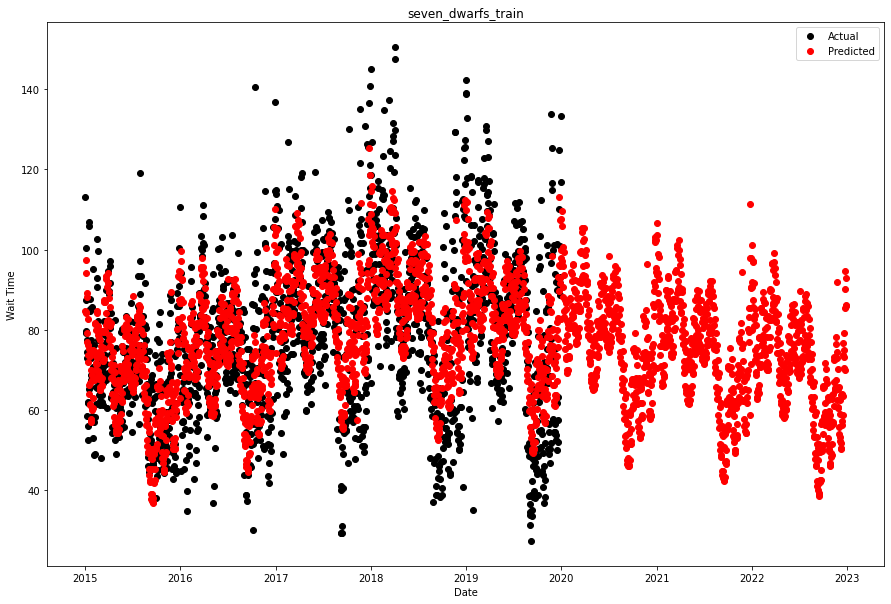

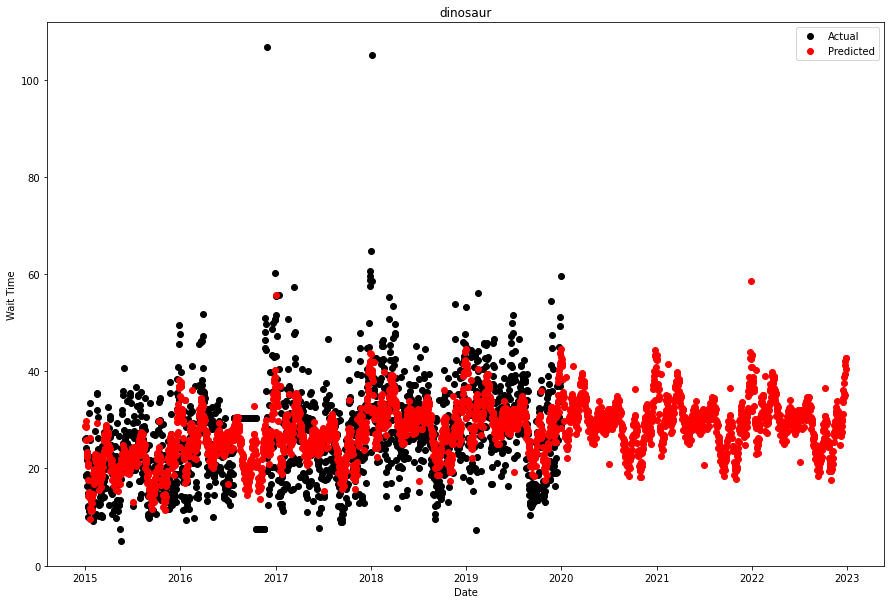

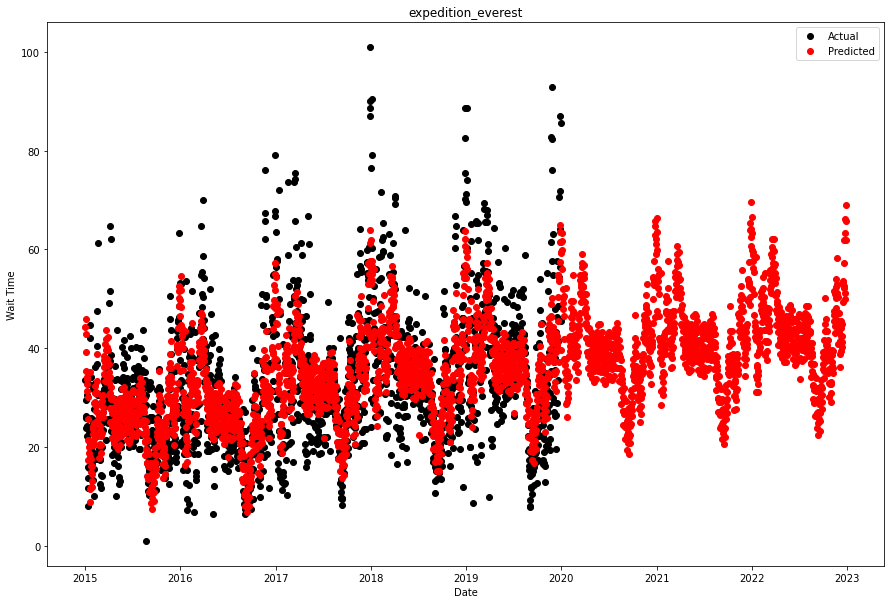

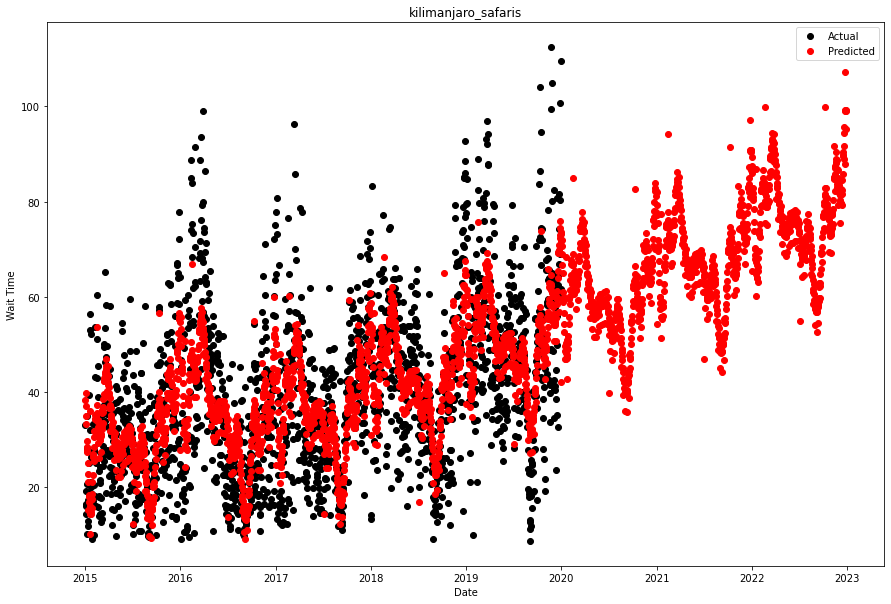

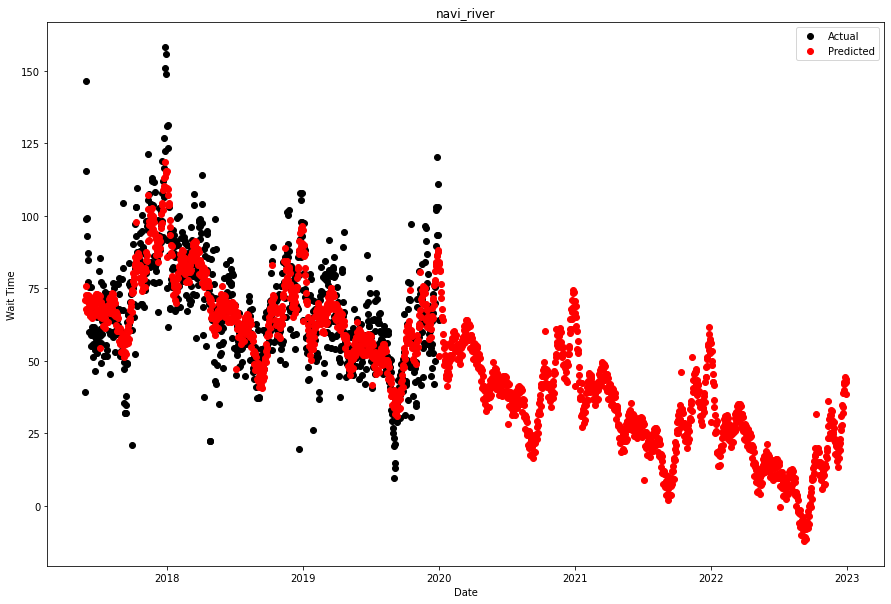

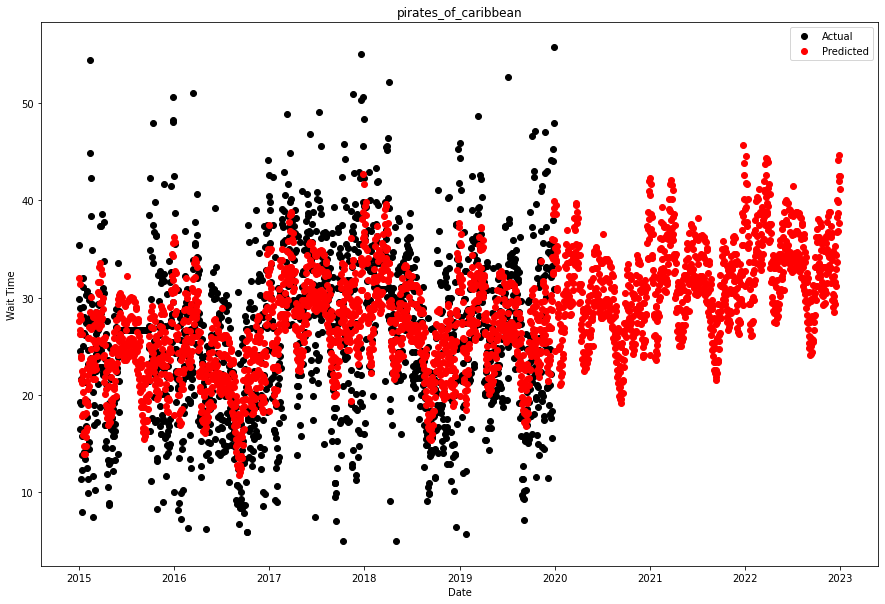

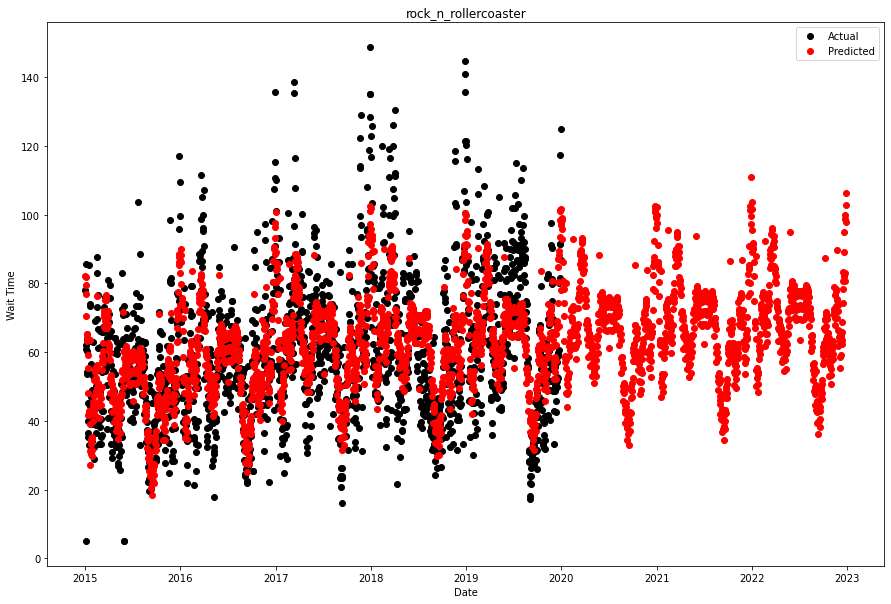

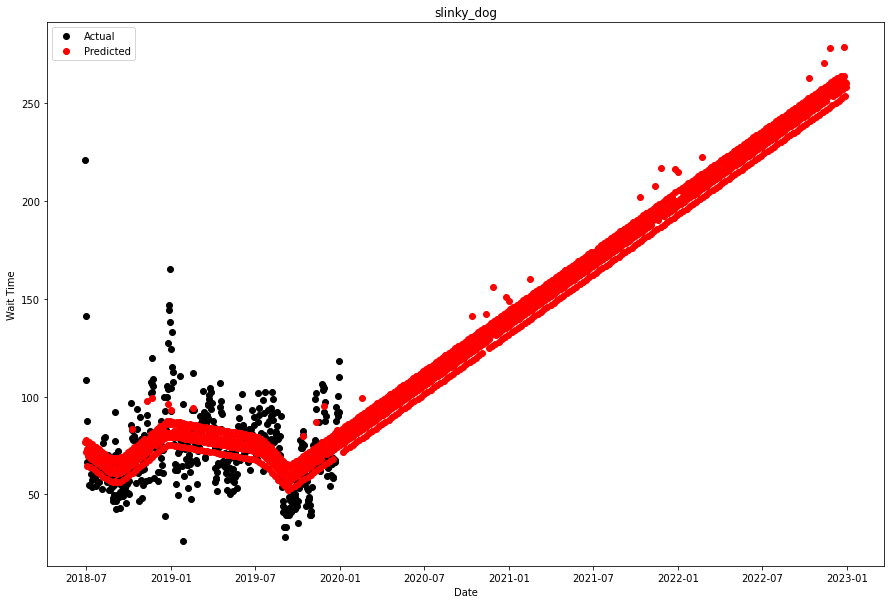

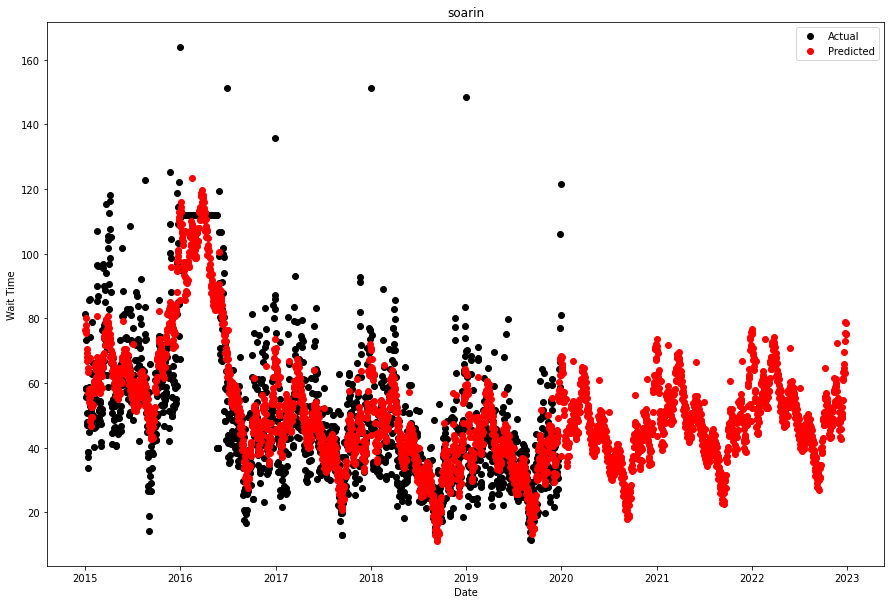

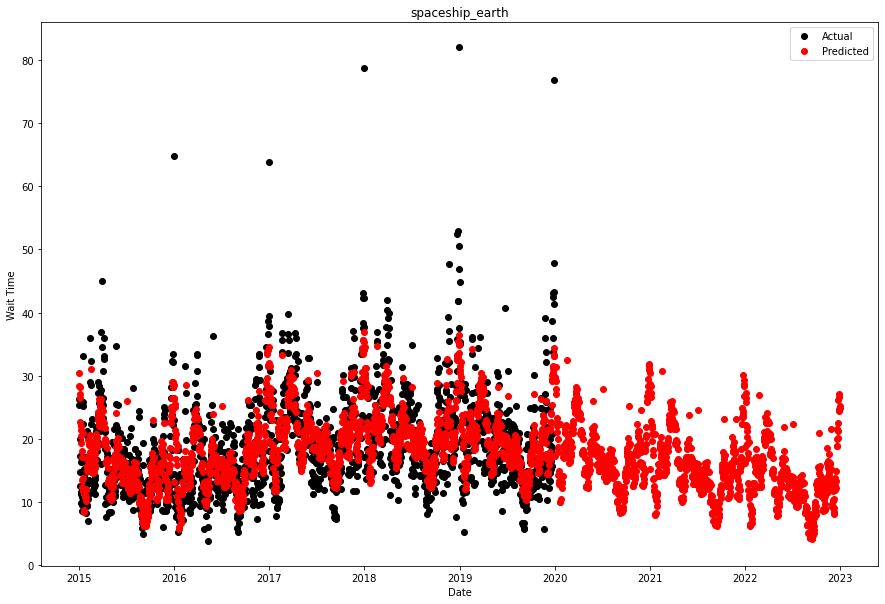

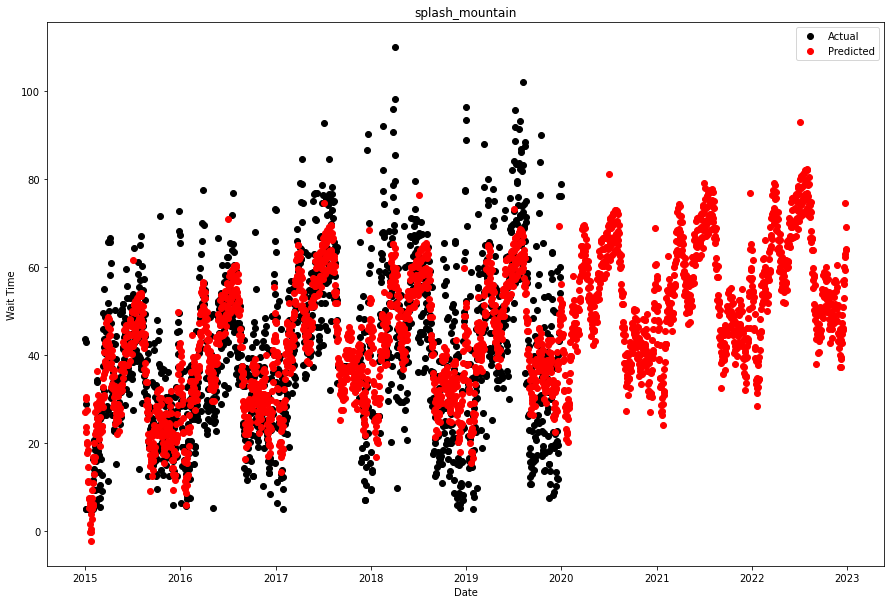

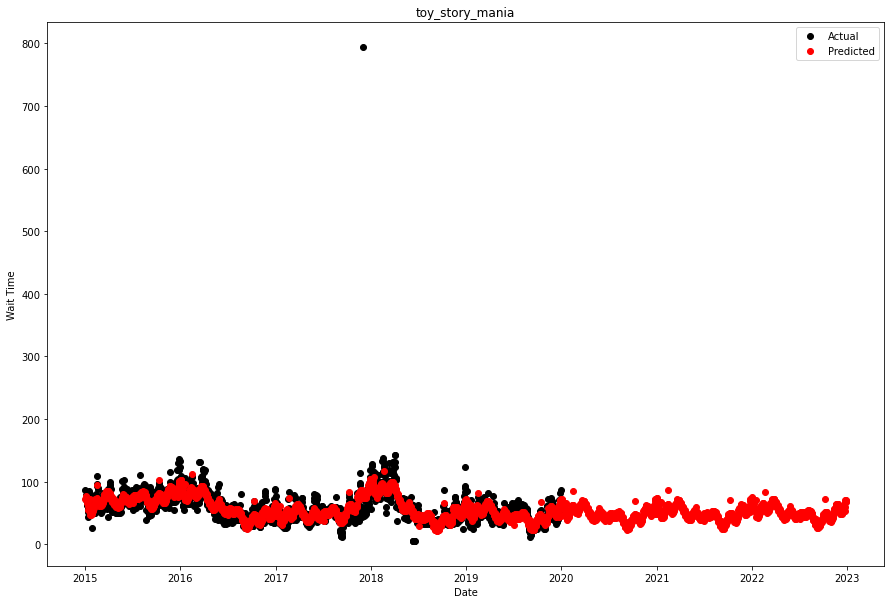

In [44]:
for i in data_sets:
    print(i)
    exec(f'plt.figure(figsize = (15,10))')
    exec(f'plt.plot_date(fb_data_{i}["ds"], fb_data_{i}["y"], color = "black")')
    exec(f'plt.plot_date(preds_{i}["ds"], preds_{i}["yhat"], color = "red")')
    exec(f'plt.xlabel("Date")')
    exec(f'plt.ylabel("Wait Time")')
    exec(f'plt.legend(["Actual", "Predicted"])')
    exec(f'plt.title("{i}")')

In [45]:
# plt.figure(figsize = (15,10))
# plt.plot_date(fb_data["ds"], fb_data["y"], color = "black")
# plt.plot_date(preds["ds"], preds["yhat"], color = "red")
# plt.xlabel("Date")
# plt.ylabel("Wait Time")
# plt.legend(["Actual", "Predicted"])
# plt.title("Dinosaur")

# plt.scatter(fb_data["y"])
# plt.scatter(np.arange(len(fb_data)), fb_data["y"], color = "black")
# plt.scatter(np.arange(len(fb_data), len(fb_data)+ len(preds)), preds["yhat"], color = "red")

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


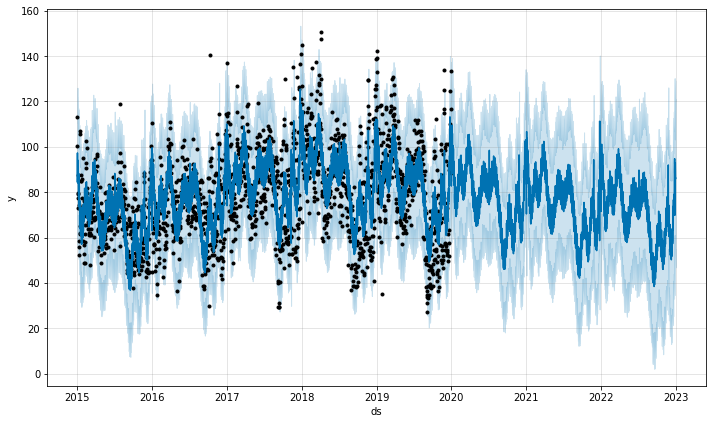

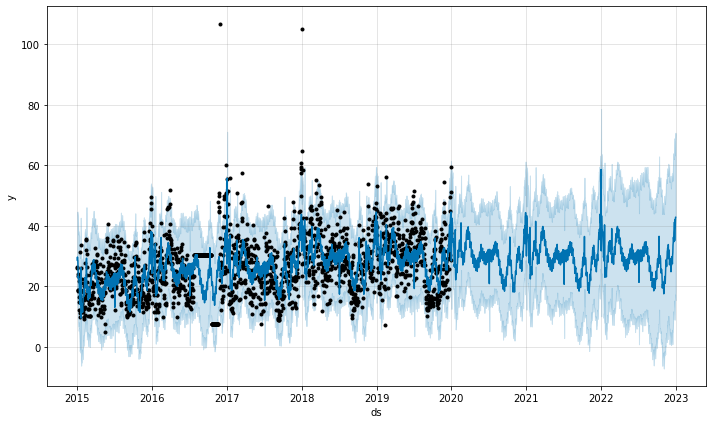

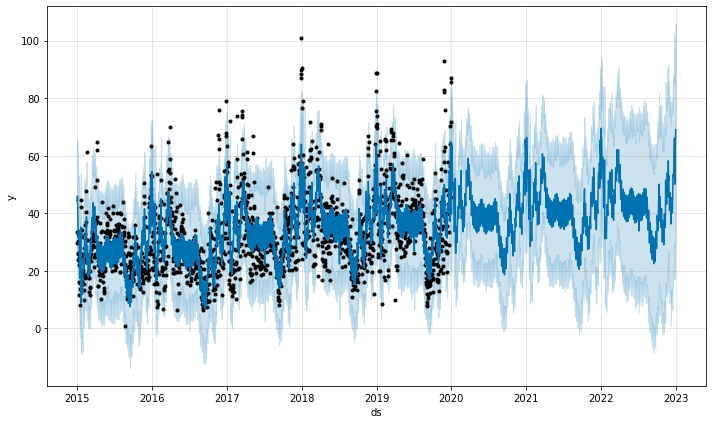

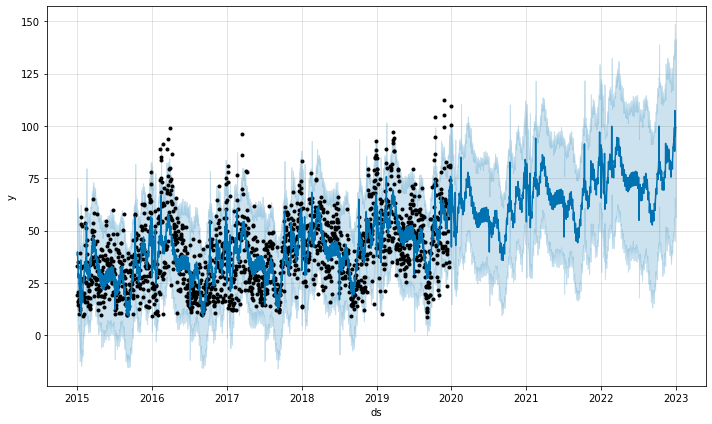

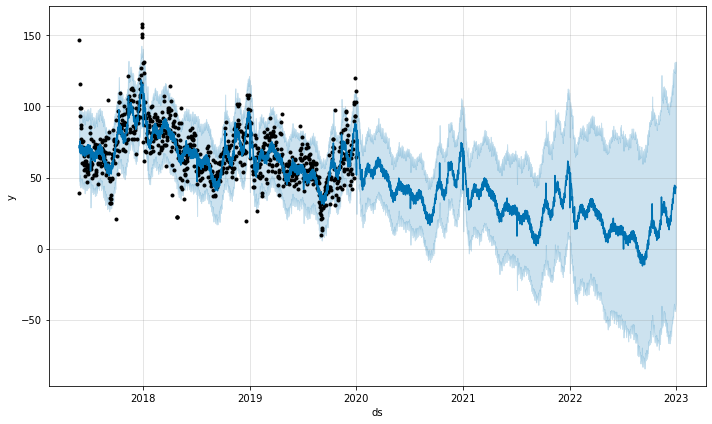

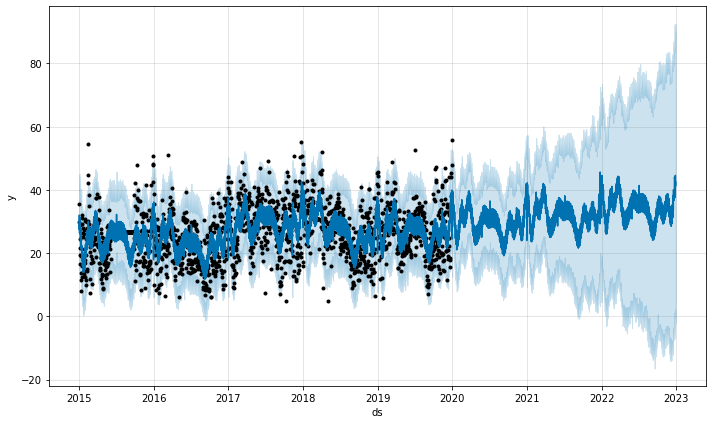

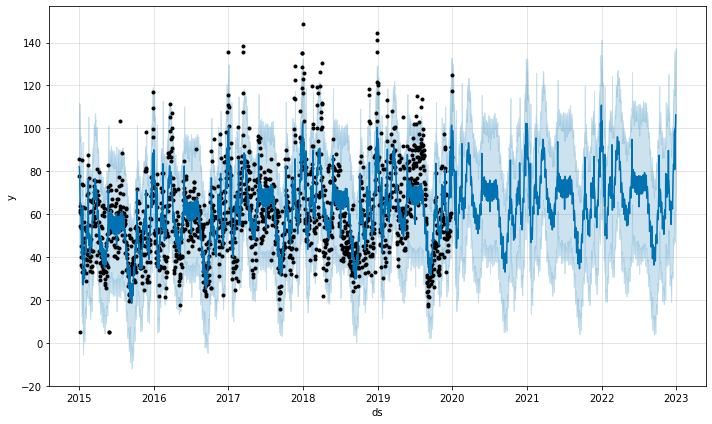

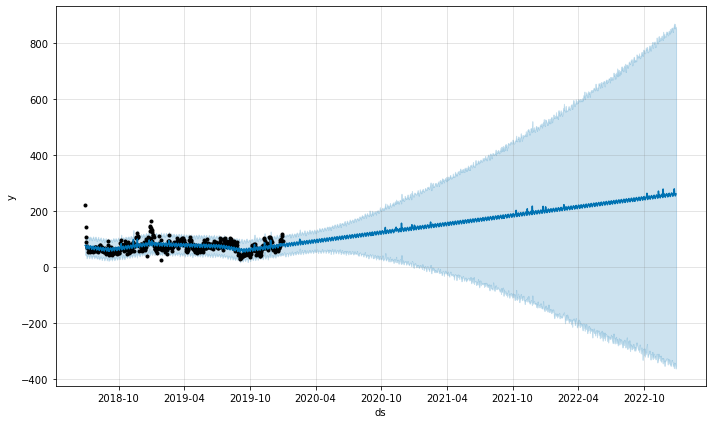

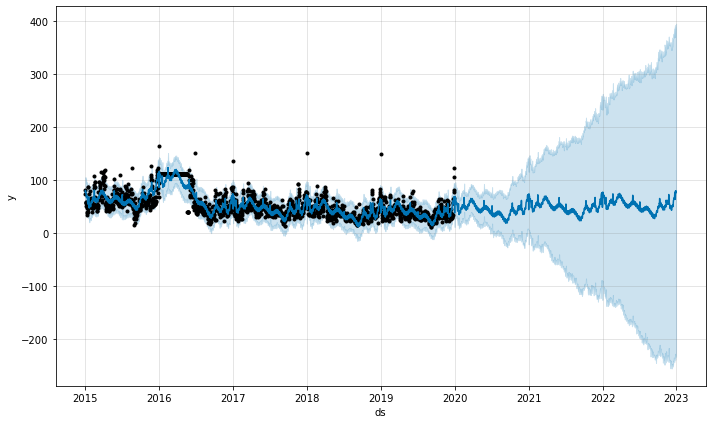

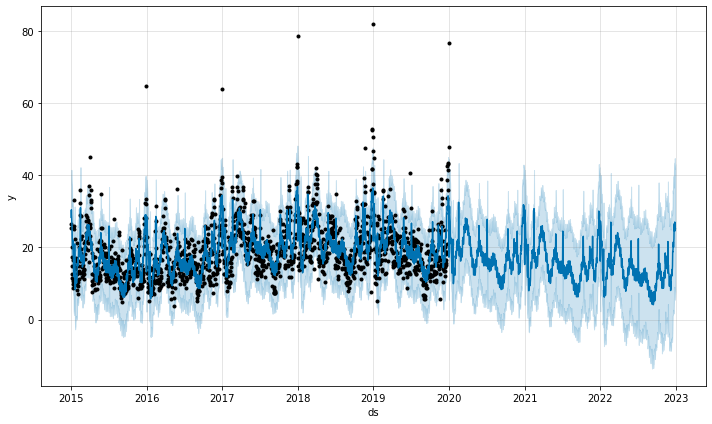

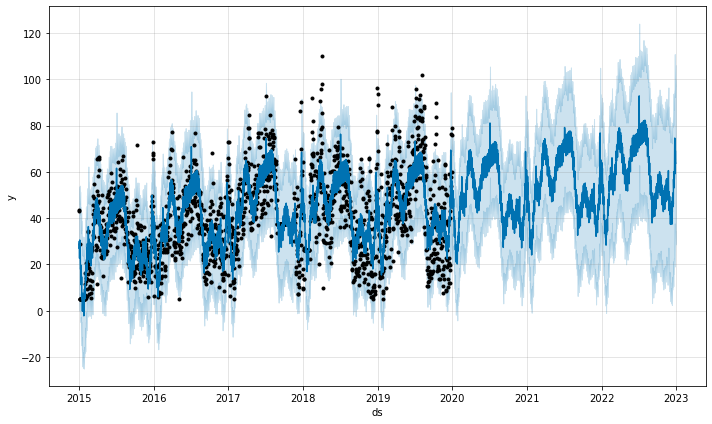

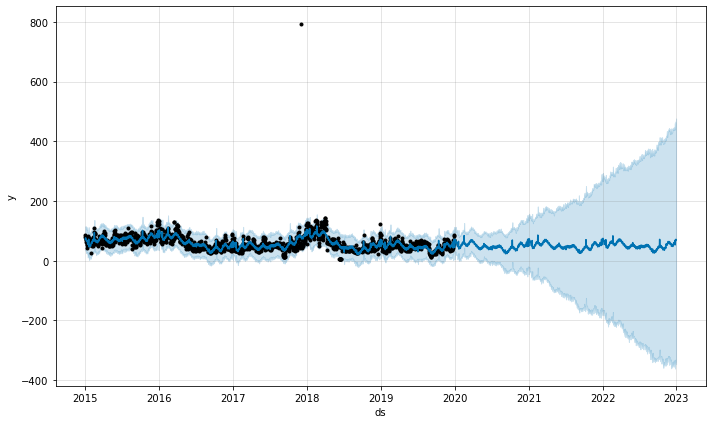

In [60]:
for i in data_sets:
    print(i)
    models[i].plot(preds[i])

seven_dwarfs_train
dinosaur
expedition_everest
kilimanjaro_safaris
navi_river
pirates_of_caribbean
rock_n_rollercoaster
slinky_dog
soarin
spaceship_earth
splash_mountain
toy_story_mania


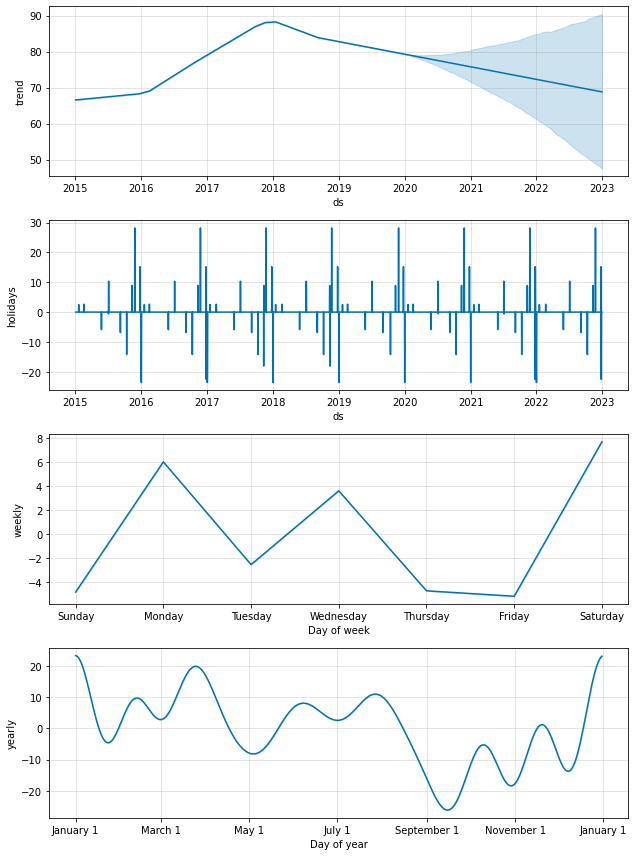

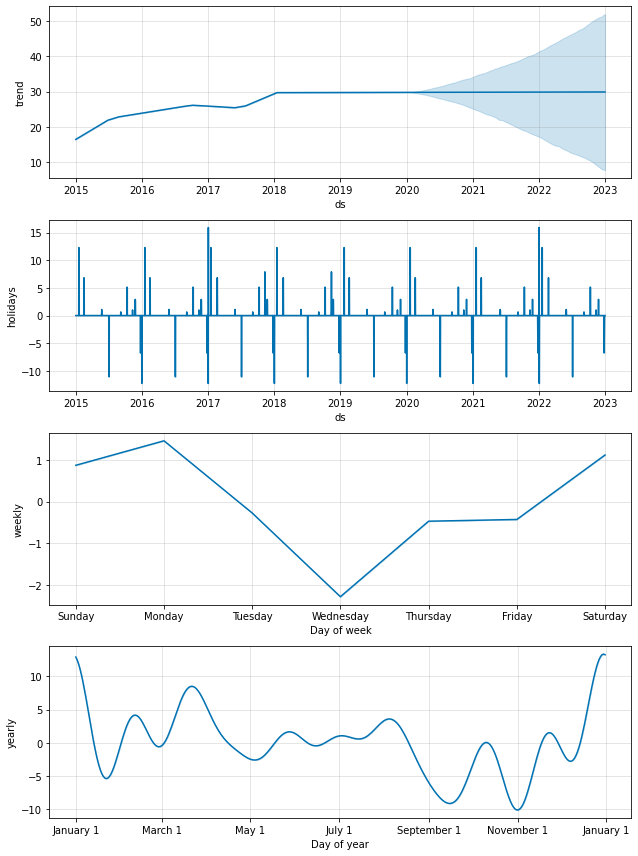

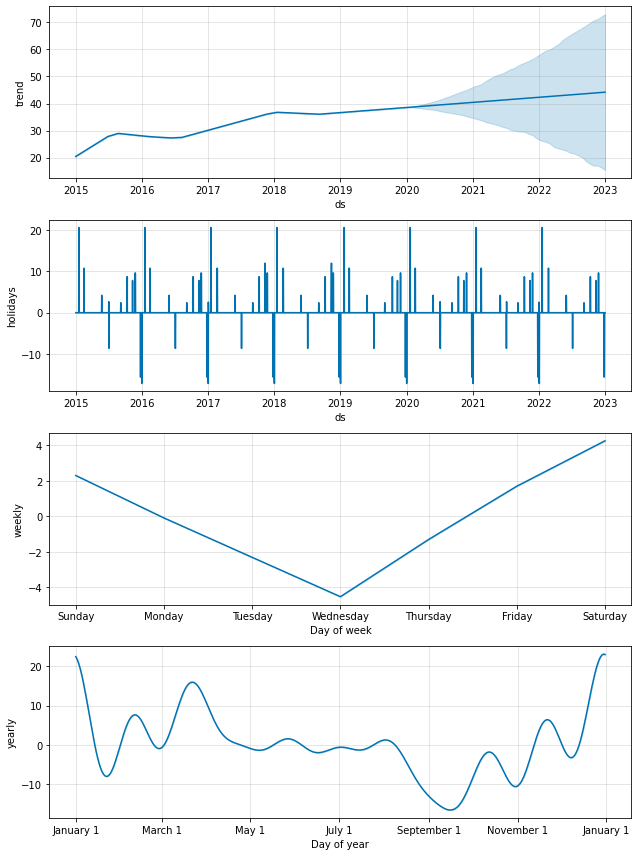

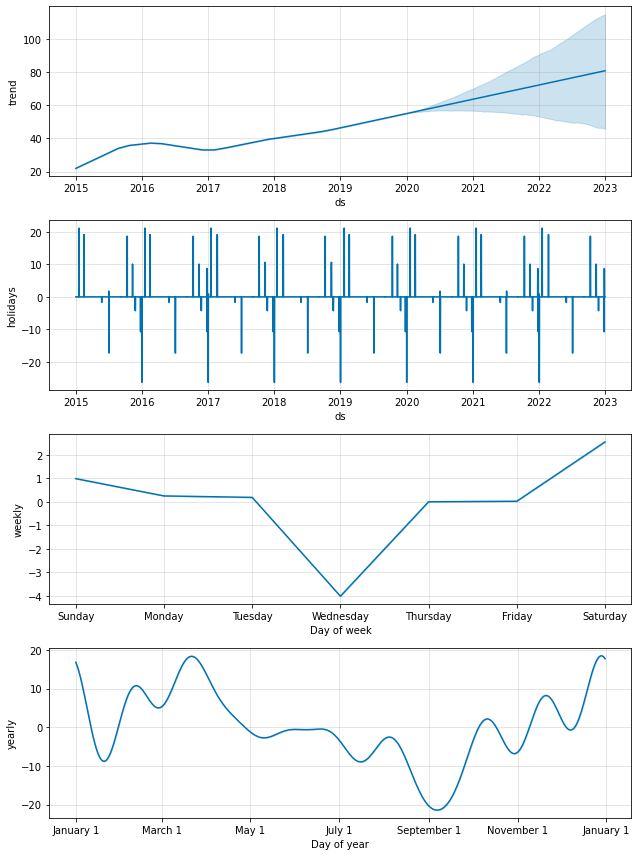

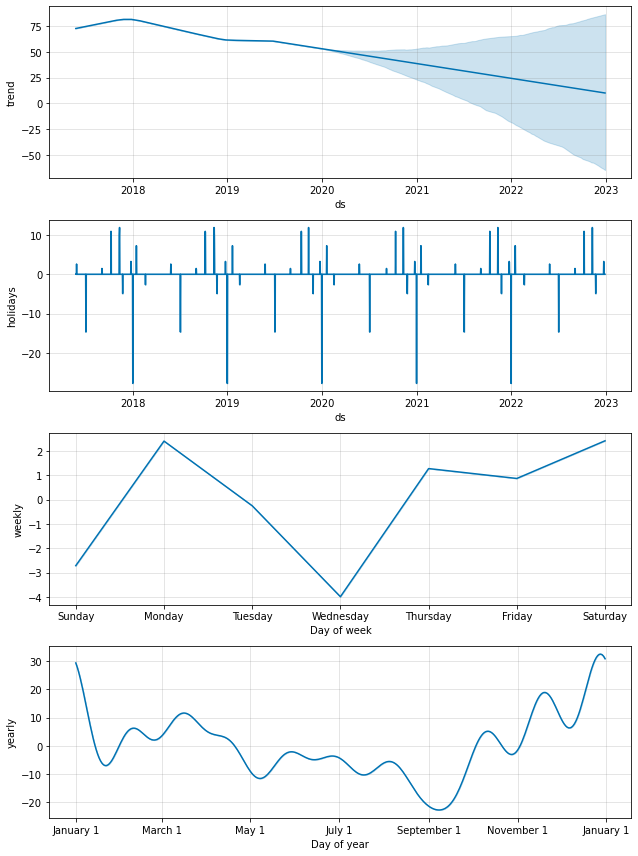

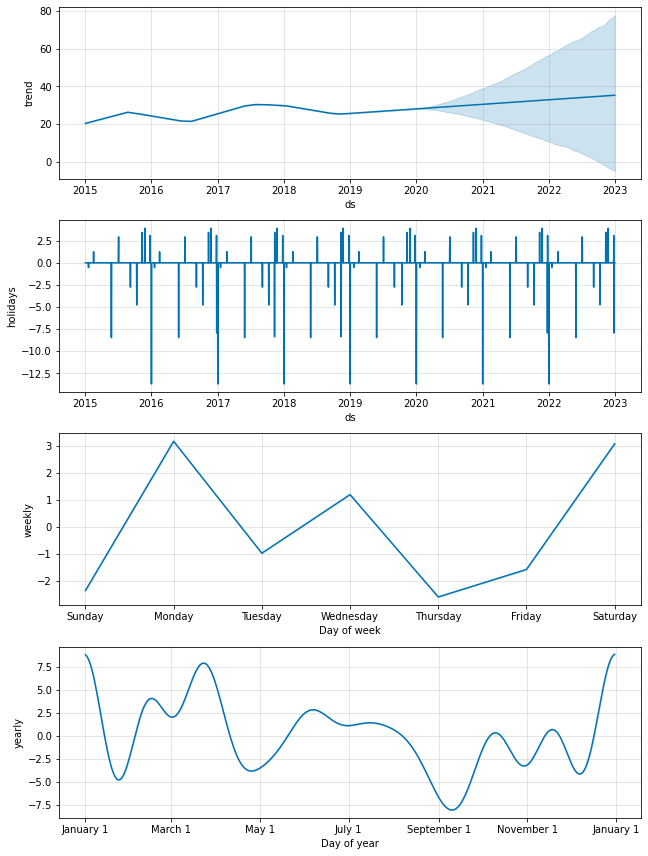

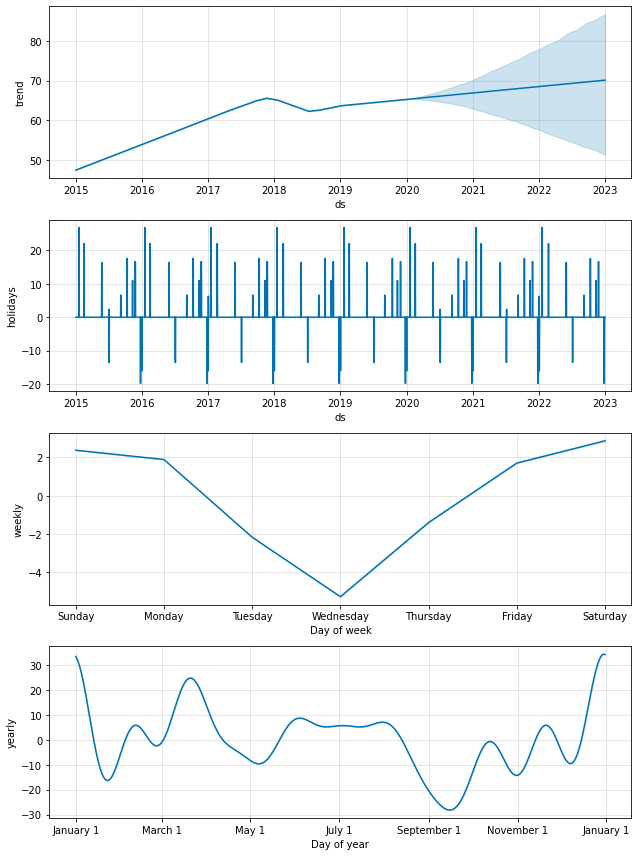

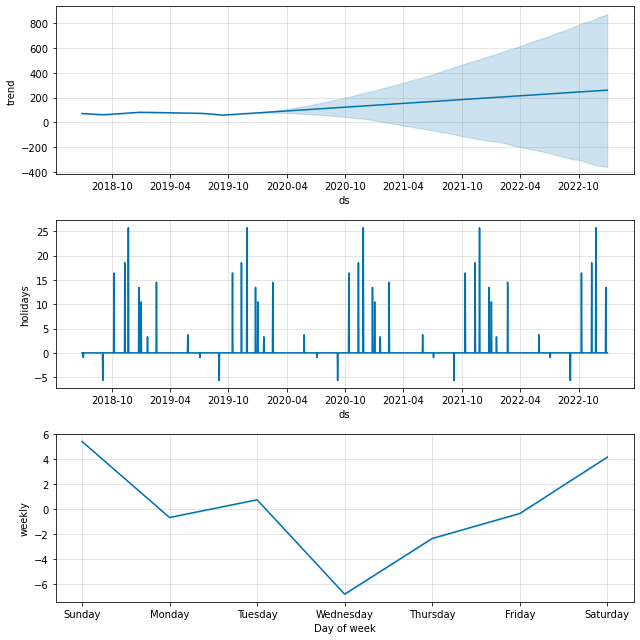

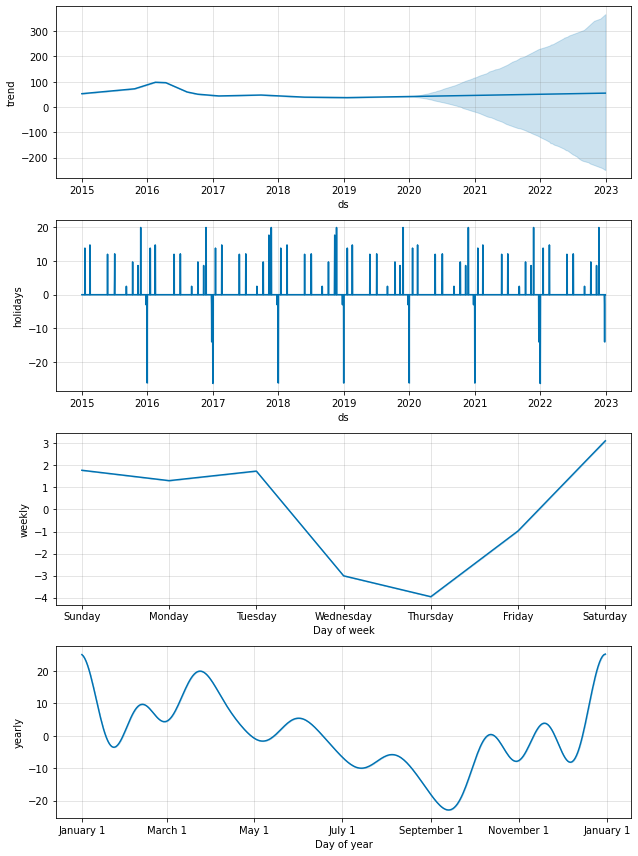

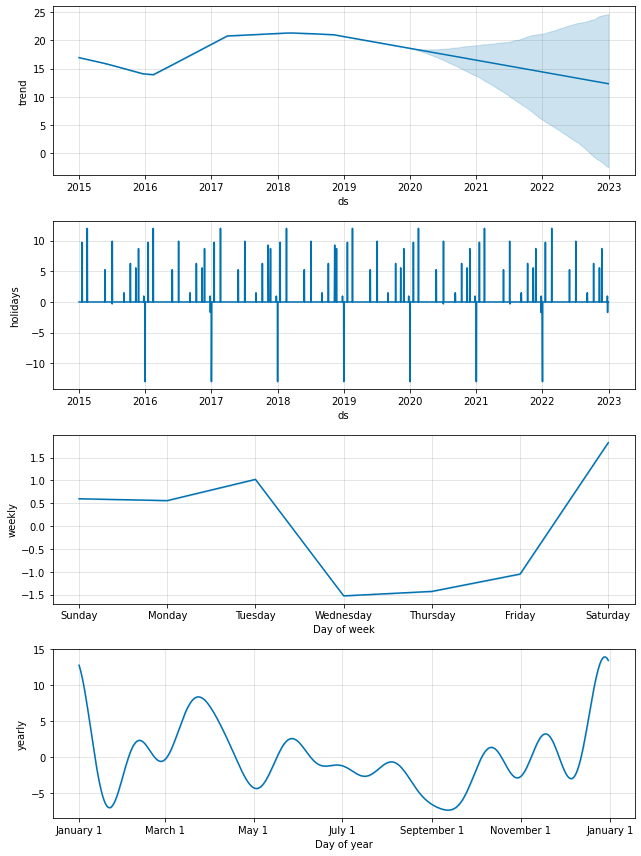

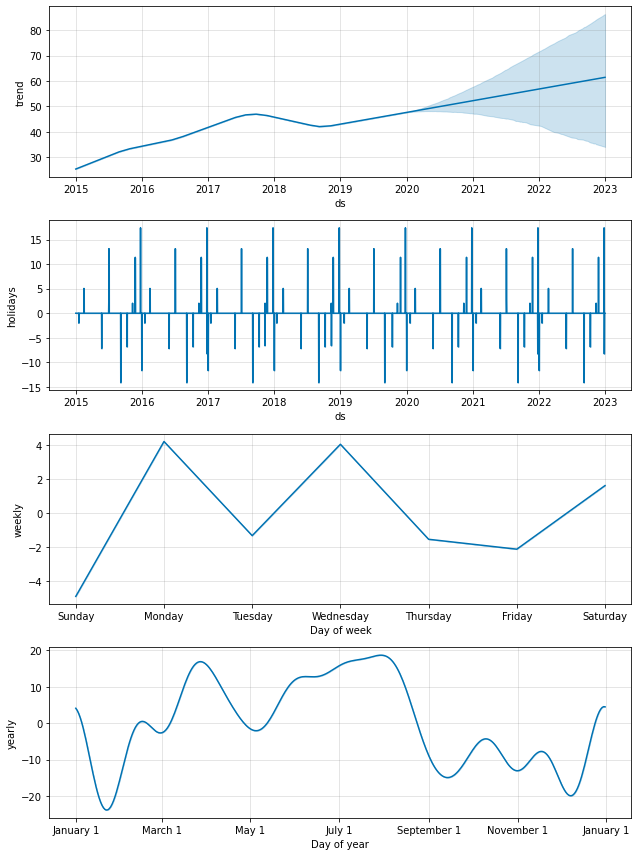

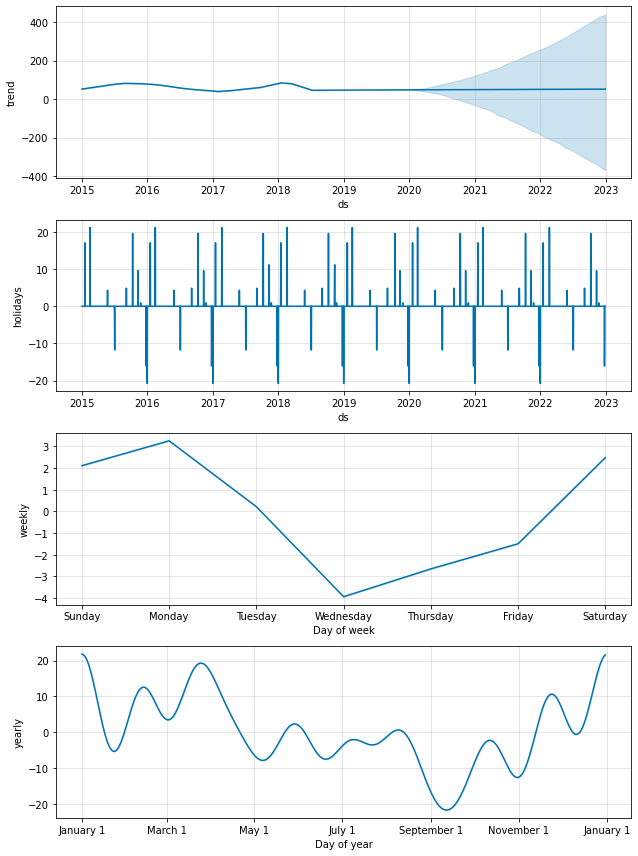

In [47]:
for i in data_sets:
    print(i)
    models[i].plot_components(preds[i])

In [74]:
forecast = {}
for i in data_sets:
    print(i)
    forecast[i] = preds[i].loc[len(data_dict[f"fb_data_{i}"])]
#     forecast_{i} as exec or eval has to become dict forecast = {}
#     then populate with forecast[RIDE_DATA_NAME] = ...
    display(f'forecast[i].loc[forecast[i]["yhat"].idxmin, :]')
    print(f'(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]')

    

seven_dwarfs_train


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
dinosaur


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
expedition_everest


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
kilimanjaro_safaris


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
navi_river


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
pirates_of_caribbean


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
rock_n_rollercoaster


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
slinky_dog


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
soarin


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
spaceship_earth


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
splash_mountain


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]
toy_story_mania


'forecast[i].loc[forecast[i]["yhat"].idxmin, :]'

(forecast[i].nsmallest(10, "yhat")[["ds", "yhat"]]


In [49]:
# forecast = preds.loc[len(fb_data):, :]
# display(forecast.loc[temp["yhat"].idxmin, :])
# print(forecast.nsmallest(10, "yhat")[["ds", "yhat"]])

In [50]:
# from sklearn.neural_network import MLPRegressor

# model = MLPRegressor()
# model.fit(X, y)
# print(model.score(X, y))


In [51]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split

In [52]:
# X = dinosaur_data.drop(columns = ["date", "datetime", "CleanTime"])
# y = dinosaur_data["CleanTime"]

In [53]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# regr = MLPRegressor(random_state=1).fit(X_train, y_train)
# regr.predict(X_test)
                                                    
# regr.score(X_test, y_test)

### Random Forest Model

#### Train Model

In [54]:
# rf_model = RandomForestRegressor()
# rf_model.fit(X_train,y_train)

In [55]:
# y_test_pred=rf_model.predict(X_test)
# test_accuracy=(y_test ==y_test_pred).sum() / len(y_test)
# print('Test Set accuracy: ',test_accuracy)

In [56]:
# rf_model.score(X_test, y_test)

# Best Parks To Go To On A Given Day

In [75]:
parks = {'magic_kingdom': ['seven_dwarfs_train', 'pirates_of_caribbean', 'splash_mountain'], 'animal_kingdom' : ['dinosaur' , 'expedition_everest', 'kilimanjaro_safaris', 'navi_river'], 'epcot' : ['soarin', 'spaceship_earth'], 'hollywood_studios': ['rock_n_rollercoaster', 'toy_story_mania']}


In [58]:
# for i in parks:
#     park1= ride1 + ride2
#     for ride3 to ride n:
#         park1 = park1 + ride i 

In [59]:
for i in parks.keys():
    print(i)
    exec(f'preds_{parks[i][0]}["y"] =  preds_{parks[i][0]}["yhat"]')
    exec(f'preds_{parks[i][1]}["y"] =  preds_{parks[i][1]}["yhat"]')
    exec(f'preds_{parks[i][0]}_ =  preds_{parks[i][0]}[["ds", "y"]]')
    exec(f'preds_{parks[i][1]}_ =  preds_{parks[i][1]}[["ds", "y"]]')
    exec(f"{i}_data = preds_{parks[i][0]}_.merge(preds_{parks[i][1]}_, how= 'inner', on= 'ds')")
    for j in range(2, len(parks[i])):
        exec(f'preds_{parks[i][j]}["y"] =  preds_{parks[i][j]}["yhat"]')
        exec(f'preds_{parks[i][j]}_ =  preds_{parks[i][j]}[["ds", "y"]]')
        exec(f"{i}_data = {i}_data.merge(preds_{parks[i][j]}_, how= 'inner', on= 'ds')")
        
    exec(f"cols = [j for j in {i}_data.columns if 'y' in j]")
    exec(f"{i}_data['y_final'] = np.sum({i}_data[cols], axis= 1)")
    exec(f"x = {i}_data['y_final']")
    cols.append('y_final')
#     exec(f"{i}_data.drop(columns = cols, inplace = True)")
    exec(f"{i}_data['y'] = x")
#     exec(f"{i}_data = {i}_data[['ds', 'y']]")
    display(eval(f'{i}_data.head()'))

magic_kingdom


ds        y_x        y_y           y     y_final
0 2015-01-02  84.722342  27.583842  139.358790  139.358790
1 2015-01-03  97.302348  32.040672  159.430147  159.430147
2 2015-01-04  84.094158  26.278475  133.013409  133.013409
3 2015-01-05  94.082220  31.387934  156.048615  156.048615
4 2015-01-06  84.331212  26.706765  134.727885  134.727885

animal_kingdom


ds        y_x        y_y        y_x        y_y     y_final  \
0 2017-05-26  26.574518  35.984632  34.626634  71.035655  336.442876   
1 2017-05-27  28.184084  38.579921  37.256203  72.859257  353.758928   
2 2017-05-28  27.960991  36.616494  35.784977  67.933351  336.591625   
3 2017-05-29  29.634181  38.391457  33.428653  75.753637  354.415859   
4 2017-05-30  26.757311  31.864048  35.114014  70.549141  328.569030   

            y  
0  336.442876  
1  353.758928  
2  336.591625  
3  354.415859  
4  328.569030

epcot


ds        y_x        y_y     y_final           y
0 2015-01-02  76.487296  28.364315  104.851612  104.851612
1 2015-01-03  80.053184  30.445862  110.499046  110.499046
2 2015-01-04  77.933122  28.280855  106.213977  106.213977
3 2015-01-05  76.434679  27.178901  103.613580  103.613580
4 2015-01-06  75.617743  26.474822  102.092565  102.092565

hollywood_studios


ds        y_x        y_y     y_final           y
0 2015-01-02  82.102777  72.405502  154.508280  154.508280
1 2015-01-03  81.905802  76.237703  158.143505  158.143505
2 2015-01-04  79.637733  75.459402  155.097136  155.097136
3 2015-01-05  76.992639  75.946712  152.939351  152.939351
4 2015-01-06  70.432423  72.008050  142.440473  142.440473

In [60]:
for i in parks.keys(): 
    print(i)
#     display({i}_data.head())
    exec(f"{i}_real_waits = list({i}_data.loc[{i}_data['y'] > 0]['y'])")
    print(eval(f"{i}_real_waits[:5]"))

magic_kingdom
[139.35878963685985, 159.43014684579666, 133.01340930605429, 156.04861464025626, 134.72788510764985]
animal_kingdom
[336.4428763926805, 353.7589277721704, 336.591624771695, 354.41585865512803, 328.5690295670388]
epcot
[104.8516117110566, 110.49904633901505, 106.21397720493597, 103.61358002206342, 102.09256492368272]
hollywood_studios
[154.5082798042022, 158.14350486123556, 155.09713566332204, 152.93935077949936, 142.44047284385303]


In [61]:
# display(fb_data_dinosaur.head())
# dinosaur_real_waits = list(fb_data_dinosaur.loc[fb_data_dinosaur['y'] > 0]['y'])
# print(dinosaur_real_waits[:5])

In [62]:
# mean_= np.mean(dinosaur_real_waits)
# std_= np.std(dinosaur_real_waits)
# print(mean_)
# print(std_)

In [63]:
for i in parks.keys():
    print(i)
    exec(f"mean_{i}= np.mean({i}_real_waits)")
    exec(f"std_{i}= np.std({i}_real_waits)")
    print(eval(f"mean_{i}"))
    print(eval(f"std_{i}"))

magic_kingdom
150.53047648540013
29.604934185095825
animal_kingdom
346.78600862902533
66.72500091668819
epcot
68.55174588248101
20.012702790123992
hollywood_studios
118.1724492054316
24.67706355275282


In [64]:
# PCT = 90
# print(np.quantile(dinosaur_real_waits, 1 - PCT/100))

In [65]:
streamlit_data = datapath.parents[0] /"Streamlit_App"
print(streamlit_data)

/Users/dc/Desktop/Flatiron/projects/Capstone-Disney-World-Date-and-Attendance-Predictor/Streamlit_App


In [66]:
for i in parks.keys():
    print(i)
    std_dev = 1
    exec(f"best_days_{i} = {i}_data.loc[({i}_data['y'] > 0) & ({i}_data['y'] < mean_{i} - std_{i} * std_dev)]")  
    exec(f"best_days_{i}['month'] = best_days_{i}['ds'].apply(lambda x: x.month)")        
    exec(f"best_days_{i}['weekday'] = best_days_{i}['ds'].apply(lambda x: x.weekday())")
    exec(f"best_days_{i}['week'] = best_days_{i}['ds'].apply(lambda x: x.week)")
    display(eval(f"best_days_{i}.head()"))
    exec(f"best_days_{i}.to_csv(streamlit_data / 'best_days_for_{i}.csv', index= False)")

magic_kingdom


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ds        y_x        y_y           y     y_final  month  weekday  \
7  2015-01-09  77.023475  24.012802  118.932062  118.932062      1        4   
9  2015-01-11  73.623239  21.554491  106.525622  106.525622      1        6   
11 2015-01-13  72.015918  21.185789  104.321661  104.321661      1        1   
12 2015-01-14  76.277338  22.491804  113.441846  113.441846      1        2   
13 2015-01-15  66.075680  17.856331   91.313298   91.313298      1        3   

    week  
7      2  
9      2  
11     3  
12     3  
13     3

animal_kingdom


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ds        y_x        y_y        y_x        y_y     y_final  \
39 2017-07-04  15.449562  21.902763  14.401470  54.550626  212.608843   
47 2017-07-12  24.160678  27.870314  24.067085  62.139980  276.476114   
54 2017-07-19  24.402979  28.130705  23.999775  61.207006  275.480930   
82 2017-08-16  24.992694  25.549675  24.978633  62.212262  275.466528   
88 2017-08-22  24.365762  23.882116  23.778618  61.366331  266.785653   

             y  month  weekday  week  
39  212.608843      7        1    27  
47  276.476114      7        2    28  
54  275.480930      7        2    29  
82  275.466528      8        2    33  
88  266.785653      8        1    34

epcot


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ds        y_x        y_y    y_final          y  month  weekday  \
607 2016-08-31  35.457260   9.225946  44.683206  44.683206      8        2   
608 2016-09-01  33.755401   9.214172  42.969573  42.969573      9        3   
609 2016-09-02  35.998206   9.494519  45.492725  45.492725      9        4   
611 2016-09-04  37.333519  10.972358  48.305877  48.305877      9        6   
613 2016-09-06  36.001661  11.261205  47.262866  47.262866      9        1   

     week  
607    35  
608    35  
609    35  
611    35  
613    36

hollywood_studios


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ds        y_x        y_y    y_final          y  month  weekday  \
18 2015-01-20  31.231405  51.342613  82.574018  82.574018      1        1   
19 2015-01-21  27.080502  46.498605  73.579106  73.579106      1        2   
20 2015-01-22  30.306025  47.334898  77.640923  77.640923      1        3   
21 2015-01-23  33.144888  48.293944  81.438831  81.438831      1        4   
22 2015-01-24  34.411029  52.316495  86.727524  86.727524      1        5   

    week  
18     4  
19     4  
20     4  
21     4  
22     4

In [67]:
# std_dev = 1
# best_days = fb_data_dinosaur.loc[(fb_data_dinosaur['y'] > 0) & (fb_data_dinosaur['y'] < mean_ - std_ * std_dev)] 
# best_days['month'] = best_days['ds'].apply(lambda x: x.month)
# best_days['weekday'] = best_days['ds'].apply(lambda x: x.weekday())
# best_days['week'] = best_days['ds'].apply(lambda x: x.week)
# display(best_days.head())

In [68]:
# best_metrics = best_days.groupby(by = ['month', 'week', 'weekday']).count()
# # display(best_metrics.sort_values('y', ascending = False))
# display(best_metrics)

In [69]:
# user_date = '2020-03-25' 
# dt = datetime.strptime(user_date, '%Y-%m-%d')
# month = dt.month
# week = dt.isocalendar()[1]
# day = dt.weekday()
# print(month, week, day)

# try:
#     best_metrics.loc[month, week, day]
#     print(f'{user_date} is a good day to go to the park!')
# except KeyError:
#     print(f'{user_date} is a bad day to go to the park!')

In [70]:
# best_metrics.loc[3, 11, 3]

# Best Day to Ride specific Ride 

### Seven Dwarfs Mine Train (MK) - 3RD WK SEPT - FRIDAY

In [76]:
forecast_seven_dwarfs_train['weekday'] = forecast_seven_dwarfs_train['ds'].apply(lambda x: x.weekday())


NameError: name 'forecast_seven_dwarfs_train' is not defined

Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [72]:
forecast_seven_dwarfs_train.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2814 2022-09-16  38.430561        4
2813 2022-09-15  38.885899        3
2816 2022-09-18  39.209131        6
2809 2022-09-11  40.093646        6
2807 2022-09-09  41.059146        4
2811 2022-09-13  41.488968        1
2820 2022-09-22  41.870326        3
2450 2021-09-17  42.125477        4
2806 2022-09-08  42.299296        3
2821 2022-09-23  42.377015        4

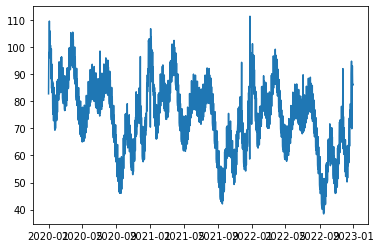

In [73]:
plt.plot(forecast_seven_dwarfs_train["ds"], forecast_seven_dwarfs_train["yhat"])
plt.show()

### Dinosaur Ride (AK) - 3RD WK SEPT - WEDNESDAY

In [74]:
forecast_dinosaur['weekday'] = forecast_dinosaur['ds'].apply(lambda x: x.weekday())

<ipython-input-74-7f2ac7f95dd4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_dinosaur['weekday'] = forecast_dinosaur['ds'].apply(lambda x: x.weekday())


In [75]:
forecast_dinosaur.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2861 2022-11-02  17.569272        2
2497 2021-11-03  17.772216        2
2126 2020-10-28  18.145127        2
2133 2020-11-04  18.155403        2
2084 2020-09-16  18.445562        2
2448 2021-09-15  18.458235        2
2812 2022-09-14  18.541167        2
2490 2021-10-27  18.746462        2
2077 2020-09-09  19.103025        2
2819 2022-09-21  19.272301        2

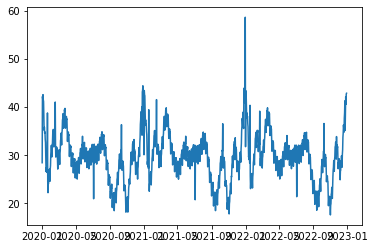

In [76]:
plt.plot(forecast_dinosaur["ds"], forecast_dinosaur["yhat"])
plt.show()

### Expedition Everest (AK) - 3RD WK SEPT - WEDNESDAY

In [77]:
forecast_expedition_everest['weekday'] = forecast_expedition_everest['ds'].apply(lambda x: x.weekday())

<ipython-input-77-22f779c100dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_expedition_everest['weekday'] = forecast_expedition_everest['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [78]:
forecast_expedition_everest.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2084 2020-09-16  18.664785        2
2077 2020-09-09  19.500904        2
2448 2021-09-15  20.540945        2
2091 2020-09-23  20.753206        2
2083 2020-09-15  20.865996        1
2070 2020-09-02  21.591464        2
2441 2021-09-08  21.704576        2
2076 2020-09-08  21.968795        1
2085 2020-09-17  21.969924        3
2455 2021-09-22  21.992273        2

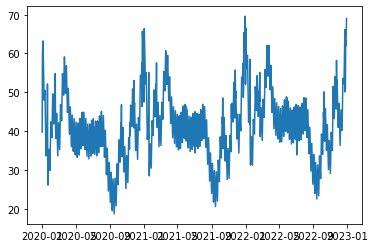

In [79]:
plt.plot(forecast_expedition_everest["ds"], forecast_expedition_everest["yhat"])
plt.show()

### Kilimanjaro Safaris (AK) - 2ND WK SEPT - WEDNESDAY

In [80]:
forecast_kilimanjaro_safaris['weekday'] = forecast_kilimanjaro_safaris['ds'].apply(lambda x: x.weekday())

<ipython-input-80-c290a3484df3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_kilimanjaro_safaris['weekday'] = forecast_kilimanjaro_safaris['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [81]:
forecast_kilimanjaro_safaris.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2077 2020-09-09  35.760363        2
2070 2020-09-02  35.960349        2
2084 2020-09-16  38.810010        2
2063 2020-08-26  39.360684        2
2072 2020-09-04  39.611444        4
2010 2020-07-04  39.742910        5
2071 2020-09-03  39.749535        3
2076 2020-09-08  39.792561        1
2075 2020-09-07  39.829906        0
2078 2020-09-10  40.010321        3

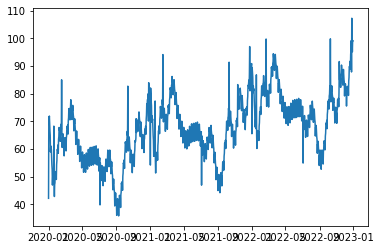

In [82]:
plt.plot(forecast_kilimanjaro_safaris["ds"], forecast_kilimanjaro_safaris["yhat"])
plt.show()

### Navi River Ride (AK) - 2ND WK SEPT - WEDNESDAY

In [83]:
forecast_navi_river['weekday'] = forecast_navi_river['ds'].apply(lambda x: x.weekday())

<ipython-input-83-70926d0dd2fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_navi_river['weekday'] = forecast_navi_river['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [84]:
forecast_navi_river.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
1930 2022-09-07 -12.175012        2
1937 2022-09-14 -11.296860        2
1934 2022-09-11 -10.820428        6
1927 2022-09-04 -10.352755        6
1923 2022-08-31 -10.186967        2
1929 2022-09-06  -8.315019        1
1936 2022-09-13  -7.911154        1
1941 2022-09-18  -7.763881        6
1932 2022-09-09  -7.409818        4
1920 2022-08-28  -7.322443        6

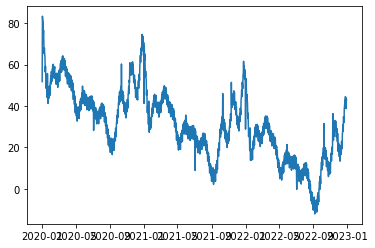

In [85]:
plt.plot(forecast_navi_river["ds"], forecast_navi_river["yhat"])
plt.show()

### Pirates of the Caribbean (MK) - 2ND WK SEPT - THURSDAY

In [86]:
forecast_pirates_of_caribbean['weekday'] = forecast_pirates_of_caribbean['ds'].apply(lambda x: x.weekday())

<ipython-input-86-8bf8791992d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_pirates_of_caribbean['weekday'] = forecast_pirates_of_caribbean['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [87]:
forecast_pirates_of_caribbean.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2078 2020-09-10  19.158674        3
2081 2020-09-13  19.611780        6
2074 2020-09-06  19.637738        6
2071 2020-09-03  19.922282        3
2079 2020-09-11  20.211296        4
2085 2020-09-17  20.213821        3
2072 2020-09-04  20.740737        4
2076 2020-09-08  20.832001        1
1847 2020-01-23  21.048391        3
2067 2020-08-30  21.182195        6

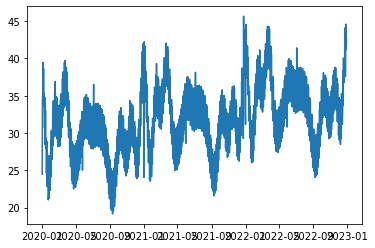

In [88]:
plt.plot(forecast_pirates_of_caribbean["ds"], forecast_pirates_of_caribbean["yhat"])
plt.show()

### Rock n' Roller Coaster (HS) - 3RD WK SEPT - WEDNESDAY

In [89]:
forecast_rock_n_rollercoaster['weekday'] = forecast_rock_n_rollercoaster['ds'].apply(lambda x: x.weekday())

<ipython-input-89-cc38e587714e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_rock_n_rollercoaster['weekday'] = forecast_rock_n_rollercoaster['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [90]:
forecast_rock_n_rollercoaster.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2084 2020-09-16  33.000249        2
2448 2021-09-15  34.551445        2
2077 2020-09-09  34.558290        2
2083 2020-09-15  36.037068        1
2812 2022-09-14  36.275662        2
2441 2021-09-08  36.859484        2
2085 2020-09-17  37.071613        3
2091 2020-09-23  37.154550        2
2455 2021-09-22  37.547251        2
2447 2021-09-14  37.728018        1

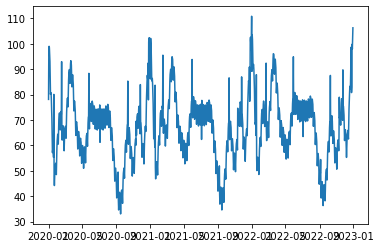

In [91]:
plt.plot(forecast_rock_n_rollercoaster["ds"], forecast_rock_n_rollercoaster["yhat"])
plt.show()

### Slinky Dog Ride (HS) - 2ND WK JAN -WEDNESDAY

In [92]:
forecast_slinky_dog['weekday'] = forecast_slinky_dog['ds'].apply(lambda x: x.weekday())

<ipython-input-92-8622a1528ff9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_slinky_dog['weekday'] = forecast_slinky_dog['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [93]:
forecast_slinky_dog.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
557 2020-01-08  71.857510        2
564 2020-01-15  73.031015        2
571 2020-01-22  74.204520        2
551 2020-01-02  75.313044        3
578 2020-01-29  75.378025        2
558 2020-01-09  76.486549        3
585 2020-02-05  76.551530        2
552 2020-01-03  77.480645        4
565 2020-01-16  77.660054        3
555 2020-01-06  77.664026        0

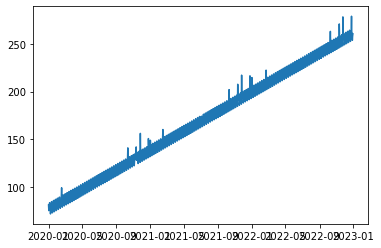

In [94]:
plt.plot(forecast_slinky_dog["ds"], forecast_slinky_dog["yhat"])
plt.show()

### Soarin (EC) - 2ND WK SEPT - THURSDAY

In [95]:
forecast_soarin['weekday'] = forecast_soarin['ds'].apply(lambda x: x.weekday())

<ipython-input-95-b42632e8106a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_soarin['weekday'] = forecast_soarin['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [96]:
forecast_soarin.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2078 2020-09-10  18.058703        3
2085 2020-09-17  18.696056        3
2077 2020-09-09  19.256018        2
2084 2020-09-16  19.256761        2
2079 2020-09-11  20.862819        4
2071 2020-09-03  20.905155        3
2086 2020-09-18  22.172997        4
2070 2020-09-02  22.406433        2
2449 2021-09-16  22.711879        3
2442 2021-09-09  22.863953        3

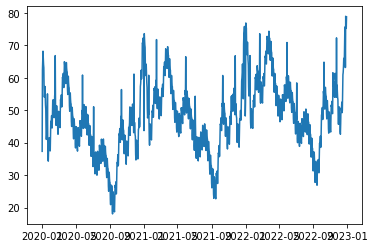

In [97]:
plt.plot(forecast_soarin["ds"], forecast_soarin["yhat"])
plt.show()

### Spaceship Earth (EC) - 2ND WK SEPT - WEDNESDAY

In [98]:
forecast_spaceship_earth['weekday'] = forecast_spaceship_earth['ds'].apply(lambda x: x.weekday())

<ipython-input-98-87a25675eb86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_spaceship_earth['weekday'] = forecast_spaceship_earth['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [99]:
forecast_spaceship_earth.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds      yhat  weekday
2812 2022-09-14  4.129448        2
2813 2022-09-15  4.279117        3
2805 2022-09-07  4.330193        2
2806 2022-09-08  4.356068        3
2807 2022-09-09  4.674538        4
2814 2022-09-16  4.739273        4
2799 2022-09-01  5.048945        3
2798 2022-08-31  5.088967        2
2819 2022-09-21  5.183575        2
2800 2022-09-02  5.301569        4

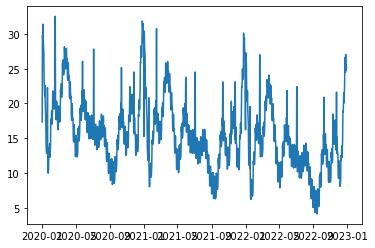

In [100]:
plt.plot(forecast_spaceship_earth["ds"], forecast_spaceship_earth["yhat"])
plt.show()

### Splash Mountain (MK) - 4TH WK JAN - SUNDAY

In [101]:
forecast_splash_mountain['weekday'] = forecast_splash_mountain['ds'].apply(lambda x: x.weekday())

<ipython-input-101-484b5bbd05bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_splash_mountain['weekday'] = forecast_splash_mountain['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [102]:
forecast_splash_mountain.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
1850 2020-01-26  20.217468        6
1843 2020-01-19  21.077201        6
1848 2020-01-24  22.014193        4
1847 2020-01-23  22.466247        3
1845 2020-01-21  23.170670        1
2214 2021-01-24  24.106379        6
1852 2020-01-28  25.618962        1
1849 2020-01-25  26.121755        5
1841 2020-01-17  26.218040        4
2212 2021-01-22  26.498796        4

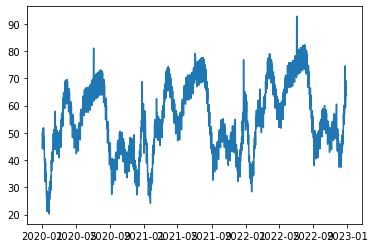

In [103]:
plt.plot(forecast_splash_mountain["ds"], forecast_splash_mountain["yhat"])
plt.show()

### Toy Story Mania (HS) - 2ND WK SEPT - WEDNESDAY

In [104]:
forecast_toy_story_mania['weekday'] = forecast_toy_story_mania['ds'].apply(lambda x: x.weekday())

<ipython-input-104-1aa3a8dea33a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_toy_story_mania['weekday'] = forecast_toy_story_mania['ds'].apply(lambda x: x.weekday())


Day of Week:
<br>
<br>
0: Monday
<br>
1: Tuesday
<br>
2: Wednesday
<br>
3: Thursday
<br>
4: Friday
<br>
5: Saturday
<br>
6: Sunday


In [105]:
forecast_toy_story_mania.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2077 2020-09-09  23.416194        2
2084 2020-09-16  24.153537        2
2078 2020-09-10  24.543594        3
2448 2021-09-15  24.934412        2
2441 2021-09-08  24.957685        2
2079 2020-09-11  25.634636        4
2812 2022-09-14  25.847588        2
2085 2020-09-17  25.883829        3
2442 2021-09-09  25.975847        3
2449 2021-09-16  26.561537        3

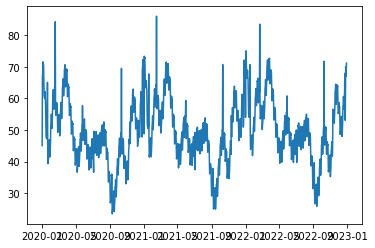

In [106]:
plt.plot(forecast_toy_story_mania["ds"], forecast_toy_story_mania["yhat"])
plt.show()

# Best Time of Year to go to Park with Kids

### Magic Kingdom - 2ND WK SEPT - THURSDAY

Pirates of the Caribbean

In [107]:
forecast_pirates_of_caribbean.nsmallest(5, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2078 2020-09-10  19.158674        3
2081 2020-09-13  19.611780        6
2074 2020-09-06  19.637738        6
2071 2020-09-03  19.922282        3
2079 2020-09-11  20.211296        4

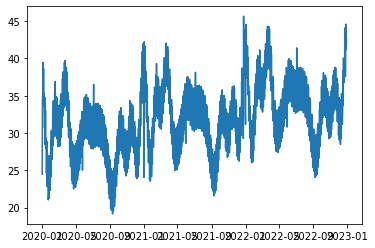

In [108]:
plt.plot(forecast_pirates_of_caribbean["ds"], forecast_pirates_of_caribbean["yhat"])
plt.show()

### Epcot - 2ND WK SEPT - WEDNESDAY

Spaceship Earth

In [109]:
forecast_spaceship_earth.nsmallest(10, "yhat")[["ds", "yhat", "weekday"]]

ds      yhat  weekday
2812 2022-09-14  4.129448        2
2813 2022-09-15  4.279117        3
2805 2022-09-07  4.330193        2
2806 2022-09-08  4.356068        3
2807 2022-09-09  4.674538        4
2814 2022-09-16  4.739273        4
2799 2022-09-01  5.048945        3
2798 2022-08-31  5.088967        2
2819 2022-09-21  5.183575        2
2800 2022-09-02  5.301569        4

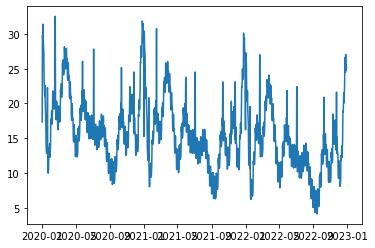

In [110]:
plt.plot(forecast_spaceship_earth["ds"], forecast_spaceship_earth["yhat"])
plt.show()

### Hollywood Studios - 2ND WK SEPT - WEDNESDAY

Toy Story Mania

In [111]:
forecast_toy_story_mania.nsmallest(5, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2077 2020-09-09  23.416194        2
2084 2020-09-16  24.153537        2
2078 2020-09-10  24.543594        3
2448 2021-09-15  24.934412        2
2441 2021-09-08  24.957685        2

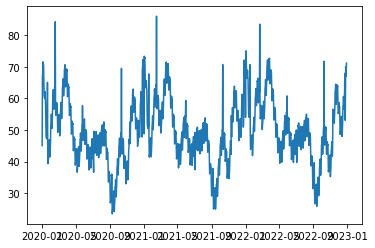

In [112]:
plt.plot(forecast_toy_story_mania["ds"], forecast_toy_story_mania["yhat"])
plt.show()

### Animal Kingdom - 2ND WK SEPT - WEDNESDAY

Dinosaur, Kilimajaro Safari, Navi River

In [113]:
ak_child_dinosaur = forecast_dinosaur[["ds", "yhat", "weekday"]]
ak_child_kilimanjaro = forecast_kilimanjaro_safaris[["ds", "yhat", "weekday"]]
ak_child_navi = forecast_navi_river[["ds", "yhat", "weekday"]]

In [114]:
ak_child_1 = ak_child_dinosaur.merge(ak_child_kilimanjaro, on='ds')
ak_child_1

ds     yhat_x  weekday_x      yhat_y  weekday_y
0    2020-01-01  28.411939          2   42.127987          2
1    2020-01-02  42.147630          3   71.636819          3
2    2020-01-03  41.674599          4   70.624037          4
3    2020-01-04  42.550436          5   71.910449          5
4    2020-01-05  41.484862          6   68.936184          6
5    2020-01-06  41.125167          0   66.635108          0
6    2020-01-07  38.331058          1   64.886211          1
7    2020-01-08  35.170659          2   58.909517          2
8    2020-01-09  35.766258          3   61.094515          3
9    2020-01-10  34.545962          4   59.267223          4
10   2020-01-11  34.813397          5   59.957080          5
11   2020-01-12  33.290393          6   56.617234          6
12   2020-01-13  32.632849          0   54.189337          0
13   2020-01-14  29.705382          1   52.554762          1
14   2020-01-15  26.577231          2   46.930470          2
15   2020-01-16  27.368005          3   49.697528          3
16   2020-01-17  26.499421          4   48.668405          4
17   2020-01-18  27.265189          5   50.354204          5
18   2020-01-19  26.373968          6   48.185414          6
19   2020-01-20  38.746919          0   68.264014          0
20   2020-01-21  24.386028          1   46.881615          1
21   2020-01-22  22.183989          2   42.783512          2
22   2020-01-23  23.956964          3   47.130517          3
23   2020-01-24  24.103628          4   47.700797          4
24   2020-01-25  25.894279          5   50.971180          5
25   2020-01-26  26.014367          6   50.338725          6
26   2020-01-27  27.081262          0   50.686865          0
27   2020-01-28  25.919866          1   51.838017          1
28   2020-01-29  24.559488          2   48.950839          2
29   2020-01-30  27.080560          3   54.350126          3
30   2020-01-31  27.867315          4   55.795396          4
31   2020-02-01  30.178557          5   59.749340          5
32   2020-02-02  30.691429          6   59.599651          6
33   2020-02-03  32.018326          0   60.225320          0
34   2020-02-04  30.982578          1   61.449269          1
35   2020-02-05  29.615294          2   58.435506          2
36   2020-02-06  32.001976          3   63.518803          3
37   2020-02-07  32.535000          4   64.472953          4
38   2020-02-08  34.484127          5   67.778789          5
39   2020-02-09  34.539927          6   66.845488          6
40   2020-02-10  35.330313          0   66.576272          0
41   2020-02-11  33.695774          1   66.820385          1
42   2020-02-12  31.685754          2   62.769555          2
43   2020-02-13  33.404765          3   66.786949          3
44   2020-02-14  33.264370          4   66.674711          4
45   2020-02-15  34.553185          5   68.941267          5
46   2020-02-16  33.979834          6   67.021961          6
47   2020-02-17  41.014384          0   85.025088          0
48   2020-02-18  32.036360          1   65.278498          1
49   2020-02-19  29.584387          2   60.535197          2
50   2020-02-20  30.948381          3   63.992286          3
51   2020-02-21  30.548113          4   63.463008          4
52   2020-02-22  31.677685          5   65.462902          5
53   2020-02-23  31.048402          6   63.430349          6
54   2020-02-24  31.304828          0   62.291657          0
55   2020-02-25  29.299685          1   61.912603          1
56   2020-02-26  27.090000          2   57.494627          2
57   2020-02-27  28.783122          3   61.403711          3
58   2020-02-28  28.788731          4   61.437998          4
59   2020-02-29  30.388999          5   64.095378          5
60   2020-03-01  30.281799          6   62.794535          6
61   2020-03-02  31.097162          0   62.440603          0
62   2020-03-03  29.672572          1   62.877277          1
63   2020-03-04  28.049532          2   59.283602          2
64   2020-03-05  30.319992          3   64.00343

In [115]:
ak_child_2 = ak_child_1.merge(ak_child_navi, on='ds')
ak_child_2

ds     yhat_x  weekday_x      yhat_y  weekday_y       yhat  \
0    2020-01-01  28.411939          2   42.127987          2  51.744645   
1    2020-01-02  42.147630          3   71.636819          3  83.345682   
2    2020-01-03  41.674599          4   70.624037          4  81.311454   
3    2020-01-04  42.550436          5   71.910449          5  80.978772   
4    2020-01-05  41.484862          6   68.936184          6  73.761440   
5    2020-01-06  41.125167          0   66.635108          0  76.596541   
6    2020-01-07  38.331058          1   64.886211          1  71.526126   
7    2020-01-08  35.170659          2   58.909517          2  65.280786   
8    2020-01-09  35.766258          3   61.094515          3  67.968305   
9    2020-01-10  34.545962          4   59.267223          4  64.983373   
10   2020-01-11  34.813397          5   59.957080          5  63.982629   
11   2020-01-12  33.290393          6   56.617234          6  56.390202   
12   2020-01-13  32.632849          0   54.189337          0  59.146767   
13   2020-01-14  29.705382          1   52.554762          1  54.291214   
14   2020-01-15  26.577231          2   46.930470          2  48.544380   
15   2020-01-16  27.368005          3   49.697528          3  51.998012   
16   2020-01-17  26.499421          4   48.668405          4  50.024961   
17   2020-01-18  27.265189          5   50.354204          5  50.254829   
18   2020-01-19  26.373968          6   48.185414          6  44.080247   
19   2020-01-20  38.746919          0   68.264014          0  55.649461   
20   2020-01-21  24.386028          1   46.881615          1  45.235440   
21   2020-01-22  22.183989          2   42.783512          2  41.247542   
22   2020-01-23  23.956964          3   47.130517          3  46.494515   
23   2020-01-24  24.103628          4   47.700797          4  46.309175   
24   2020-01-25  25.894279          5   50.971180          5  48.282346   
25   2020-01-26  26.014367          6   50.338725          6  43.770064   
26   2020-01-27  27.081262          0   50.686865          0  49.644332   
27   2020-01-28  25.919866          1   51.838017          1  47.876478   
28   2020-01-29  24.559488          2   48.950839          2  45.122512   
29   2020-01-30  27.080560          3   54.350126          3  51.413622   
30   2020-01-31  27.867315          4   55.795396          4  52.067756   
31   2020-02-01  30.178557          5   59.749340          5  54.666496   
32   2020-02-02  30.691429          6   59.599651          6  50.562357   
33   2020-02-03  32.018326          0   60.225320          0  56.629474   
34   2020-02-04  30.982578          1   61.449269          1  54.846750   
35   2020-02-05  29.615294          2   58.435506          2  51.882866   
36   2020-02-06  32.001976          3   63.518803          3  57.786293   
37   2020-02-07  32.535000          4   64.472953          4  57.896291   
38   2020-02-08  34.484127          5   67.778789          5  59.819093   
39   2020-02-09  34.539927          6   66.845488          6  54.934448   
40   2020-02-10  35.330313          0   66.576272          0  60.145496   
41   2020-02-11  33.695774          1   66.820385          1  57.461074   
42   2020-02-12  31.685754          2   62.769555          2  53.579883   
43   2020-02-13  33.404765          3   66.786949          3  58.579667   
44   2020-02-14  33.264370          4   66.674711          4  57.827427   
45   2020-02-15  34.553185          5   68.941267          5  58.954874   
46   2020-02-16  33.979834          6   67.021961          6  53.364327   
47   2020-02-17  41.014384          0   85.025088          0  55.312879   
48   2020-02-18  32.036360          1   65.278498          1  54.820039   
49   2020-02-19  29.584387          2   60.535197          2  50.600018   
50   2020-02-20  30.948381          3   63.992286          3  55.402278   
51   2020-02-21  30.548113          4   63.463008          4  54.595890   
52   2020-02-22  31.677685          5 

In [116]:
ak_child_2['yhat_avg'] = (ak_child_2['yhat_x'] + ak_child_2['yhat_y'] + ak_child_2['yhat'])/3
ak_child_2

ds     yhat_x  weekday_x      yhat_y  weekday_y       yhat  \
0    2020-01-01  28.411939          2   42.127987          2  51.744645   
1    2020-01-02  42.147630          3   71.636819          3  83.345682   
2    2020-01-03  41.674599          4   70.624037          4  81.311454   
3    2020-01-04  42.550436          5   71.910449          5  80.978772   
4    2020-01-05  41.484862          6   68.936184          6  73.761440   
5    2020-01-06  41.125167          0   66.635108          0  76.596541   
6    2020-01-07  38.331058          1   64.886211          1  71.526126   
7    2020-01-08  35.170659          2   58.909517          2  65.280786   
8    2020-01-09  35.766258          3   61.094515          3  67.968305   
9    2020-01-10  34.545962          4   59.267223          4  64.983373   
10   2020-01-11  34.813397          5   59.957080          5  63.982629   
11   2020-01-12  33.290393          6   56.617234          6  56.390202   
12   2020-01-13  32.632849          0   54.189337          0  59.146767   
13   2020-01-14  29.705382          1   52.554762          1  54.291214   
14   2020-01-15  26.577231          2   46.930470          2  48.544380   
15   2020-01-16  27.368005          3   49.697528          3  51.998012   
16   2020-01-17  26.499421          4   48.668405          4  50.024961   
17   2020-01-18  27.265189          5   50.354204          5  50.254829   
18   2020-01-19  26.373968          6   48.185414          6  44.080247   
19   2020-01-20  38.746919          0   68.264014          0  55.649461   
20   2020-01-21  24.386028          1   46.881615          1  45.235440   
21   2020-01-22  22.183989          2   42.783512          2  41.247542   
22   2020-01-23  23.956964          3   47.130517          3  46.494515   
23   2020-01-24  24.103628          4   47.700797          4  46.309175   
24   2020-01-25  25.894279          5   50.971180          5  48.282346   
25   2020-01-26  26.014367          6   50.338725          6  43.770064   
26   2020-01-27  27.081262          0   50.686865          0  49.644332   
27   2020-01-28  25.919866          1   51.838017          1  47.876478   
28   2020-01-29  24.559488          2   48.950839          2  45.122512   
29   2020-01-30  27.080560          3   54.350126          3  51.413622   
30   2020-01-31  27.867315          4   55.795396          4  52.067756   
31   2020-02-01  30.178557          5   59.749340          5  54.666496   
32   2020-02-02  30.691429          6   59.599651          6  50.562357   
33   2020-02-03  32.018326          0   60.225320          0  56.629474   
34   2020-02-04  30.982578          1   61.449269          1  54.846750   
35   2020-02-05  29.615294          2   58.435506          2  51.882866   
36   2020-02-06  32.001976          3   63.518803          3  57.786293   
37   2020-02-07  32.535000          4   64.472953          4  57.896291   
38   2020-02-08  34.484127          5   67.778789          5  59.819093   
39   2020-02-09  34.539927          6   66.845488          6  54.934448   
40   2020-02-10  35.330313          0   66.576272          0  60.145496   
41   2020-02-11  33.695774          1   66.820385          1  57.461074   
42   2020-02-12  31.685754          2   62.769555          2  53.579883   
43   2020-02-13  33.404765          3   66.786949          3  58.579667   
44   2020-02-14  33.264370          4   66.674711          4  57.827427   
45   2020-02-15  34.553185          5   68.941267          5  58.954874   
46   2020-02-16  33.979834          6   67.021961          6  53.364327   
47   2020-02-17  41.014384          0   85.025088          0  55.312879   
48   2020-02-18  32.036360          1   65.278498          1  54.820039   
49   2020-02-19  29.584387          2   60.535197          2  50.600018   
50   2020-02-20  30.948381          3   63.992286          3  55.402278   
51   2020-02-21  30.548113          4   63.463008          4  54.595890   
52   2020-02-22  31.677685          5 

In [117]:
ak_child_2 = ak_child_2[['ds', 'yhat_avg', 'weekday_x']]
ak_child_2.nsmallest(5, "yhat_avg")[["ds", "yhat_avg", "weekday_x"]]

ds   yhat_avg  weekday_x
980 2022-09-07  20.085510          2
987 2022-09-14  20.594570          2
616 2021-09-08  21.893524          2
973 2022-08-31  21.942498          2
623 2021-09-15  22.897304          2

# Best Time of Year to go to Park Without Kids

### Magic Kingdom - 3RD WK SEPT -  SUNDAY

Seven Dwarfs Mine Train, Splash Mountain

In [118]:
mk_adult_seven = forecast_seven_dwarfs_train[["ds", "yhat", "weekday"]]
mk_adult_seven

ds        yhat  weekday
1825 2020-01-01   82.706420        2
1826 2020-01-02   97.923324        3
1827 2020-01-03   97.184227        4
1828 2020-01-04  109.531437        5
1829 2020-01-05   96.103238        6
1830 2020-01-06  105.888038        0
1831 2020-01-07   95.954073        1
1832 2020-01-08  100.592126        2
1833 2020-01-09   90.526797        3
1834 2020-01-10   88.247295        4
1835 2020-01-11   99.259016        5
1836 2020-01-12   84.723557        6
1837 2020-01-13   93.647398        0
1838 2020-01-14   83.111258        1
1839 2020-01-15   87.412600        2
1840 2020-01-16   77.276837        3
1841 2020-01-17   75.188177        4
1842 2020-01-18   86.641406        5
1843 2020-01-19   72.782232        6
1844 2020-01-20   85.119650        0
1845 2020-01-21   73.139663        1
1846 2020-01-22   78.680811        2
1847 2020-01-23   69.913723        3
1848 2020-01-24   69.288933        4
1849 2020-01-25   82.266242        5
1850 2020-01-26   69.955894        6
1851 2020-01-27   81.308540        0
1852 2020-01-28   73.345960        1
1853 2020-01-29   80.304977        2
1854 2020-01-30   72.850097        3
1855 2020-01-31   73.405771        4
1856 2020-02-01   87.409533        5
1857 2020-02-02   75.953619        6
1858 2020-02-03   87.975259        0
1859 2020-02-04   80.487613        1
1860 2020-02-05   87.723779        2
1861 2020-02-06   80.349406        3
1862 2020-02-07   80.794811        4
1863 2020-02-08   94.507865        5
1864 2020-02-09   82.595253        6
1865 2020-02-10   94.012315        0
1866 2020-02-11   85.793457        1
1867 2020-02-12   92.195561        2
1868 2020-02-13   83.909961        3
1869 2020-02-14   83.393883        4
1870 2020-02-15   96.122637        5
1871 2020-02-16   83.230204        6
1872 2020-02-17   96.337163        0
1873 2020-02-18   84.586656        1
1874 2020-02-19   90.174852        2
1875 2020-02-20   81.174771        3
1876 2020-02-21   80.061097        4
1877 2020-02-22   92.323253        5
1878 2020-02-23   79.105710        6
1879 2020-02-24   89.396984        0
1880 2020-02-25   80.259341        1
1881 2020-02-26   85.971650        2
1882 2020-02-27   77.240947        3
1883 2020-02-28   76.533645        4
1884 2020-02-29   89.327645        5
1885 2020-03-01   76.753010        6
1886 2020-03-02   87.781374        0
1887 2020-03-03   79.456113        1
1888 2020-03-04   86.035700        2
1889 2020-03-05   78.205798        3
1890 2020-03-06   78.410996        4
1891 2020-03-07   92.107459        5
1892 2020-03-08   80.404102        6
1893 2020-03-09   92.252495        0
1894 2020-03-10   84.677463        1
1895 2020-03-11   91.920840        2
1896 2020-03-12   84.653891        3
1897 2020-03-13   85.309317        4
1898 2020-03-14   99.334102        5
1899 2020-03-15   87.830816        6
1900 2020-03-16   99.747572        0
1901 2020-03-17   92.108607        1
1902 2020-03-18   99.157958        2
1903 2020-03-19   91.571727        3
1904 2020-03-20   91.789882        4
1905 2020-03-21  105.268854        5
1906 2020-03-22   93.122535        6
1907 2020-03-23  104.311909        0
1908 2020-03-24   95.875282        1
1909 2020-03-25  102.071591        2
1910 2020-03-26   93.592304        3
1911 2020-03-27   92.892862        4
1912 2020-03-28  105.444923        5
1913 2020-03-29   92.377050        6
1914 2020-03-30  102.664045        0
1915 2020-03-31   93.356928        1
1916 2020-04-01   98.726031        2
1917 2020-04-02   89.472738        3
1918 2020-04-03   88.060801        4
1919 2020-04-04   99.968515        5
1920 2020-04-05   86.329381        6
1921 2020-04-06   96.121457        0
1922 2020-04-07   86.397405        1
1923 2020-04-08   91.427676        2
1924 2020-04-09   81.912386        3
1925 2020-04-10   80.312790        4
1926 2020-04-11   92.103638        5
1927 2020-04-12   78.414026        6
1928 2020-04-13   88.216952        0
1929 2020-04-14   78.559566        1
1930 2020-04-15   83.706550        2
1931 2020-04-16   74.352180        3
1932 2020-04-17  

In [119]:
mk_adult_splash = forecast_splash_mountain[["ds", "yhat", "weekday"]]
mk_adult_splash

ds       yhat  weekday
1825 2020-01-01  44.381322        2
1826 2020-01-02  50.078148        3
1827 2020-01-03  48.841360        4
1828 2020-01-04  51.680434        5
1829 2020-01-05  44.050848        6
1830 2020-01-06  51.820985        0
1831 2020-01-07  44.783728        1
1832 2020-01-08  48.490504        2
1833 2020-01-09  41.129946        3
1834 2020-01-10  38.681809        4
1835 2020-01-11  40.499788        5
1836 2020-01-12  32.060419        6
1837 2020-01-13  39.248665        0
1838 2020-01-14  31.869136        1
1839 2020-01-15  35.479878        2
1840 2020-01-16  28.270893        3
1841 2020-01-17  26.218040        4
1842 2020-01-18  28.665960        5
1843 2020-01-19  21.077201        6
1844 2020-01-20  27.297010        0
1845 2020-01-21  23.170670        1
1846 2020-01-22  28.166480        2
1847 2020-01-23  22.466247        3
1848 2020-01-24  22.014193        4
1849 2020-01-25  26.121755        5
1850 2020-01-26  20.217468        6
1851 2020-01-27  30.133677        0
1852 2020-01-28  25.618962        1
1853 2020-01-29  32.173221        2
1854 2020-01-30  27.927507        3
1855 2020-01-31  28.799259        4
1856 2020-02-01  34.076531        5
1857 2020-02-02  29.168363        6
1858 2020-02-03  39.891867        0
1859 2020-02-04  35.984940        1
1860 2020-02-05  42.941503        2
1861 2020-02-06  38.891396        3
1862 2020-02-07  39.755542        4
1863 2020-02-08  44.830007        5
1864 2020-02-09  39.536088        6
1865 2020-02-10  49.707026        0
1866 2020-02-11  45.100258        1
1867 2020-02-12  51.232121        2
1868 2020-02-13  46.257152        3
1869 2020-02-14  46.122617        4
1870 2020-02-15  50.151902        5
1871 2020-02-16  43.793932        6
1872 2020-02-17  57.958441        0
1873 2020-02-18  47.281431        1
1874 2020-02-19  52.451566        2
1875 2020-02-20  46.596623        3
1876 2020-02-21  45.683678        4
1877 2020-02-22  49.052856        5
1878 2020-02-23  42.166420        6
1879 2020-02-24  50.894582        0
1880 2020-02-25  45.026958        1
1881 2020-02-26  50.106631        2
1882 2020-02-27  44.308943        3
1883 2020-02-28  43.595676        4
1884 2020-02-29  47.298262        5
1885 2020-03-01  40.867177        6
1886 2020-03-02  50.158126        0
1887 2020-03-03  44.943932        1
1888 2020-03-04  50.749076        2
1889 2020-03-05  45.728991        3
1890 2020-03-06  45.824780        4
1891 2020-03-07  50.346942        5
1892 2020-03-08  44.725295        6
1893 2020-03-09  54.795650        0
1894 2020-03-10  50.312168        1
1895 2020-03-11  56.782306        2
1896 2020-03-12  52.346478        3
1897 2020-03-13  52.933066        4
1898 2020-03-14  57.842374        5
1899 2020-03-15  52.496708        6
1900 2020-03-16  62.727133        0
1901 2020-03-17  58.285835        1
1902 2020-03-18  64.681008        2
1903 2020-03-19  60.056387        3
1904 2020-03-20  60.346061        4
1905 2020-03-21  64.858194        5
1906 2020-03-22  59.024808        6
1907 2020-03-23  68.688220        0
1908 2020-03-24  63.613053        1
1909 2020-03-25  69.320761        2
1910 2020-03-26  63.968790        3
1911 2020-03-27  63.505037        4
1912 2020-03-28  67.251219        5
1913 2020-03-29  60.652339        6
1914 2020-03-30  69.562832        0
1915 2020-03-31  63.758338        1
1916 2020-04-01  68.770015        2
1917 2020-04-02  62.763552        3
1918 2020-04-03  61.693523        4
1919 2020-04-04  64.886708        5
1920 2020-04-05  57.791558        6
1921 2020-04-06  66.264391        0
1922 2020-04-07  60.081251        1
1923 2020-04-08  64.772359        2
1924 2020-04-09  58.501293        3
1925 2020-04-10  57.219526        4
1926 2020-04-11  60.249961        5
1927 2020-04-12  53.036618        6
1928 2020-04-13  61.431053        0
1929 2020-04-14  55.204438        1
1930 2020-04-15  59.882220        2
1931 2020-04-16  53.623485        3
1932 2020-04-17  52.375672        4
1933 2020-04-18  55.458237        5
1934 2020-04-19  48.312442        6
1935 2020-04-20  

In [120]:
mk_adult = mk_adult_seven.merge(mk_adult_splash, on='ds')

In [121]:
mk_adult['yhat'] = (mk_adult['yhat_x'] + mk_adult['yhat_y'])/2
mk_adult

ds      yhat_x  weekday_x     yhat_y  weekday_y       yhat
0    2020-01-01   82.706420          2  44.381322          2  63.543871
1    2020-01-02   97.923324          3  50.078148          3  74.000736
2    2020-01-03   97.184227          4  48.841360          4  73.012793
3    2020-01-04  109.531437          5  51.680434          5  80.605936
4    2020-01-05   96.103238          6  44.050848          6  70.077043
5    2020-01-06  105.888038          0  51.820985          0  78.854511
6    2020-01-07   95.954073          1  44.783728          1  70.368901
7    2020-01-08  100.592126          2  48.490504          2  74.541315
8    2020-01-09   90.526797          3  41.129946          3  65.828372
9    2020-01-10   88.247295          4  38.681809          4  63.464552
10   2020-01-11   99.259016          5  40.499788          5  69.879402
11   2020-01-12   84.723557          6  32.060419          6  58.391988
12   2020-01-13   93.647398          0  39.248665          0  66.448031
13   2020-01-14   83.111258          1  31.869136          1  57.490197
14   2020-01-15   87.412600          2  35.479878          2  61.446239
15   2020-01-16   77.276837          3  28.270893          3  52.773865
16   2020-01-17   75.188177          4  26.218040          4  50.703108
17   2020-01-18   86.641406          5  28.665960          5  57.653683
18   2020-01-19   72.782232          6  21.077201          6  46.929717
19   2020-01-20   85.119650          0  27.297010          0  56.208330
20   2020-01-21   73.139663          1  23.170670          1  48.155166
21   2020-01-22   78.680811          2  28.166480          2  53.423645
22   2020-01-23   69.913723          3  22.466247          3  46.189985
23   2020-01-24   69.288933          4  22.014193          4  45.651563
24   2020-01-25   82.266242          5  26.121755          5  54.193998
25   2020-01-26   69.955894          6  20.217468          6  45.086681
26   2020-01-27   81.308540          0  30.133677          0  55.721109
27   2020-01-28   73.345960          1  25.618962          1  49.482461
28   2020-01-29   80.304977          2  32.173221          2  56.239099
29   2020-01-30   72.850097          3  27.927507          3  50.388802
30   2020-01-31   73.405771          4  28.799259          4  51.102515
31   2020-02-01   87.409533          5  34.076531          5  60.743032
32   2020-02-02   75.953619          6  29.168363          6  52.560991
33   2020-02-03   87.975259          0  39.891867          0  63.933563
34   2020-02-04   80.487613          1  35.984940          1  58.236277
35   2020-02-05   87.723779          2  42.941503          2  65.332641
36   2020-02-06   80.349406          3  38.891396          3  59.620401
37   2020-02-07   80.794811          4  39.755542          4  60.275177
38   2020-02-08   94.507865          5  44.830007          5  69.668936
39   2020-02-09   82.595253          6  39.536088          6  61.065670
40   2020-02-10   94.012315          0  49.707026          0  71.859671
41   2020-02-11   85.793457          1  45.100258          1  65.446857
42   2020-02-12   92.195561          2  51.232121          2  71.713841
43   2020-02-13   83.909961          3  46.257152          3  65.083557
44   2020-02-14   83.393883          4  46.122617          4  64.758250
45   2020-02-15   96.122637          5  50.151902          5  73.137270
46   2020-02-16   83.230204          6  43.793932          6  63.512068
47   2020-02-17   96.337163          0  57.958441          0  77.147802
48   2020-02-18   84.586656          1  47.281431          1  65.934043
49   2020-02-19   90.174852          2  52.451566          2  71.313209
50   2020-02-20   81.174771          3  46.596623          3  63.885697
51   2020-02-21   80.061097          4  45.683678          4  62.872387
52   2020-02-22   92.323253          5  49.052856          5  70.688054
53   2020-02-23   79.105710          6  42.166420          6  60.636065
54   2020-02-24   89.396984          0  50.894582    

In [122]:
mk_adult = mk_adult[['ds', 'yhat', 'weekday_x']]
mk_adult.nsmallest(5, "yhat")[["ds", "yhat", "weekday_x"]]

ds       yhat  weekday_x
256 2020-09-13  38.522447          6
620 2021-09-12  39.336296          6
627 2021-09-19  39.945229          6
991 2022-09-18  40.020888          6
263 2020-09-20  40.024942          6

### Epcot - 2ND WK SEPT - THURSDAY

Soarin

In [123]:
forecast_soarin.nsmallest(5, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2078 2020-09-10  18.058703        3
2085 2020-09-17  18.696056        3
2077 2020-09-09  19.256018        2
2084 2020-09-16  19.256761        2
2079 2020-09-11  20.862819        4

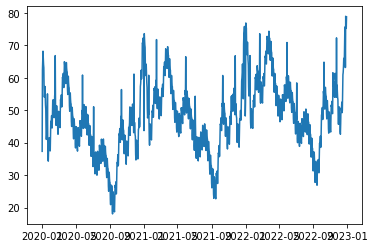

In [124]:
plt.plot(forecast_soarin["ds"], forecast_soarin["yhat"])
plt.show()

### Hollywood Studios - 3RD WK SEPT - WEDNESDAY

Rock n Roller Coaster

In [125]:
forecast_rock_n_rollercoaster.nsmallest(5, "yhat")[["ds", "yhat", "weekday"]]

ds       yhat  weekday
2084 2020-09-16  33.000249        2
2448 2021-09-15  34.551445        2
2077 2020-09-09  34.558290        2
2083 2020-09-15  36.037068        1
2812 2022-09-14  36.275662        2

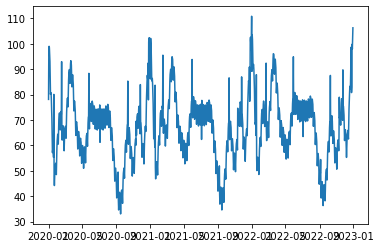

In [126]:
plt.plot(forecast_rock_n_rollercoaster["ds"], forecast_rock_n_rollercoaster["yhat"])
plt.show()

### Animal Kingdom - 2ND WK SEPT - WEDNESDAY

Expedition Everest, Kilimanjaro Safari

In [70]:
ak_adult_expedition = forecast_expedition_everest[["ds", "yhat", "weekday"]]
ak_adult_expedition

NameError: name 'forecast_expedition_everest' is not defined

In [71]:
ak_adult_kilimanjaro = forecast_kilimanjaro_safaris[["ds", "yhat", "weekday"]]
ak_adult_kilimanjaro

NameError: name 'forecast_kilimanjaro_safaris' is not defined

In [72]:
ak_adult = ak_adult_expedition.merge(mk_adult_kilimanjaro, on='ds')
ak_adult

NameError: name 'ak_adult_expedition' is not defined

In [73]:
ak_adult['yhat'] = (ak_adult['yhat_x'] + ak_adult['yhat_y'])/2
ak_adult

NameError: name 'ak_adult' is not defined

In [131]:
ak_adult = ak_adult[['ds', 'yhat', 'weekday_x']]
ak_adult.nsmallest(5, "yhat")[["ds", "yhat", "weekday_x"]]

ds       yhat  weekday_x
252 2020-09-09  27.630633          2
259 2020-09-16  28.737397          2
245 2020-09-02  28.775906          2
251 2020-09-08  30.880678          1
253 2020-09-10  31.255274          3

# Best Time of Year to go to Each Park

### Magic Kingdom

### Epcot

### Animal Kingdom

### Hollywood Studios